In [259]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os,re
from imblearn.under_sampling import NearMiss

In [174]:
!ls {data_dir}/reduced_datasets

bouldin_3NN_banana_0.01.csv	   nearmiss2_banana_0.1.csv
bouldin_3NN_banana_0.02.csv	   nearmiss2_banana_0.2.csv
bouldin_3NN_banana_0.05.csv	   nearmiss2_banana_0.3.csv
bouldin_3NN_banana_0.1.csv	   nearmiss2_banana_0.4.csv
bouldin_3NN_banana_0.2.csv	   nearmiss2_banana_0.5.csv
bouldin_3NN_banana_0.3.csv	   nearmiss2_bupa_0.01.csv
bouldin_3NN_banana_0.4.csv	   nearmiss2_bupa_0.02.csv
bouldin_3NN_banana_0.5.csv	   nearmiss2_bupa_0.05.csv
bouldin_3NN_bupa_0.01.csv	   nearmiss2_bupa_0.1.csv
bouldin_3NN_bupa_0.02.csv	   nearmiss2_bupa_0.2.csv
bouldin_3NN_bupa_0.05.csv	   nearmiss2_bupa_0.3.csv
bouldin_3NN_bupa_0.1.csv	   nearmiss2_bupa_0.4.csv
bouldin_3NN_bupa_0.2.csv	   nearmiss2_bupa_0.5.csv
bouldin_3NN_bupa_0.3.csv	   nearmiss2_magic_0.01.csv
bouldin_3NN_bupa_0.4.csv	   nearmiss2_magic_0.02.csv
bouldin_3NN_bupa_0.5.csv	   nearmiss2_magic_0.05.csv
bouldin_3NN_magic_0.01.csv	   nearmiss2_magic_0.1.csv
bouldin_3NN_magic_0.02.csv	   nearmiss2_magic_0.2.csv
bouldin_3NN_magic_0.05.csv	   nearm

In [317]:
regex_pattern = r'pattern_\d+\.txt'  # Replace this with your desired regular expression pattern
input_files= ["banana","bupa" , "magic" ,"monk-2" ,"pima" ,"ring" ,"twonorm" ,"phoneme"]
# input_files= ["bupa" , "magic" ,"monk-2" ,"pima" ,"ring" ,"twonorm" ,"phoneme"]
data_dir='xsetin00/Data'
reduced_data_dir=f'{data_dir}/reduced_datasets'

methods_to_drop=["bouldin_tree","clustercentroids"]
datasets={}
for i in input_files:
    regex_pattern=r'^.*'+i+r'.*$'
    datasets[i]={"train":[],"test":None}

    # Iterate through the files in the source directory
    for filename in os.listdir(reduced_data_dir):
        
        # Check if the file matches the regular expression pattern
        if re.match(regex_pattern, filename):
            if filename[:4]=="test":
                datasets[i]["test"]=filename
            else:
                if re.match(r'^.*'+methods_to_drop[0]+r'.*$', filename): continue #or re.match(r'^.*'+methods_to_drop[1]+r'.*$', filename): continue
                datasets[i]["train"].append(filename)

print(len(datasets["bupa"]["train"]))
print(datasets["bupa"]["train"])

79
['nearmiss3_bupa_0.4.csv', 'clustercentroids_bupa_0.05.csv', 'random_mixed_data_1nngen_bupa_0.4.csv', 'mixed_data_nogen_bupa_0.5.csv', 'nearmiss1_bupa_0.5.csv', 'grouped_mixed_data_bupa_0.2.csv', 'grouped_mixed_data_bupa_0.3.csv', 'nearmiss2_bupa_0.2.csv', 'nearmiss2_bupa_0.05.csv', 'clustercentroids_bupa_0.01.csv', 'random_mixed_data_gen_bupa_0.3.csv', 'nearmiss2_bupa_0.01.csv', 'clustercentroids_bupa_0.5.csv', 'nearmiss1_bupa_0.05.csv', 'grouped_mixed_data_bupa_0.05.csv', 'random_mixed_data_gen_bupa_0.5.csv', 'random_mixed_data_nogen_bupa_0.5.csv', 'nearmiss1_bupa_0.1.csv', 'nearmiss3_bupa_0.02.csv', 'grouped_mixed_data_bupa_0.5.csv', 'nearmiss1_bupa_0.4.csv', 'random_mixed_data_nogen_bupa_0.05.csv', 'nearmiss1_bupa_0.01.csv', 'randomsampler_bupa_0.05.csv', 'old_bupa_0.0.csv', 'mixed_data_nogen_bupa_0.3.csv', 'grouped_mixed_data_bupa_0.4.csv', 'bouldin_3NN_bupa_0.01.csv', 'random_mixed_data_nogen_bupa_0.1.csv', 'random_mixed_data_1nngen_bupa_0.1.csv', 'nearmiss3_bupa_0.01.csv', 'g

In [319]:
def drop_duplicates(X,amount):
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    neighbor_pairs = []
    for i in range(len(X)):
        distance = distances[i][1]  # 
        neighbor_index = indices[i][1]  #
        neighbor_pairs.append((i, neighbor_index, distance))
    neighbor_pairs.sort(key=lambda x: x[2])
    #print("original size",len(neighbor_pairs))
    points_to_drop = []
    for row in neighbor_pairs:
        _, neighbour, _ = row
        if neighbour not in points_to_drop:
            points_to_drop.append(neighbour)
    points_to_drop=points_to_drop[:(X.shape[0]-amount)]         
    #print("to drop",len(points_to_drop))

    return pd.DataFrame(np.delete(X, points_to_drop, axis=0),columns=X.columns)

In [320]:
models=[(DecisionTreeClassifier(random_state=0),"DT"),
    (RandomForestClassifier(max_depth=5,random_state=0),"RF"),
    (MLPClassifier(random_state=0),"NN"),
    (KNeighborsClassifier(n_neighbors=3),"KNN")]

data_to_visualize=pd.DataFrame()

for dataset in datasets:

    csv_test_data=pd.read_csv(os.path.join(reduced_data_dir,datasets[dataset]["test"]))
    y_test=csv_test_data["Class"]
    X_test=csv_test_data.drop("Class",axis=1)
    print(X_test.shape) 
    index_old=datasets[dataset]["train"].index(f"old_{dataset}_0.0.csv")
    old_train_data=pd.read_csv(os.path.join(reduced_data_dir,datasets[dataset]["train"][index_old]))
    old_size=old_train_data.shape[0]
    for train_data_name in datasets[dataset]["train"]:
        print(train_data_name)

        csv_train_data=pd.read_csv(os.path.join(reduced_data_dir,train_data_name))
        original_size=csv_train_data.shape[0]
        if original_size == 0: continue
        metadata=train_data_name.split("_")
        print(metadata)
        red=metadata[-1][:-4]
        method=metadata[0]+"_"+metadata[1] if metadata[0] == "bouldin" else metadata[0]
        if (len(metadata)>3) and (metadata[3][-1] == "n"):
            method=method+"_"+metadata[3]
        print(method,red)
        if train_data_name[:5] == "mixed" or metadata[0] == "random":
            continue
            # print(train_data_name)
            # csv_train_data=csv_train_data.drop_duplicates()
            # red=float(red)*(csv_train_data.shape[0]/original_size)
        csv_train_data=csv_train_data.drop_duplicates()
        y_train=csv_train_data["Class"]
        X_train=csv_train_data.drop("Class",axis=1)
        if method == "grouped":
            style="1NN_class_sens"
            amount=int(old_size*float(red)*0.5)
            print("to extract",amount)
            if style == "nearmiss":
                for i in range(1,4):
                    sampler = NearMiss(sampling_strategy={0:amount,1:amount},version=i,n_jobs=-1)
                    X_train_red, y_train_red = sampler.fit_resample(X_train, y_train)
                    #print(X_train_red.shape)
                    for model,name in models:
                        
                        model.fit(X_train_red,y_train_red)
                        try:
                            y_pred=model.predict(X_test)    
                        except:
                            continue
                        acc=accuracy_score(y_test,y_pred)
                        #print(acc)
                        df=pd.DataFrame({"Dataset":dataset,
                                            "RED":red,
                                            "Method":f"{method}_{style}_{i}",
                                            "ACC":acc,
                                            "Model":name},
                                            index=[0])

                        data_to_visualize=pd.concat([data_to_visualize,df],ignore_index=True)
            else: # drop 1nn neighbours
                posX=X_train[y_train==1]
                posy=y_train[y_train==1]
                negX=X_train[y_train==0]
                negy=y_train[y_train==0]
                X_train_red=pd.DataFrame()
                for X,y in [(posX,posy),(negX,negy)]:
                    class_red=drop_duplicates(X,amount)
                    while class_red.shape[0] != amount: 
                        class_red=drop_duplicates(class_red,amount)
                        print("extracted",class_red.shape[0])
                    X_train_red=pd.concat([X_train_red,class_red])
                X_train_red.reset_index(drop=True,inplace=True)
                #print(X_train_red)
                #X_train_red=np.array(X_train_red)    
                print(X_train_red.shape)
                # take first n elements of y
                y_train_red = pd.concat([posy[:amount],negy[:amount]])   
                for model,name in models:
                    
                    model.fit(X_train_red,y_train_red)
                    try:
                        y_pred=model.predict(X_test)    
                    except:
                        continue
                    acc=accuracy_score(y_test,y_pred)
                    print(acc)
                    df=pd.DataFrame({"Dataset":dataset,
                                        "RED":red,
                                        "Method":f"{method}_{style}",
                                        "ACC":acc,
                                        "Model":name},
                                        index=[0])

                    data_to_visualize=pd.concat([data_to_visualize,df],ignore_index=True)
        else:    
            print(X_train.shape)
            for model,name in models:
                
                model.fit(X_train,y_train)
                try:
                    y_pred=model.predict(X_test)    
                except:
                    continue
                acc=accuracy_score(y_test,y_pred)
                print(acc)
                df=pd.DataFrame({"Dataset":dataset,
                                    "RED":red,
                                    "Method":method,
                                    "ACC":acc,
                                    "Model":name},
                                    index=[0])

                data_to_visualize=pd.concat([data_to_visualize,df],ignore_index=True)
            

print(data_to_visualize)

(1060, 2)
grouped_mixed_data_banana_0.5.csv
['grouped', 'mixed', 'data', 'banana', '0.5.csv']
grouped 0.5
to extract 1060
(2120, 2)
0.8415094339622642
0.8773584905660378


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8858490566037736
0.8745283018867924
mixed_data_nogen_banana_0.05.csv
['mixed', 'data', 'nogen', 'banana', '0.05.csv']
mixed 0.05
grouped_mixed_data_banana_0.2.csv
['grouped', 'mixed', 'data', 'banana', '0.2.csv']
grouped 0.2
to extract 424
extracted 424
extracted 424
(848, 2)
0.8471698113207548
0.8839622641509434


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8509433962264151
0.870754716981132
bouldin_3NN_banana_0.1.csv
['bouldin', '3NN', 'banana', '0.1.csv']
bouldin_3NN 0.1
(424, 2)
0.8424528301886792
0.8518867924528302


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7688679245283019
0.8584905660377359
random_mixed_data_1nngen_banana_0.4.csv
['random', 'mixed', 'data', '1nngen', 'banana', '0.4.csv']
random_1nngen 0.4
nearmiss2_banana_0.3.csv
['nearmiss2', 'banana', '0.3.csv']
nearmiss2 0.3
(1272, 2)
0.7339622641509433
0.7113207547169811


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7160377358490566
0.7509433962264151
random_mixed_data_gen_banana_0.05.csv
['random', 'mixed', 'data', 'gen', 'banana', '0.05.csv']
random_gen 0.05
mixed_data_nogen_banana_0.3.csv
['mixed', 'data', 'nogen', 'banana', '0.3.csv']
mixed 0.3
clustercentroids_banana_0.1.csv
['clustercentroids', 'banana', '0.1.csv']
clustercentroids 0.1
(424, 2)
0.8509433962264151
0.8575471698113207


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7641509433962265
0.8811320754716981
bouldin_3NN_banana_0.5.csv
['bouldin', '3NN', 'banana', '0.5.csv']
bouldin_3NN 0.5
(2120, 2)
0.8575471698113207
0.8575471698113207


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8754716981132076
0.8745283018867924
randomsampler_banana_0.3.csv
['randomsampler', 'banana', '0.3.csv']
randomsampler 0.3
(1272, 2)
0.8650943396226415
0.869811320754717


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8745283018867924
0.8877358490566037
mixed_data_nogen_banana_0.2.csv
['mixed', 'data', 'nogen', 'banana', '0.2.csv']
mixed 0.2
nearmiss1_banana_0.1.csv
['nearmiss1', 'banana', '0.1.csv']
nearmiss1 0.1
(423, 2)
0.810377358490566
0.8283018867924529


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8009433962264151
0.8433962264150944
nearmiss1_banana_0.5.csv
['nearmiss1', 'banana', '0.5.csv']
nearmiss1 0.5
(2119, 2)
0.85
0.8735849056603774


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8735849056603774
0.8735849056603774
bouldin_3NN_banana_0.01.csv
['bouldin', '3NN', 'banana', '0.01.csv']
bouldin_3NN 0.01
(43, 2)
0.7783018867924528
0.7641509433962265
0.720754716981132


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7924528301886793
random_mixed_data_1nngen_banana_0.5.csv
['random', 'mixed', 'data', '1nngen', 'banana', '0.5.csv']
random_1nngen 0.5
random_mixed_data_1nngen_banana_0.05.csv
['random', 'mixed', 'data', '1nngen', 'banana', '0.05.csv']
random_1nngen 0.05
nearmiss1_banana_0.4.csv
['nearmiss1', 'banana', '0.4.csv']
nearmiss1 0.4
(1695, 2)
0.8632075471698113
0.869811320754717


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8650943396226415
0.8754716981132076
clustercentroids_banana_0.02.csv
['clustercentroids', 'banana', '0.02.csv']
clustercentroids 0.02
(84, 2)
0.8358490566037736
0.8594339622641509
0.8


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8896226415094339
nearmiss3_banana_0.5.csv
['nearmiss3', 'banana', '0.5.csv']
nearmiss3 0.5
(1651, 2)
0.8292452830188679
0.789622641509434


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8226415094339623
0.8584905660377359
random_mixed_data_gen_banana_0.2.csv
['random', 'mixed', 'data', 'gen', 'banana', '0.2.csv']
random_gen 0.2
nearmiss2_banana_0.4.csv
['nearmiss2', 'banana', '0.4.csv']
nearmiss2 0.4
(1695, 2)
0.7349056603773585
0.7556603773584906


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7566037735849057
0.7811320754716982
nearmiss3_banana_0.01.csv
['nearmiss3', 'banana', '0.01.csv']
nearmiss3 0.01
(42, 2)
0.6556603773584906
0.6424528301886793
0.4830188679245283


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6311320754716981
randomsampler_banana_0.5.csv
['randomsampler', 'banana', '0.5.csv']
randomsampler 0.5
(2118, 2)
0.8547169811320755
0.8839622641509434


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8811320754716981
0.8679245283018868
nearmiss3_banana_0.02.csv
['nearmiss3', 'banana', '0.02.csv']
nearmiss3 0.02
(84, 2)
0.6311320754716981
0.6518867924528302
0.5094339622641509


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6066037735849057
nearmiss1_banana_0.01.csv
['nearmiss1', 'banana', '0.01.csv']
nearmiss1 0.01
(42, 2)
0.7339622641509433
0.7783018867924528
0.5811320754716981


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7037735849056603
random_mixed_data_1nngen_banana_0.3.csv
['random', 'mixed', 'data', '1nngen', 'banana', '0.3.csv']
random_1nngen 0.3
nearmiss3_banana_0.05.csv
['nearmiss3', 'banana', '0.05.csv']
nearmiss3 0.05
(212, 2)
0.7
0.5886792452830188
0.4962264150943396
0.7037735849056603
randomsampler_banana_0.2.csv
['randomsampler', 'banana', '0.2.csv']
randomsampler 0.2
(847, 2)
0.8547169811320755
0.8622641509433963


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8603773584905661
0.879245283018868
nearmiss3_banana_0.4.csv
['nearmiss3', 'banana', '0.4.csv']
nearmiss3 0.4
(1439, 2)
0.7641509433962265
0.8669811320754717


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8377358490566038
0.8594339622641509
bouldin_3NN_banana_0.4.csv
['bouldin', '3NN', 'banana', '0.4.csv']
bouldin_3NN 0.4
(1695, 2)
0.8603773584905661
0.8669811320754717


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8764150943396226
0.8754716981132076
grouped_mixed_data_banana_0.4.csv
['grouped', 'mixed', 'data', 'banana', '0.4.csv']
grouped 0.4
to extract 848
extracted 848
extracted 848
(1696, 2)
0.869811320754717
0.879245283018868


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8820754716981132
0.8849056603773585
nearmiss2_banana_0.5.csv
['nearmiss2', 'banana', '0.5.csv']
nearmiss2 0.5
(2117, 2)
0.7433962264150943
0.769811320754717


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7716981132075472
0.8084905660377358
random_mixed_data_nogen_banana_0.4.csv
['random', 'mixed', 'data', 'nogen', 'banana', '0.4.csv']
random_nogen 0.4
random_mixed_data_1nngen_banana_0.2.csv
['random', 'mixed', 'data', '1nngen', 'banana', '0.2.csv']
random_1nngen 0.2
random_mixed_data_nogen_banana_0.05.csv
['random', 'mixed', 'data', 'nogen', 'banana', '0.05.csv']
random_nogen 0.05
bouldin_3NN_banana_0.02.csv
['bouldin', '3NN', 'banana', '0.02.csv']
bouldin_3NN 0.02
(83, 2)
0.8254716981132075
0.8226415094339623
0.7349056603773585


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8150943396226416
mixed_data_nogen_banana_0.1.csv
['mixed', 'data', 'nogen', 'banana', '0.1.csv']
mixed 0.1
randomsampler_banana_0.02.csv
['randomsampler', 'banana', '0.02.csv']
randomsampler 0.02
(84, 2)
0.8037735849056604
0.8056603773584906
0.8254716981132075


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8301886792452831
nearmiss3_banana_0.1.csv
['nearmiss3', 'banana', '0.1.csv']
nearmiss3 0.1
(424, 2)
0.7481132075471698
0.619811320754717


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5566037735849056
0.8084905660377358
bouldin_3NN_banana_0.3.csv
['bouldin', '3NN', 'banana', '0.3.csv']
bouldin_3NN 0.3
(1272, 2)
0.8556603773584905
0.8669811320754717


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.870754716981132
0.8716981132075472
random_mixed_data_nogen_banana_0.5.csv
['random', 'mixed', 'data', 'nogen', 'banana', '0.5.csv']
random_nogen 0.5
grouped_mixed_data_banana_0.3.csv
['grouped', 'mixed', 'data', 'banana', '0.3.csv']
grouped 0.3
to extract 636
extracted 636
extracted 636
(1272, 2)
0.8443396226415094
0.8858490566037736


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.879245283018868
0.8830188679245283
nearmiss2_banana_0.01.csv
['nearmiss2', 'banana', '0.01.csv']
nearmiss2 0.01
(42, 2)
0.659433962264151
0.6018867924528302
0.5735849056603773


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.559433962264151
random_mixed_data_gen_banana_0.4.csv
['random', 'mixed', 'data', 'gen', 'banana', '0.4.csv']
random_gen 0.4
randomsampler_banana_0.1.csv
['randomsampler', 'banana', '0.1.csv']
randomsampler 0.1
(424, 2)
0.8556603773584905
0.869811320754717


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8179245283018868
0.8716981132075472
clustercentroids_banana_0.01.csv
['clustercentroids', 'banana', '0.01.csv']
clustercentroids 0.01
(42, 2)
0.7547169811320755
0.8056603773584906
0.8160377358490566


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8641509433962264
clustercentroids_banana_0.3.csv
['clustercentroids', 'banana', '0.3.csv']
clustercentroids 0.3
(1272, 2)
0.8490566037735849
0.8735849056603774


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8820754716981132
0.8820754716981132
old_banana_0.0.csv
['old', 'banana', '0.0.csv']
old 0.0
(4236, 2)
0.8556603773584905
0.8716981132075472


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8924528301886793
0.8773584905660378
random_mixed_data_gen_banana_0.5.csv
['random', 'mixed', 'data', 'gen', 'banana', '0.5.csv']
random_gen 0.5
nearmiss3_banana_0.2.csv
['nearmiss3', 'banana', '0.2.csv']
nearmiss3 0.2
(848, 2)
0.7783018867924528
0.7981132075471699


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7160377358490566
0.8584905660377359
clustercentroids_banana_0.2.csv
['clustercentroids', 'banana', '0.2.csv']
clustercentroids 0.2
(848, 2)
0.8424528301886792
0.8867924528301887


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8688679245283019
0.8858490566037736
clustercentroids_banana_0.5.csv
['clustercentroids', 'banana', '0.5.csv']
clustercentroids 0.5
(2120, 2)
0.8339622641509434
0.8773584905660378


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8877358490566037
0.8688679245283019
nearmiss3_banana_0.3.csv
['nearmiss3', 'banana', '0.3.csv']
nearmiss3 0.3
(1227, 2)
0.7915094339622641
0.8245283018867925


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7820754716981132
0.8556603773584905
random_mixed_data_nogen_banana_0.2.csv
['random', 'mixed', 'data', 'nogen', 'banana', '0.2.csv']
random_nogen 0.2
random_mixed_data_gen_banana_0.1.csv
['random', 'mixed', 'data', 'gen', 'banana', '0.1.csv']
random_gen 0.1
randomsampler_banana_0.05.csv
['randomsampler', 'banana', '0.05.csv']
randomsampler 0.05
(212, 2)
0.8254716981132075
0.8575471698113207


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.710377358490566
0.8632075471698113
mixed_data_nogen_banana_0.5.csv
['mixed', 'data', 'nogen', 'banana', '0.5.csv']
mixed 0.5
nearmiss2_banana_0.1.csv
['nearmiss2', 'banana', '0.1.csv']
nearmiss2 0.1
(424, 2)
0.7188679245283018
0.7047169811320755


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6264150943396226
0.689622641509434
random_mixed_data_nogen_banana_0.3.csv
['random', 'mixed', 'data', 'nogen', 'banana', '0.3.csv']
random_nogen 0.3
nearmiss1_banana_0.3.csv
['nearmiss1', 'banana', '0.3.csv']
nearmiss1 0.3
(1271, 2)
0.85
0.8528301886792453


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8386792452830188
0.8726415094339622
randomsampler_banana_0.01.csv
['randomsampler', 'banana', '0.01.csv']
randomsampler 0.01
(42, 2)
0.7830188679245284
0.6971698113207547
0.6188679245283019


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7566037735849057
nearmiss2_banana_0.02.csv
['nearmiss2', 'banana', '0.02.csv']
nearmiss2 0.02
(84, 2)
0.6075471698113207
0.6094339622641509
0.5632075471698114


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6169811320754717
mixed_data_nogen_banana_0.4.csv
['mixed', 'data', 'nogen', 'banana', '0.4.csv']
mixed 0.4
bouldin_3NN_banana_0.05.csv
['bouldin', '3NN', 'banana', '0.05.csv']
bouldin_3NN 0.05
(211, 2)
0.8311320754716981
0.8349056603773585


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7216981132075472
0.8433962264150944
random_mixed_data_nogen_banana_0.1.csv
['random', 'mixed', 'data', 'nogen', 'banana', '0.1.csv']
random_nogen 0.1
nearmiss2_banana_0.05.csv
['nearmiss2', 'banana', '0.05.csv']
nearmiss2 0.05
(212, 2)
0.7094339622641509
0.630188679245283


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5028301886792453
0.6188679245283019
random_mixed_data_gen_banana_0.3.csv
['random', 'mixed', 'data', 'gen', 'banana', '0.3.csv']
random_gen 0.3
nearmiss2_banana_0.2.csv
['nearmiss2', 'banana', '0.2.csv']
nearmiss2 0.2
(848, 2)
0.6783018867924528
0.6811320754716981


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6858490566037736
0.6952830188679245
nearmiss1_banana_0.2.csv
['nearmiss1', 'banana', '0.2.csv']
nearmiss1 0.2
(847, 2)
0.8452830188679246
0.8433962264150944


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8226415094339623
0.8679245283018868
random_mixed_data_1nngen_banana_0.1.csv
['random', 'mixed', 'data', '1nngen', 'banana', '0.1.csv']
random_1nngen 0.1
grouped_mixed_data_banana_0.05.csv
['grouped', 'mixed', 'data', 'banana', '0.05.csv']
grouped 0.05
to extract 106
extracted 106
extracted 106
(212, 2)
0.7726415094339623
0.8273584905660377
0.6537735849056604
0.8452830188679246
grouped_mixed_data_banana_0.1.csv
['grouped', 'mixed', 'data', 'banana', '0.1.csv']
grouped 0.1
to extract 212
extracted 212
extracted 212
(424, 2)
0.8028301886792453
0.8547169811320755


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7830188679245284
0.8509433962264151
clustercentroids_banana_0.4.csv
['clustercentroids', 'banana', '0.4.csv']
clustercentroids 0.4
(1696, 2)
0.8518867924528302
0.870754716981132


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8905660377358491
0.8735849056603774
nearmiss1_banana_0.02.csv
['nearmiss1', 'banana', '0.02.csv']
nearmiss1 0.02
(84, 2)
0.7566037735849057
0.8009433962264151
0.620754716981132


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7660377358490567
clustercentroids_banana_0.05.csv
['clustercentroids', 'banana', '0.05.csv']
clustercentroids 0.05
(212, 2)
0.8622641509433963
0.8773584905660378
0.6405660377358491
0.8915094339622641
nearmiss1_banana_0.05.csv
['nearmiss1', 'banana', '0.05.csv']
nearmiss1 0.05
(211, 2)
0.7471698113207547
0.7603773584905661


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5820754716981132
0.810377358490566
randomsampler_banana_0.4.csv
['randomsampler', 'banana', '0.4.csv']
randomsampler 0.4
(1696, 2)
0.85
0.8735849056603774


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8877358490566037
0.8830188679245283
bouldin_3NN_banana_0.2.csv
['bouldin', '3NN', 'banana', '0.2.csv']
bouldin_3NN 0.2
(849, 2)
0.8471698113207548
0.8471698113207548


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8264150943396227
0.8726415094339622
(69, 6)
nearmiss3_bupa_0.4.csv
['nearmiss3', 'bupa', '0.4.csv']
nearmiss3 0.4
(110, 6)
0.5362318840579711
0.6086956521739131


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5507246376811594
0.5507246376811594
clustercentroids_bupa_0.05.csv
['clustercentroids', 'bupa', '0.05.csv']
clustercentroids 0.05
(12, 6)
0.5797101449275363
0.5942028985507246
0.6231884057971014
0.5072463768115942
random_mixed_data_1nngen_bupa_0.4.csv
['random', 'mixed', 'data', '1nngen', 'bupa', '0.4.csv']
random_1nngen 0.4
mixed_data_nogen_bupa_0.5.csv
['mixed', 'data', 'nogen', 'bupa', '0.5.csv']
mixed 0.5
nearmiss1_bupa_0.5.csv
['nearmiss1', 'bupa', '0.5.csv']
nearmiss1 0.5
(134, 6)
0.6811594202898551


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6666666666666666


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6811594202898551
0.5797101449275363
grouped_mixed_data_bupa_0.2.csv
['grouped', 'mixed', 'data', 'bupa', '0.2.csv']
grouped 0.2
to extract 27
extracted 27
extracted 27
(54, 6)
0.5797101449275363
0.5942028985507246
0.5797101449275363
0.4782608695652174
grouped_mixed_data_bupa_0.3.csv
['grouped', 'mixed', 'data', 'bupa', '0.3.csv']
grouped 0.3
to extract 41
extracted 41


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


extracted 41
(82, 6)
0.5362318840579711
0.6231884057971014
0.6811594202898551
0.4492753623188406
nearmiss2_bupa_0.2.csv
['nearmiss2', 'bupa', '0.2.csv']
nearmiss2 0.2
(52, 6)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.4927536231884058
0.4927536231884058
0.4927536231884058
0.463768115942029
nearmiss2_bupa_0.05.csv
['nearmiss2', 'bupa', '0.05.csv']
nearmiss2 0.05
(12, 6)
0.5217391304347826


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5652173913043478
0.5217391304347826
0.4782608695652174
clustercentroids_bupa_0.01.csv
['clustercentroids', 'bupa', '0.01.csv']
clustercentroids 0.01
(2, 6)
0.5652173913043478


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5797101449275363
0.6666666666666666
random_mixed_data_gen_bupa_0.3.csv
['random', 'mixed', 'data', 'gen', 'bupa', '0.3.csv']
random_gen 0.3
nearmiss2_bupa_0.01.csv
['nearmiss2', 'bupa', '0.01.csv']
nearmiss2 0.01
(2, 6)
0.6231884057971014


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6231884057971014
0.5797101449275363
clustercentroids_bupa_0.5.csv
['clustercentroids', 'bupa', '0.5.csv']
clustercentroids 0.5
(138, 6)
0.6086956521739131


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6086956521739131


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6666666666666666
0.6086956521739131
nearmiss1_bupa_0.05.csv
['nearmiss1', 'bupa', '0.05.csv']
nearmiss1 0.05
(10, 6)
0.5362318840579711
0.5362318840579711
0.5362318840579711
0.5217391304347826
grouped_mixed_data_bupa_0.05.csv
['grouped', 'mixed', 'data', 'bupa', '0.05.csv']
grouped 0.05
to extract 6
extracted 6
extracted 6
(12, 6)
0.5217391304347826


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5362318840579711
0.5797101449275363
0.5362318840579711
random_mixed_data_gen_bupa_0.5.csv
['random', 'mixed', 'data', 'gen', 'bupa', '0.5.csv']
random_gen 0.5
random_mixed_data_nogen_bupa_0.5.csv
['random', 'mixed', 'data', 'nogen', 'bupa', '0.5.csv']
random_nogen 0.5
nearmiss1_bupa_0.1.csv
['nearmiss1', 'bupa', '0.1.csv']
nearmiss1 0.1
(24, 6)
0.6666666666666666


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6666666666666666
0.6521739130434783
0.5652173913043478
nearmiss3_bupa_0.02.csv
['nearmiss3', 'bupa', '0.02.csv']
nearmiss3 0.02
(4, 6)
0.5362318840579711


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5362318840579711
0.6086956521739131
0.5362318840579711
grouped_mixed_data_bupa_0.5.csv
['grouped', 'mixed', 'data', 'bupa', '0.5.csv']
grouped 0.5
to extract 69
extracted 69
(138, 6)
0.6231884057971014


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6666666666666666


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6956521739130435
0.4782608695652174
nearmiss1_bupa_0.4.csv
['nearmiss1', 'bupa', '0.4.csv']
nearmiss1 0.4
(106, 6)
0.6231884057971014
0.6521739130434783
0.6666666666666666


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5797101449275363
random_mixed_data_nogen_bupa_0.05.csv
['random', 'mixed', 'data', 'nogen', 'bupa', '0.05.csv']
random_nogen 0.05
nearmiss1_bupa_0.01.csv
['nearmiss1', 'bupa', '0.01.csv']
nearmiss1 0.01
(2, 6)
0.5797101449275363
0.5507246376811594
0.4927536231884058
randomsampler_bupa_0.05.csv
['randomsampler', 'bupa', '0.05.csv']
randomsampler 0.05
(12, 6)
0.5362318840579711


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.4927536231884058
0.6231884057971014
0.5507246376811594
old_bupa_0.0.csv
['old', 'bupa', '0.0.csv']
old 0.0
(272, 6)
0.6231884057971014


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7681159420289855


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6811594202898551
0.6231884057971014
mixed_data_nogen_bupa_0.3.csv
['mixed', 'data', 'nogen', 'bupa', '0.3.csv']
mixed 0.3
grouped_mixed_data_bupa_0.4.csv
['grouped', 'mixed', 'data', 'bupa', '0.4.csv']
grouped 0.4
to extract 55
extracted 55
(110, 6)
0.5507246376811594
0.5942028985507246


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5942028985507246
0.6086956521739131
bouldin_3NN_bupa_0.01.csv
random_mixed_data_nogen_bupa_0.1.csv
['random', 'mixed', 'data', 'nogen', 'bupa', '0.1.csv']
random_nogen 0.1
random_mixed_data_1nngen_bupa_0.1.csv
['random', 'mixed', 'data', '1nngen', 'bupa', '0.1.csv']
random_1nngen 0.1
nearmiss3_bupa_0.01.csv
['nearmiss3', 'bupa', '0.01.csv']
nearmiss3 0.01
(2, 6)
0.5362318840579711
0.5217391304347826
0.5072463768115942
grouped_mixed_data_bupa_0.1.csv
['grouped', 'mixed', 'data', 'bupa', '0.1.csv']
grouped 0.1
to extract 13
extracted 14
extracted 13
extracted 13
(26, 6)
0.42028985507246375


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.4057971014492754
0.5362318840579711
0.4492753623188406
random_mixed_data_nogen_bupa_0.3.csv
['random', 'mixed', 'data', 'nogen', 'bupa', '0.3.csv']
random_nogen 0.3
bouldin_3NN_bupa_0.3.csv
['bouldin', '3NN', 'bupa', '0.3.csv']
bouldin_3NN 0.3
(81, 6)
0.6956521739130435


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6521739130434783
0.782608695652174
0.463768115942029
randomsampler_bupa_0.4.csv
['randomsampler', 'bupa', '0.4.csv']
randomsampler 0.4
(109, 6)
0.6811594202898551


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5942028985507246


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7246376811594203
0.5942028985507246
nearmiss3_bupa_0.05.csv
['nearmiss3', 'bupa', '0.05.csv']
nearmiss3 0.05
(12, 6)
0.5797101449275363
0.5217391304347826
0.6231884057971014
0.6521739130434783
clustercentroids_bupa_0.02.csv
['clustercentroids', 'bupa', '0.02.csv']
clustercentroids 0.02
(4, 6)
0.5652173913043478


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5797101449275363
0.6086956521739131
0.4927536231884058
clustercentroids_bupa_0.4.csv
['clustercentroids', 'bupa', '0.4.csv']
clustercentroids 0.4
(110, 6)
0.5942028985507246


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5797101449275363


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6666666666666666
0.5507246376811594
nearmiss3_bupa_0.1.csv
['nearmiss3', 'bupa', '0.1.csv']
nearmiss3 0.1
(26, 6)
0.5942028985507246
0.6376811594202898
0.6521739130434783
0.5942028985507246
nearmiss1_bupa_0.02.csv
['nearmiss1', 'bupa', '0.02.csv']
nearmiss1 0.02
(3, 6)
0.5652173913043478


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5507246376811594
0.4927536231884058
0.5362318840579711
random_mixed_data_gen_bupa_0.1.csv
['random', 'mixed', 'data', 'gen', 'bupa', '0.1.csv']
random_gen 0.1
bouldin_3NN_bupa_0.4.csv
['bouldin', '3NN', 'bupa', '0.4.csv']
bouldin_3NN 0.4
(107, 6)
0.5507246376811594


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6956521739130435


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6666666666666666
0.6086956521739131
randomsampler_bupa_0.02.csv
['randomsampler', 'bupa', '0.02.csv']
randomsampler 0.02
(4, 6)
0.5507246376811594
0.6376811594202898
0.5362318840579711
0.5507246376811594
randomsampler_bupa_0.1.csv
['randomsampler', 'bupa', '0.1.csv']
randomsampler 0.1
(26, 6)
0.6231884057971014


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6376811594202898
0.5652173913043478
0.5652173913043478
random_mixed_data_gen_bupa_0.2.csv
['random', 'mixed', 'data', 'gen', 'bupa', '0.2.csv']
random_gen 0.2
nearmiss1_bupa_0.3.csv
['nearmiss1', 'bupa', '0.3.csv']
nearmiss1 0.3
(78, 6)
0.6376811594202898


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7246376811594203
0.7101449275362319
0.6231884057971014
clustercentroids_bupa_0.2.csv
['clustercentroids', 'bupa', '0.2.csv']
clustercentroids 0.2
(54, 6)
0.4782608695652174


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6521739130434783
0.6666666666666666
0.5797101449275363
bouldin_3NN_bupa_0.05.csv
['bouldin', '3NN', 'bupa', '0.05.csv']
bouldin_3NN 0.05
(11, 6)
0.5652173913043478


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.4927536231884058
0.5942028985507246
0.5362318840579711
mixed_data_nogen_bupa_0.2.csv
['mixed', 'data', 'nogen', 'bupa', '0.2.csv']
mixed 0.2
randomsampler_bupa_0.2.csv
['randomsampler', 'bupa', '0.2.csv']
randomsampler 0.2
(54, 6)
0.6086956521739131


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7246376811594203
0.6086956521739131
0.6666666666666666
randomsampler_bupa_0.3.csv
['randomsampler', 'bupa', '0.3.csv']
randomsampler 0.3
(81, 6)
0.5072463768115942


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6811594202898551
0.6811594202898551
0.6811594202898551
mixed_data_nogen_bupa_0.05.csv
['mixed', 'data', 'nogen', 'bupa', '0.05.csv']
mixed 0.05
nearmiss3_bupa_0.2.csv
['nearmiss3', 'bupa', '0.2.csv']
nearmiss3 0.2
(54, 6)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5217391304347826
0.5217391304347826
0.5797101449275363
0.5072463768115942
bouldin_3NN_bupa_0.5.csv
['bouldin', '3NN', 'bupa', '0.5.csv']
bouldin_3NN 0.5
(136, 6)
0.6666666666666666


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7101449275362319


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7246376811594203
0.5797101449275363
random_mixed_data_1nngen_bupa_0.05.csv
['random', 'mixed', 'data', '1nngen', 'bupa', '0.05.csv']
random_1nngen 0.05
nearmiss2_bupa_0.3.csv
['nearmiss2', 'bupa', '0.3.csv']
nearmiss2 0.3
(79, 6)
0.5362318840579711
0.5507246376811594
0.5942028985507246
0.5507246376811594
nearmiss1_bupa_0.2.csv
['nearmiss1', 'bupa', '0.2.csv']
nearmiss1 0.2
(51, 6)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6811594202898551
0.7246376811594203
0.7246376811594203
0.6521739130434783
bouldin_3NN_bupa_0.02.csv
bouldin_3NN_bupa_0.1.csv
['bouldin', '3NN', 'bupa', '0.1.csv']
bouldin_3NN 0.1
(25, 6)
0.42028985507246375


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.391304347826087
0.4927536231884058
0.5072463768115942
nearmiss2_bupa_0.5.csv
['nearmiss2', 'bupa', '0.5.csv']
nearmiss2 0.5
(135, 6)
0.4782608695652174


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6086956521739131


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5507246376811594
0.4782608695652174
randomsampler_bupa_0.5.csv
['randomsampler', 'bupa', '0.5.csv']
randomsampler 0.5
(137, 6)
0.6376811594202898
0.6521739130434783


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6811594202898551
0.6811594202898551
nearmiss3_bupa_0.5.csv
['nearmiss3', 'bupa', '0.5.csv']
nearmiss3 0.5
(138, 6)
0.5507246376811594
0.6086956521739131


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6231884057971014
0.5652173913043478
nearmiss2_bupa_0.1.csv
['nearmiss2', 'bupa', '0.1.csv']
nearmiss2 0.1
(25, 6)
0.5217391304347826
0.5217391304347826
0.5942028985507246
0.4782608695652174
clustercentroids_bupa_0.3.csv
['clustercentroids', 'bupa', '0.3.csv']
clustercentroids 0.3
(82, 6)
0.6376811594202898


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6231884057971014
0.6811594202898551
0.5072463768115942
randomsampler_bupa_0.01.csv
['randomsampler', 'bupa', '0.01.csv']
randomsampler 0.01
(2, 6)
0.43478260869565216


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.4927536231884058
0.4927536231884058
clustercentroids_bupa_0.1.csv
['clustercentroids', 'bupa', '0.1.csv']
clustercentroids 0.1
(26, 6)
0.6231884057971014
0.5942028985507246
0.6811594202898551
0.6086956521739131
bouldin_3NN_bupa_0.2.csv
['bouldin', '3NN', 'bupa', '0.2.csv']
bouldin_3NN 0.2
(52, 6)
0.4492753623188406


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5362318840579711
0.6231884057971014
0.5072463768115942
random_mixed_data_gen_bupa_0.4.csv
['random', 'mixed', 'data', 'gen', 'bupa', '0.4.csv']
random_gen 0.4
random_mixed_data_1nngen_bupa_0.3.csv
['random', 'mixed', 'data', '1nngen', 'bupa', '0.3.csv']
random_1nngen 0.3
random_mixed_data_gen_bupa_0.05.csv
['random', 'mixed', 'data', 'gen', 'bupa', '0.05.csv']
random_gen 0.05
random_mixed_data_1nngen_bupa_0.2.csv
['random', 'mixed', 'data', '1nngen', 'bupa', '0.2.csv']
random_1nngen 0.2
random_mixed_data_nogen_bupa_0.2.csv
['random', 'mixed', 'data', 'nogen', 'bupa', '0.2.csv']
random_nogen 0.2
random_mixed_data_nogen_bupa_0.4.csv
['random', 'mixed', 'data', 'nogen', 'bupa', '0.4.csv']
random_nogen 0.4
mixed_data_nogen_bupa_0.4.csv
['mixed', 'data', 'nogen', 'bupa', '0.4.csv']
mixed 0.4
mixed_data_nogen_bupa_0.1.csv
['mixed', 'data', 'nogen', 'bupa', '0.1.csv']
mixed 0.1
nearmiss2_bupa_0.4.csv
['nearmiss2', 'bupa', '0.4.csv']
nearmiss2 0.4
(107, 6)
0.5507246376811594


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5797101449275363
0.5217391304347826


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.4782608695652174
random_mixed_data_1nngen_bupa_0.5.csv
['random', 'mixed', 'data', '1nngen', 'bupa', '0.5.csv']
random_1nngen 0.5
nearmiss3_bupa_0.3.csv
['nearmiss3', 'bupa', '0.3.csv']
nearmiss3 0.3
(82, 6)
0.5507246376811594
0.4927536231884058
0.4782608695652174
0.5362318840579711
nearmiss2_bupa_0.02.csv
['nearmiss2', 'bupa', '0.02.csv']
nearmiss2 0.02
(4, 6)
0.5362318840579711


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.4782608695652174
0.463768115942029
0.5217391304347826
(3804, 10)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


random_mixed_data_1nngen_magic_0.3.csv
['random', 'mixed', 'data', '1nngen', 'magic', '0.3.csv']
random_1nngen 0.3
random_mixed_data_1nngen_magic_0.05.csv
['random', 'mixed', 'data', '1nngen', 'magic', '0.05.csv']
random_1nngen 0.05
nearmiss2_magic_0.1.csv
['nearmiss2', 'magic', '0.1.csv']
nearmiss2 0.1
(1511, 10)
0.9684542586750788
0.9837013669821241


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9889589905362776
0.9135120925341745
bouldin_3NN_magic_0.5.csv
['bouldin', '3NN', 'magic', '0.5.csv']
bouldin_3NN 0.5
(7566, 10)
0.7712933753943217
0.8264984227129337


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8788117770767613
0.8617245005257623
bouldin_3NN_magic_0.1.csv
['bouldin', '3NN', 'magic', '0.1.csv']
bouldin_3NN 0.1
(1518, 10)
0.7407991587802313
0.8301787592008412


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8609358569926393
0.8427970557308097
mixed_data_nogen_magic_0.2.csv
['mixed', 'data', 'nogen', 'magic', '0.2.csv']
mixed 0.2
randomsampler_magic_0.5.csv
['randomsampler', 'magic', '0.5.csv']
randomsampler 0.5
(7569, 10)
0.7807570977917981
0.8517350157728707


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.868559411146162
0.8593585699263933
mixed_data_nogen_magic_0.3.csv
['mixed', 'data', 'nogen', 'magic', '0.3.csv']
mixed 0.3
randomsampler_magic_0.1.csv
['randomsampler', 'magic', '0.1.csv']
randomsampler 0.1
(1518, 10)
0.7505257623554153
0.8172975814931651


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.863564668769716
0.8264984227129337
random_mixed_data_nogen_magic_0.4.csv
['random', 'mixed', 'data', 'nogen', 'magic', '0.4.csv']
random_nogen 0.4
randomsampler_magic_0.01.csv
['randomsampler', 'magic', '0.01.csv']
randomsampler 0.01
(152, 10)
0.6919032597266036
0.8083596214511041


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8136172450052577
0.8002103049421662
bouldin_3NN_magic_0.4.csv
['bouldin', '3NN', 'magic', '0.4.csv']
bouldin_3NN 0.4
(6063, 10)
0.7676130389064143
0.8606729758149316


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8782860147213459
0.8590956887486856
clustercentroids_magic_0.1.csv
['clustercentroids', 'magic', '0.1.csv']
clustercentroids 0.1
(1520, 10)
0.8614616193480547
0.9526813880126183


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.918769716088328
0.9434805467928497
randomsampler_magic_0.4.csv
['randomsampler', 'magic', '0.4.csv']
randomsampler 0.4
(6060, 10)
0.8015247108307045
0.8640904311251314


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8646161934805467
0.8596214511041009
randomsampler_magic_0.3.csv
['randomsampler', 'magic', '0.3.csv']
randomsampler 0.3
(4553, 10)
0.7749737118822292
0.8349106203995794


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8719768664563617
0.86198738170347
nearmiss3_magic_0.02.csv
['nearmiss3', 'magic', '0.02.csv']
nearmiss3 0.02
(304, 10)
0.999211356466877
0.9989484752891693


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9989484752891693
0.9994742376445847
random_mixed_data_nogen_magic_0.2.csv
['random', 'mixed', 'data', 'nogen', 'magic', '0.2.csv']
random_nogen 0.2
nearmiss3_magic_0.01.csv
['nearmiss3', 'magic', '0.01.csv']
nearmiss3 0.01
(152, 10)
0.9986855941114616
0.9994742376445847


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9971083070452156
0.9994742376445847
random_mixed_data_gen_magic_0.4.csv
['random', 'mixed', 'data', 'gen', 'magic', '0.4.csv']
random_gen 0.4
randomsampler_magic_0.2.csv
['randomsampler', 'magic', '0.2.csv']
randomsampler 0.2
(3038, 10)
0.768664563617245
0.8427970557308097


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8698738170347003
0.8654048370136698
randomsampler_magic_0.05.csv
['randomsampler', 'magic', '0.05.csv']
randomsampler 0.05
(760, 10)
0.7565720294426919
0.8617245005257623


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8659305993690851
0.814931650893796
clustercentroids_magic_0.02.csv
['clustercentroids', 'magic', '0.02.csv']
clustercentroids 0.02
(304, 10)
0.86198738170347
0.8937960042060988


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9503154574132492
0.9369085173501577
mixed_data_nogen_magic_0.4.csv
['mixed', 'data', 'nogen', 'magic', '0.4.csv']
mixed 0.4
clustercentroids_magic_0.5.csv
['clustercentroids', 'magic', '0.5.csv']
clustercentroids 0.5
(7608, 10)
0.8220294426919033
0.954521556256572


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9361198738170347
0.917981072555205
nearmiss3_magic_0.3.csv
['nearmiss3', 'magic', '0.3.csv']
nearmiss3 0.3
(4559, 10)
0.9576761303890642
0.9771293375394322


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9808096740273397
0.9842271293375394
nearmiss3_magic_0.5.csv
['nearmiss3', 'magic', '0.5.csv']
nearmiss3 0.5
(7595, 10)
0.8740799158780231
0.9631966351209253


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9513669821240799
0.9576761303890642
nearmiss3_magic_0.1.csv
['nearmiss3', 'magic', '0.1.csv']
nearmiss3 0.1
(1520, 10)
0.9879074658254469
0.9952681388012619


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9971083070452156
0.998422712933754
random_mixed_data_nogen_magic_0.5.csv
['random', 'mixed', 'data', 'nogen', 'magic', '0.5.csv']
random_nogen 0.5
mixed_data_nogen_magic_0.1.csv
['mixed', 'data', 'nogen', 'magic', '0.1.csv']
mixed 0.1
random_mixed_data_gen_magic_0.3.csv
['random', 'mixed', 'data', 'gen', 'magic', '0.3.csv']
random_gen 0.3
grouped_mixed_data_magic_0.3.csv
['grouped', 'mixed', 'data', 'magic', '0.3.csv']
grouped 0.3
to extract 2282
extracted 2282
extracted 2282
(4564, 10)
0.8325446898002103
0.9379600420609885


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9408517350157729
0.906677181913775
clustercentroids_magic_0.05.csv
['clustercentroids', 'magic', '0.05.csv']
clustercentroids 0.05
(760, 10)
0.8406940063091483
0.924553101997897


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9263932702418507
0.937434279705573
nearmiss1_magic_0.2.csv
['nearmiss1', 'magic', '0.2.csv']
nearmiss1 0.2
(2955, 10)
0.5638801261829653
0.6834910620399579


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6900630914826499
0.7181913774973712
bouldin_3NN_magic_0.2.csv
['bouldin', '3NN', 'magic', '0.2.csv']
bouldin_3NN 0.2
(3038, 10)
0.7528916929547844
0.8385909568874869


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.867770767613039
0.8446372239747634
grouped_mixed_data_magic_0.2.csv
['grouped', 'mixed', 'data', 'magic', '0.2.csv']
grouped 0.2
to extract 1521
extracted 1521
extracted 1521
(3042, 10)
0.8512092534174553
0.9658254468980021


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9542586750788643
0.9298107255520505
nearmiss3_magic_0.05.csv
['nearmiss3', 'magic', '0.05.csv']
nearmiss3 0.05
(760, 10)
0.9760778128286015
0.9981598317560463


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.998422712933754
0.999211356466877
clustercentroids_magic_0.01.csv
['clustercentroids', 'magic', '0.01.csv']
clustercentroids 0.01
(152, 10)
0.830441640378549
0.9053627760252366


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.935856992639327
0.9300736067297581
random_mixed_data_1nngen_magic_0.2.csv
['random', 'mixed', 'data', '1nngen', 'magic', '0.2.csv']
random_1nngen 0.2
bouldin_3NN_magic_0.05.csv
['bouldin', '3NN', 'magic', '0.05.csv']
bouldin_3NN 0.05
(761, 10)
0.7468454258675079
0.832807570977918


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8696109358569927
0.8186119873817035
clustercentroids_magic_0.3.csv
['clustercentroids', 'magic', '0.3.csv']
clustercentroids 0.3
(4564, 10)
0.8396424815983176
0.973186119873817


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.944006309148265
0.9334910620399579
nearmiss2_magic_0.4.csv
['nearmiss2', 'magic', '0.4.csv']
nearmiss2 0.4
(6034, 10)
0.4037854889589905
0.5018401682439537


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.38590956887486855
0.4781808622502629
random_mixed_data_gen_magic_0.1.csv
['random', 'mixed', 'data', 'gen', 'magic', '0.1.csv']
random_gen 0.1
randomsampler_magic_0.02.csv
['randomsampler', 'magic', '0.02.csv']
randomsampler 0.02
(304, 10)
0.7660357518401683
0.8217665615141956


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8275499474237644
0.7902208201892744
random_mixed_data_gen_magic_0.5.csv
['random', 'mixed', 'data', 'gen', 'magic', '0.5.csv']
random_gen 0.5
random_mixed_data_gen_magic_0.05.csv
['random', 'mixed', 'data', 'gen', 'magic', '0.05.csv']
random_gen 0.05
random_mixed_data_1nngen_magic_0.1.csv
['random', 'mixed', 'data', '1nngen', 'magic', '0.1.csv']
random_1nngen 0.1
nearmiss1_magic_0.1.csv
['nearmiss1', 'magic', '0.1.csv']
nearmiss1 0.1
(1441, 10)
0.6332807570977917
0.5686119873817035


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5488958990536278
0.6154048370136698
nearmiss2_magic_0.01.csv
['nearmiss2', 'magic', '0.01.csv']
nearmiss2 0.01
(149, 10)
0.9955310199789695
0.9973711882229233


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8588328075709779
0.9942166140904312
mixed_data_nogen_magic_0.05.csv
['mixed', 'data', 'nogen', 'magic', '0.05.csv']
mixed 0.05
nearmiss1_magic_0.02.csv
['nearmiss1', 'magic', '0.02.csv']
nearmiss1 0.02
(243, 10)
0.5047318611987381
0.5959516298633017


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5512618296529969
0.7150368033648791
nearmiss1_magic_0.3.csv
['nearmiss1', 'magic', '0.3.csv']
nearmiss1 0.3
(4470, 10)
0.5791272344900105
0.6832281808622502


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6811251314405888
0.7150368033648791
nearmiss2_magic_0.3.csv
['nearmiss2', 'magic', '0.3.csv']
nearmiss2 0.3
(4525, 10)
0.46004206098843325
0.4395373291272345


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.36225026288117773
0.47791798107255523
random_mixed_data_nogen_magic_0.1.csv
['random', 'mixed', 'data', 'nogen', 'magic', '0.1.csv']
random_nogen 0.1
nearmiss3_magic_0.2.csv
['nearmiss3', 'magic', '0.2.csv']
nearmiss3 0.2
(3042, 10)
0.9679284963196635
0.9892218717139852


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9889589905362776
0.9931650893796005
mixed_data_nogen_magic_0.5.csv
['mixed', 'data', 'nogen', 'magic', '0.5.csv']
mixed 0.5
nearmiss2_magic_0.5.csv
['nearmiss2', 'magic', '0.5.csv']
nearmiss2 0.5
(7546, 10)
0.48264984227129337
0.5383806519453207


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.46004206098843325
0.5241850683491062
bouldin_3NN_magic_0.01.csv
['bouldin', '3NN', 'magic', '0.01.csv']
bouldin_3NN 0.01
(152, 10)
0.7358044164037855
0.8593585699263933


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8493690851735016
0.8144058885383807
grouped_mixed_data_magic_0.4.csv
['grouped', 'mixed', 'data', 'magic', '0.4.csv']
grouped 0.4
to extract 3043
extracted 3043
extracted 3043
(6086, 10)
0.785751840168244
0.8575184016824395


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9103575184016824
0.8614616193480547
random_mixed_data_nogen_magic_0.3.csv
['random', 'mixed', 'data', 'nogen', 'magic', '0.3.csv']
random_nogen 0.3
nearmiss1_magic_0.5.csv
['nearmiss1', 'magic', '0.5.csv']
nearmiss1 0.5
(7499, 10)
0.6154048370136698
0.676130389064143


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7016298633017876
0.7400105152471083
old_magic_0.0.csv
['old', 'magic', '0.0.csv']
old 0.0
(15101, 10)
0.8178233438485805
0.8980021030494216


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8956361724500526
0.8948475289169295
random_mixed_data_1nngen_magic_0.4.csv
['random', 'mixed', 'data', '1nngen', 'magic', '0.4.csv']
random_1nngen 0.4
bouldin_3NN_magic_0.3.csv
['bouldin', '3NN', 'magic', '0.3.csv']
bouldin_3NN 0.3
(4551, 10)
0.7760252365930599
0.8378023133543638


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8730283911671924
0.8643533123028391
grouped_mixed_data_magic_0.5.csv
['grouped', 'mixed', 'data', 'magic', '0.5.csv']
grouped 0.5
to extract 3804
extracted 3804
(7608, 10)
0.7820715036803365
0.8346477392218717


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8890641430073607
0.8572555205047319
nearmiss2_magic_0.02.csv
['nearmiss2', 'magic', '0.02.csv']
nearmiss2 0.02
(301, 10)
0.9952681388012619
0.9976340694006309


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9776550998948476
0.9968454258675079
grouped_mixed_data_magic_0.05.csv
['grouped', 'mixed', 'data', 'magic', '0.05.csv']
grouped 0.05
to extract 380
extracted 380
extracted 380
(760, 10)
0.8183491062039958
0.9324395373291272


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9311251314405888
0.9016824395373291
nearmiss2_magic_0.2.csv
['nearmiss2', 'magic', '0.2.csv']
nearmiss2 0.2
(3016, 10)
0.5310199789695058
0.8556782334384858


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.63801261829653
0.6921661409043113
bouldin_3NN_magic_0.02.csv
['bouldin', '3NN', 'magic', '0.02.csv']
bouldin_3NN 0.02
(303, 10)
0.6616719242902208
0.8188748685594112


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.852260778128286
0.7920609884332281
random_mixed_data_gen_magic_0.2.csv
['random', 'mixed', 'data', 'gen', 'magic', '0.2.csv']
random_gen 0.2
clustercentroids_magic_0.2.csv
['clustercentroids', 'magic', '0.2.csv']
clustercentroids 0.2
(3042, 10)
0.860410094637224
0.9766035751840169


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9384858044164038
0.9413774973711883
nearmiss1_magic_0.05.csv
['nearmiss1', 'magic', '0.05.csv']
nearmiss1 0.05
(687, 10)
0.594900105152471
0.5872765509989485


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.46398527865404837
0.620136698212408
nearmiss1_magic_0.4.csv
['nearmiss1', 'magic', '0.4.csv']
nearmiss1 0.4
(5982, 10)
0.5883280757097792
0.6816508937960042


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6958464773922187
0.7536803364879074
clustercentroids_magic_0.4.csv
['clustercentroids', 'magic', '0.4.csv']
clustercentroids 0.4
(6086, 10)
0.8420084121976866
0.961882229232387


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9429547844374343
0.9258675078864353
nearmiss3_magic_0.4.csv
['nearmiss3', 'magic', '0.4.csv']
nearmiss3 0.4
(6079, 10)
0.8982649842271293
0.9689800210304942


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9655625657202944
0.9729232386961093
random_mixed_data_1nngen_magic_0.5.csv
['random', 'mixed', 'data', '1nngen', 'magic', '0.5.csv']
random_1nngen 0.5
random_mixed_data_nogen_magic_0.05.csv
['random', 'mixed', 'data', 'nogen', 'magic', '0.05.csv']
random_nogen 0.05
grouped_mixed_data_magic_0.1.csv
['grouped', 'mixed', 'data', 'magic', '0.1.csv']
grouped 0.1
to extract 760
extracted 760
extracted 760
(1520, 10)
0.823869610935857
0.9547844374342797


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9474237644584648
0.9127234490010515
nearmiss2_magic_0.05.csv
['nearmiss2', 'magic', '0.05.csv']
nearmiss2 0.05
(756, 10)
0.9716088328075709
0.9918506834910621


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9947423764458465
0.9826498422712934
nearmiss1_magic_0.01.csv
['nearmiss1', 'magic', '0.01.csv']
nearmiss1 0.01
(115, 10)
0.40562565720294425
0.5181388012618297


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6829652996845426
0.7494742376445847
(87, 6)
nearmiss1_monk-2_0.2.csv
['nearmiss1', 'monk-2', '0.2.csv']
nearmiss1 0.2
(68, 6)
1.0
1.0
0.735632183908046
1.0
mixed_data_nogen_monk-2_0.4.csv
['mixed', 'data', 'nogen', 'monk-2', '0.4.csv']
mixed 0.4
random_mixed_data_1nngen_monk-2_0.1.csv
['random', 'mixed', 'data', '1nngen', 'monk-2', '0.1.csv']
random_1nngen 0.1
nearmiss1_monk-2_0.02.csv
['nearmiss1', 'monk-2', '0.02.csv']
nearmiss1 0.02
(6, 6)
0.7471264367816092


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7471264367816092
0.5862068965517241
0.5977011494252874
nearmiss3_monk-2_0.4.csv
['nearmiss3', 'monk-2', '0.4.csv']
nearmiss3 0.4
(138, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7816091954022989
0.6896551724137931
random_mixed_data_1nngen_monk-2_0.3.csv
['random', 'mixed', 'data', '1nngen', 'monk-2', '0.3.csv']
random_1nngen 0.3
random_mixed_data_nogen_monk-2_0.5.csv
['random', 'mixed', 'data', 'nogen', 'monk-2', '0.5.csv']
random_nogen 0.5
grouped_mixed_data_monk-2_0.3.csv
['grouped', 'mixed', 'data', 'monk-2', '0.3.csv']
grouped 0.3
to extract 51
extracted 51
extracted 51
(102, 6)
1.0
1.0
0.9425287356321839


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7931034482758621
mixed_data_nogen_monk-2_0.3.csv
['mixed', 'data', 'nogen', 'monk-2', '0.3.csv']
mixed 0.3
bouldin_3NN_monk-2_0.4.csv
['bouldin', '3NN', 'monk-2', '0.4.csv']
bouldin_3NN 0.4
(139, 6)
1.0
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9310344827586207
0.8390804597701149
random_mixed_data_nogen_monk-2_0.3.csv
['random', 'mixed', 'data', 'nogen', 'monk-2', '0.3.csv']
random_nogen 0.3
bouldin_3NN_monk-2_0.02.csv
['bouldin', '3NN', 'monk-2', '0.02.csv']
bouldin_3NN 0.02
(3, 6)
0.42528735632183906
0.4482758620689655
0.632183908045977
0.26436781609195403
clustercentroids_monk-2_0.3.csv
['clustercentroids', 'monk-2', '0.3.csv']
clustercentroids 0.3
(102, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0
0.896551724137931


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7586206896551724
randomsampler_monk-2_0.2.csv
['randomsampler', 'monk-2', '0.2.csv']
randomsampler 0.2
(68, 6)
1.0
1.0
0.8850574712643678
0.7816091954022989
random_mixed_data_1nngen_monk-2_0.5.csv
['random', 'mixed', 'data', '1nngen', 'monk-2', '0.5.csv']
random_1nngen 0.5
nearmiss1_monk-2_0.1.csv
['nearmiss1', 'monk-2', '0.1.csv']
nearmiss1 0.1
(34, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0
0.9885057471264368
0.9885057471264368
mixed_data_nogen_monk-2_0.1.csv
['mixed', 'data', 'nogen', 'monk-2', '0.1.csv']
mixed 0.1
randomsampler_monk-2_0.05.csv
['randomsampler', 'monk-2', '0.05.csv']
randomsampler 0.05
(16, 6)
0.7471264367816092


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7471264367816092
0.7241379310344828
0.6781609195402298
clustercentroids_monk-2_0.4.csv
['clustercentroids', 'monk-2', '0.4.csv']
clustercentroids 0.4
(138, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9310344827586207
0.8390804597701149
clustercentroids_monk-2_0.05.csv
['clustercentroids', 'monk-2', '0.05.csv']
clustercentroids 0.05
(16, 6)
1.0
0.8275862068965517
0.6436781609195402
0.8045977011494253
random_mixed_data_nogen_monk-2_0.4.csv
['random', 'mixed', 'data', 'nogen', 'monk-2', '0.4.csv']
random_nogen 0.4
grouped_mixed_data_monk-2_0.5.csv
['grouped', 'mixed', 'data', 'monk-2', '0.5.csv']
grouped 0.5
to extract 86
extracted 86
(172, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9080459770114943
0.735632183908046
random_mixed_data_1nngen_monk-2_0.4.csv
['random', 'mixed', 'data', '1nngen', 'monk-2', '0.4.csv']
random_1nngen 0.4
nearmiss3_monk-2_0.2.csv
['nearmiss3', 'monk-2', '0.2.csv']
nearmiss3 0.2
(68, 6)
0.7241379310344828
0.8735632183908046
0.6551724137931034
0.5977011494252874
random_mixed_data_gen_monk-2_0.3.csv
['random', 'mixed', 'data', 'gen', 'monk-2', '0.3.csv']
random_gen 0.3
randomsampler_monk-2_0.4.csv
['randomsampler', 'monk-2', '0.4.csv']
randomsampler 0.4
(138, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9310344827586207
0.7471264367816092
nearmiss2_monk-2_0.4.csv
['nearmiss2', 'monk-2', '0.4.csv']
nearmiss2 0.4
(138, 6)
1.0
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9885057471264368
0.9655172413793104
mixed_data_nogen_monk-2_0.2.csv
['mixed', 'data', 'nogen', 'monk-2', '0.2.csv']
mixed 0.2
clustercentroids_monk-2_0.2.csv
['clustercentroids', 'monk-2', '0.2.csv']
clustercentroids 0.2
(68, 6)
1.0
1.0
0.8735632183908046
0.8275862068965517
nearmiss3_monk-2_0.3.csv
['nearmiss3', 'monk-2', '0.3.csv']
nearmiss3 0.3
(102, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9195402298850575
0.7471264367816092


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5977011494252874
mixed_data_nogen_monk-2_0.5.csv
['mixed', 'data', 'nogen', 'monk-2', '0.5.csv']
mixed 0.5
bouldin_3NN_monk-2_0.2.csv
['bouldin', '3NN', 'monk-2', '0.2.csv']
bouldin_3NN 0.2
(68, 6)
1.0
1.0
0.7931034482758621
0.7471264367816092
old_monk-2_0.0.csv
['old', 'monk-2', '0.0.csv']
old 0.0
(345, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0
0.8620689655172413
bouldin_3NN_monk-2_0.3.csv
['bouldin', '3NN', 'monk-2', '0.3.csv']
bouldin_3NN 0.3
(102, 6)
1.0
1.0
0.8850574712643678


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7586206896551724
nearmiss1_monk-2_0.01.csv
['nearmiss1', 'monk-2', '0.01.csv']
nearmiss1 0.01
(2, 6)
0.7471264367816092
0.7471264367816092
0.7126436781609196
nearmiss2_monk-2_0.2.csv
['nearmiss2', 'monk-2', '0.2.csv']
nearmiss2 0.2
(68, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0
0.8620689655172413
1.0
randomsampler_monk-2_0.02.csv
['randomsampler', 'monk-2', '0.02.csv']
randomsampler 0.02
(6, 6)
0.4942528735632184


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8620689655172413
0.7471264367816092
0.7586206896551724
randomsampler_monk-2_0.5.csv
['randomsampler', 'monk-2', '0.5.csv']
randomsampler 0.5
(172, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9310344827586207
0.7701149425287356
random_mixed_data_gen_monk-2_0.05.csv
['random', 'mixed', 'data', 'gen', 'monk-2', '0.05.csv']
random_gen 0.05
random_mixed_data_1nngen_monk-2_0.05.csv
['random', 'mixed', 'data', '1nngen', 'monk-2', '0.05.csv']
random_1nngen 0.05
nearmiss1_monk-2_0.05.csv
['nearmiss1', 'monk-2', '0.05.csv']
nearmiss1 0.05
(16, 6)
0.7471264367816092
0.7471264367816092
0.7471264367816092
0.7011494252873564
mixed_data_nogen_monk-2_0.05.csv
['mixed', 'data', 'nogen', 'monk-2', '0.05.csv']
mixed 0.05
random_mixed_data_1nngen_monk-2_0.2.csv
['random', 'mixed', 'data', '1nngen', 'monk-2', '0.2.csv']
random_1nngen 0.2
nearmiss2_monk-2_0.05.csv
['nearmiss2', 'monk-2', '0.05.csv']
nearmiss2 0.05
(16, 6)
0.5287356321839081


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0
0.8850574712643678
0.8735632183908046
nearmiss1_monk-2_0.4.csv
['nearmiss1', 'monk-2', '0.4.csv']
nearmiss1 0.4
(138, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9080459770114943
0.9540229885057471
bouldin_3NN_monk-2_0.5.csv
['bouldin', '3NN', 'monk-2', '0.5.csv']
bouldin_3NN 0.5
(174, 6)
1.0
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0
0.8620689655172413
clustercentroids_monk-2_0.01.csv
['clustercentroids', 'monk-2', '0.01.csv']
clustercentroids 0.01
(2, 6)
0.7471264367816092
0.7471264367816092
0.5977011494252874
nearmiss1_monk-2_0.5.csv
['nearmiss1', 'monk-2', '0.5.csv']
nearmiss1 0.5
(172, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9195402298850575
1.0
random_mixed_data_gen_monk-2_0.4.csv
['random', 'mixed', 'data', 'gen', 'monk-2', '0.4.csv']
random_gen 0.4
grouped_mixed_data_monk-2_0.05.csv
['grouped', 'mixed', 'data', 'monk-2', '0.05.csv']
grouped 0.05
to extract 8
extracted 8
extracted 8
(16, 6)
0.9885057471264368
0.9885057471264368
0.8160919540229885
0.7586206896551724
bouldin_3NN_monk-2_0.01.csv
nearmiss3_monk-2_0.1.csv
['nearmiss3', 'monk-2', '0.1.csv']
nearmiss3 0.1
(34, 6)
0.9080459770114943


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6206896551724138
0.6436781609195402
0.5517241379310345
grouped_mixed_data_monk-2_0.1.csv
['grouped', 'mixed', 'data', 'monk-2', '0.1.csv']
grouped 0.1
to extract 17
extracted 20
extracted 17
extracted 17
(34, 6)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0
0.9885057471264368
0.7011494252873564
0.6666666666666666
clustercentroids_monk-2_0.5.csv
['clustercentroids', 'monk-2', '0.5.csv']
clustercentroids 0.5
(172, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9425287356321839
0.8275862068965517
nearmiss2_monk-2_0.5.csv
['nearmiss2', 'monk-2', '0.5.csv']
nearmiss2 0.5
(172, 6)
1.0
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0
1.0
bouldin_3NN_monk-2_0.1.csv
['bouldin', '3NN', 'monk-2', '0.1.csv']
bouldin_3NN 0.1
(33, 6)
1.0
1.0
0.6896551724137931
0.7126436781609196
random_mixed_data_nogen_monk-2_0.1.csv
['random', 'mixed', 'data', 'nogen', 'monk-2', '0.1.csv']
random_nogen 0.1
nearmiss2_monk-2_0.3.csv
['nearmiss2', 'monk-2', '0.3.csv']
nearmiss2 0.3
(102, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0
0.9195402298850575


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9540229885057471
bouldin_3NN_monk-2_0.05.csv
['bouldin', '3NN', 'monk-2', '0.05.csv']
bouldin_3NN 0.05
(15, 6)
1.0
0.8850574712643678
0.5057471264367817
0.6206896551724138
nearmiss3_monk-2_0.5.csv
['nearmiss3', 'monk-2', '0.5.csv']
nearmiss3 0.5
(172, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8160919540229885
0.6551724137931034
clustercentroids_monk-2_0.1.csv
['clustercentroids', 'monk-2', '0.1.csv']
clustercentroids 0.1
(34, 6)
1.0
1.0
0.6896551724137931
0.7816091954022989
nearmiss3_monk-2_0.05.csv
['nearmiss3', 'monk-2', '0.05.csv']
nearmiss3 0.05
(16, 6)
0.735632183908046


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5402298850574713
0.5747126436781609
0.5862068965517241
nearmiss2_monk-2_0.1.csv
['nearmiss2', 'monk-2', '0.1.csv']
nearmiss2 0.1
(34, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0
0.9885057471264368
0.9770114942528736
nearmiss2_monk-2_0.02.csv
['nearmiss2', 'monk-2', '0.02.csv']
nearmiss2 0.02
(6, 6)
0.7471264367816092


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7471264367816092
0.7471264367816092
0.7471264367816092
random_mixed_data_nogen_monk-2_0.2.csv
['random', 'mixed', 'data', 'nogen', 'monk-2', '0.2.csv']
random_nogen 0.2
random_mixed_data_gen_monk-2_0.1.csv
['random', 'mixed', 'data', 'gen', 'monk-2', '0.1.csv']
random_gen 0.1
grouped_mixed_data_monk-2_0.2.csv
['grouped', 'mixed', 'data', 'monk-2', '0.2.csv']
grouped 0.2
to extract 34
extracted 34
extracted 34
(68, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0
0.9195402298850575
0.7701149425287356
random_mixed_data_gen_monk-2_0.2.csv
['random', 'mixed', 'data', 'gen', 'monk-2', '0.2.csv']
random_gen 0.2
nearmiss2_monk-2_0.01.csv
['nearmiss2', 'monk-2', '0.01.csv']
nearmiss2 0.01
(2, 6)
0.7471264367816092


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7471264367816092
0.6436781609195402
randomsampler_monk-2_0.3.csv
['randomsampler', 'monk-2', '0.3.csv']
randomsampler 0.3
(102, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0
0.8505747126436781


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.735632183908046
clustercentroids_monk-2_0.02.csv
['clustercentroids', 'monk-2', '0.02.csv']
clustercentroids 0.02
(6, 6)
0.735632183908046
0.6781609195402298
0.6551724137931034
0.7701149425287356
randomsampler_monk-2_0.1.csv
['randomsampler', 'monk-2', '0.1.csv']
randomsampler 0.1
(34, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0
0.7011494252873564
0.735632183908046
grouped_mixed_data_monk-2_0.4.csv
['grouped', 'mixed', 'data', 'monk-2', '0.4.csv']
grouped 0.4
to extract 69
extracted 69
extracted 69
(138, 6)
1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1.0
0.7931034482758621
nearmiss3_monk-2_0.01.csv
['nearmiss3', 'monk-2', '0.01.csv']
nearmiss3 0.01
(2, 6)
0.4827586206896552
0.5632183908045977
0.2988505747126437
nearmiss3_monk-2_0.02.csv
['nearmiss3', 'monk-2', '0.02.csv']
nearmiss3 0.02
(6, 6)
0.41379310344827586


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.41379310344827586
0.41379310344827586
0.3793103448275862
random_mixed_data_nogen_monk-2_0.05.csv
['random', 'mixed', 'data', 'nogen', 'monk-2', '0.05.csv']
random_nogen 0.05
randomsampler_monk-2_0.01.csv
['randomsampler', 'monk-2', '0.01.csv']
randomsampler 0.01
(2, 6)
0.7471264367816092


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5747126436781609
0.5057471264367817
random_mixed_data_gen_monk-2_0.5.csv
['random', 'mixed', 'data', 'gen', 'monk-2', '0.5.csv']
random_gen 0.5
nearmiss1_monk-2_0.3.csv
['nearmiss1', 'monk-2', '0.3.csv']
nearmiss1 0.3
(102, 6)
1.0
1.0
0.8390804597701149


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9655172413793104
(154, 8)
random_mixed_data_gen_pima_0.5.csv
['random', 'mixed', 'data', 'gen', 'pima', '0.5.csv']
random_gen 0.5
clustercentroids_pima_0.1.csv
['clustercentroids', 'pima', '0.1.csv']
clustercentroids 0.1
(60, 8)
0.6233766233766234
0.6818181818181818
0.7272727272727273
0.7337662337662337
random_mixed_data_nogen_pima_0.3.csv
['random', 'mixed', 'data', 'nogen', 'pima', '0.3.csv']
random_nogen 0.3
random_mixed_data_nogen_pima_0.05.csv
['random', 'mixed', 'data', 'nogen', 'pima', '0.05.csv']
random_nogen 0.05
bouldin_3NN_pima_0.4.csv
['bouldin', '3NN', 'pima', '0.4.csv']
bouldin_3NN 0.4
(244, 8)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6688311688311688
0.7857142857142857


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7727272727272727
0.7077922077922078
nearmiss2_pima_0.05.csv
['nearmiss2', 'pima', '0.05.csv']
nearmiss2 0.05
(30, 8)
0.6818181818181818
0.7467532467532467
0.7467532467532467
0.6233766233766234
clustercentroids_pima_0.01.csv
['clustercentroids', 'pima', '0.01.csv']
clustercentroids 0.01
(6, 8)
0.7597402597402597


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7662337662337663
0.7987012987012987
0.7792207792207793
old_pima_0.0.csv
['old', 'pima', '0.0.csv']
old 0.0
(614, 8)
0.6298701298701299


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7467532467532467


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7597402597402597
0.7272727272727273
nearmiss2_pima_0.01.csv
['nearmiss2', 'pima', '0.01.csv']
nearmiss2 0.01
(6, 8)
0.44155844155844154
0.461038961038961
0.45454545454545453
0.512987012987013
random_mixed_data_1nngen_pima_0.05.csv
['random', 'mixed', 'data', '1nngen', 'pima', '0.05.csv']
random_1nngen 0.05
clustercentroids_pima_0.5.csv
['clustercentroids', 'pima', '0.5.csv']
clustercentroids 0.5
(306, 8)
0.6623376623376623


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7987012987012987


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7532467532467533
0.7272727272727273
randomsampler_pima_0.3.csv
['randomsampler', 'pima', '0.3.csv']
randomsampler 0.3
(184, 8)
0.7272727272727273
0.7402597402597403


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7597402597402597
0.6428571428571429
bouldin_3NN_pima_0.01.csv
['bouldin', '3NN', 'pima', '0.01.csv']
bouldin_3NN 0.01
(6, 8)
0.5974025974025974
0.6168831168831169
0.6688311688311688
0.6168831168831169
nearmiss2_pima_0.02.csv
['nearmiss2', 'pima', '0.02.csv']
nearmiss2 0.02
(12, 8)
0.474025974025974


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5454545454545454
0.6428571428571429
0.5844155844155844
nearmiss3_pima_0.1.csv
['nearmiss3', 'pima', '0.1.csv']
nearmiss3 0.1
(60, 8)
0.6948051948051948


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7207792207792207
0.7012987012987013
0.7402597402597403
nearmiss1_pima_0.02.csv
['nearmiss1', 'pima', '0.02.csv']
nearmiss1 0.02
(12, 8)
0.6103896103896104


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5844155844155844
0.6233766233766234
0.5324675324675324
bouldin_3NN_pima_0.02.csv
['bouldin', '3NN', 'pima', '0.02.csv']
bouldin_3NN 0.02
(12, 8)
0.6883116883116883


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7142857142857143
0.7402597402597403
0.7012987012987013
grouped_mixed_data_pima_0.2.csv
['grouped', 'mixed', 'data', 'pima', '0.2.csv']
grouped 0.2
to extract 61
extracted 61
extracted 61
(122, 8)
0.6103896103896104


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7272727272727273


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7402597402597403
0.6233766233766234
grouped_mixed_data_pima_0.1.csv
['grouped', 'mixed', 'data', 'pima', '0.1.csv']
grouped 0.1
to extract 30
extracted 30
extracted 30
(60, 8)
0.5584415584415584
0.6753246753246753
0.6558441558441559
0.6753246753246753
bouldin_3NN_pima_0.1.csv
['bouldin', '3NN', 'pima', '0.1.csv']
bouldin_3NN 0.1
(62, 8)
0.6363636363636364


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6948051948051948
0.7012987012987013
0.6688311688311688
nearmiss1_pima_0.1.csv
['nearmiss1', 'pima', '0.1.csv']
nearmiss1 0.1
(60, 8)
0.5974025974025974


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6038961038961039
0.6493506493506493
0.6688311688311688
nearmiss2_pima_0.1.csv
['nearmiss2', 'pima', '0.1.csv']
nearmiss2 0.1
(60, 8)
0.6948051948051948


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6493506493506493
0.7337662337662337
0.6493506493506493
mixed_data_nogen_pima_0.2.csv
['mixed', 'data', 'nogen', 'pima', '0.2.csv']
mixed 0.2
nearmiss2_pima_0.3.csv
['nearmiss2', 'pima', '0.3.csv']
nearmiss2 0.3
(184, 8)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7077922077922078
0.6688311688311688


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7207792207792207
0.6883116883116883
nearmiss3_pima_0.05.csv
['nearmiss3', 'pima', '0.05.csv']
nearmiss3 0.05
(30, 8)
0.6103896103896104
0.6428571428571429
0.7077922077922078
0.6688311688311688
random_mixed_data_nogen_pima_0.4.csv
['random', 'mixed', 'data', 'nogen', 'pima', '0.4.csv']
random_nogen 0.4
random_mixed_data_gen_pima_0.2.csv
['random', 'mixed', 'data', 'gen', 'pima', '0.2.csv']
random_gen 0.2
nearmiss1_pima_0.01.csv
['nearmiss1', 'pima', '0.01.csv']
nearmiss1 0.01
(6, 8)
0.6948051948051948


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5844155844155844
0.564935064935065
0.5
random_mixed_data_gen_pima_0.4.csv
['random', 'mixed', 'data', 'gen', 'pima', '0.4.csv']
random_gen 0.4
randomsampler_pima_0.02.csv
['randomsampler', 'pima', '0.02.csv']
randomsampler 0.02
(12, 8)
0.5454545454545454


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6623376623376623
0.7207792207792207
0.6623376623376623
random_mixed_data_1nngen_pima_0.2.csv
['random', 'mixed', 'data', '1nngen', 'pima', '0.2.csv']
random_1nngen 0.2
mixed_data_nogen_pima_0.3.csv
['mixed', 'data', 'nogen', 'pima', '0.3.csv']
mixed 0.3
randomsampler_pima_0.05.csv
['randomsampler', 'pima', '0.05.csv']
randomsampler 0.05
(30, 8)
0.7207792207792207


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7467532467532467
0.6818181818181818
0.7012987012987013
mixed_data_nogen_pima_0.4.csv
['mixed', 'data', 'nogen', 'pima', '0.4.csv']
mixed 0.4
grouped_mixed_data_pima_0.3.csv
['grouped', 'mixed', 'data', 'pima', '0.3.csv']
grouped 0.3
to extract 92
extracted 92


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


extracted 92
(184, 8)
0.6363636363636364
0.7532467532467533


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7792207792207793
0.6948051948051948
nearmiss1_pima_0.5.csv
['nearmiss1', 'pima', '0.5.csv']
nearmiss1 0.5
(306, 8)
0.5714285714285714
0.7207792207792207


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7467532467532467
0.7337662337662337
grouped_mixed_data_pima_0.5.csv
['grouped', 'mixed', 'data', 'pima', '0.5.csv']
grouped 0.5
to extract 153
extracted 153
(306, 8)
0.7402597402597403
0.7727272727272727


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7532467532467533
0.6883116883116883
mixed_data_nogen_pima_0.5.csv
['mixed', 'data', 'nogen', 'pima', '0.5.csv']
mixed 0.5
bouldin_3NN_pima_0.05.csv
['bouldin', '3NN', 'pima', '0.05.csv']
bouldin_3NN 0.05
(31, 8)
0.6168831168831169
0.7012987012987013
0.7402597402597403
0.6883116883116883
nearmiss3_pima_0.4.csv
['nearmiss3', 'pima', '0.4.csv']
nearmiss3 0.4
(244, 8)
0.6688311688311688


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7857142857142857


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7857142857142857
0.6948051948051948
random_mixed_data_gen_pima_0.05.csv
['random', 'mixed', 'data', 'gen', 'pima', '0.05.csv']
random_gen 0.05
random_mixed_data_gen_pima_0.1.csv
['random', 'mixed', 'data', 'gen', 'pima', '0.1.csv']
random_gen 0.1
clustercentroids_pima_0.3.csv
['clustercentroids', 'pima', '0.3.csv']
clustercentroids 0.3
(184, 8)
0.5844155844155844
0.7532467532467533


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7792207792207793
0.7142857142857143
clustercentroids_pima_0.02.csv
['clustercentroids', 'pima', '0.02.csv']
clustercentroids 0.02
(12, 8)
0.6883116883116883
0.7272727272727273
0.7857142857142857
0.7727272727272727
bouldin_3NN_pima_0.3.csv
['bouldin', '3NN', 'pima', '0.3.csv']
bouldin_3NN 0.3
(183, 8)
0.6883116883116883


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7597402597402597


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7857142857142857
0.6428571428571429
randomsampler_pima_0.4.csv
['randomsampler', 'pima', '0.4.csv']
randomsampler 0.4
(244, 8)
0.7207792207792207
0.7597402597402597


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7532467532467533
0.6818181818181818
nearmiss1_pima_0.3.csv
['nearmiss1', 'pima', '0.3.csv']
nearmiss1 0.3
(184, 8)
0.6168831168831169
0.7077922077922078


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6883116883116883
0.6948051948051948
clustercentroids_pima_0.05.csv
['clustercentroids', 'pima', '0.05.csv']
clustercentroids 0.05
(30, 8)
0.7402597402597403
0.7142857142857143
0.7207792207792207
0.7402597402597403
randomsampler_pima_0.2.csv
['randomsampler', 'pima', '0.2.csv']
randomsampler 0.2
(122, 8)
0.6818181818181818


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7142857142857143


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7467532467532467
0.7012987012987013
randomsampler_pima_0.01.csv
['randomsampler', 'pima', '0.01.csv']
randomsampler 0.01
(6, 8)
0.7402597402597403
0.6623376623376623
0.6428571428571429
0.7012987012987013
random_mixed_data_nogen_pima_0.2.csv
['random', 'mixed', 'data', 'nogen', 'pima', '0.2.csv']
random_nogen 0.2
nearmiss3_pima_0.02.csv
['nearmiss3', 'pima', '0.02.csv']
nearmiss3 0.02
(12, 8)
0.6883116883116883


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6818181818181818
0.6753246753246753
0.6038961038961039
random_mixed_data_nogen_pima_0.1.csv
['random', 'mixed', 'data', 'nogen', 'pima', '0.1.csv']
random_nogen 0.1
nearmiss3_pima_0.2.csv
['nearmiss3', 'pima', '0.2.csv']
nearmiss3 0.2
(122, 8)
0.6493506493506493


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7402597402597403


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7467532467532467
0.6883116883116883
nearmiss1_pima_0.05.csv
['nearmiss1', 'pima', '0.05.csv']
nearmiss1 0.05
(30, 8)
0.5584415584415584
0.5844155844155844
0.538961038961039
0.6038961038961039
randomsampler_pima_0.5.csv
['randomsampler', 'pima', '0.5.csv']
randomsampler 0.5
(306, 8)
0.6753246753246753


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7532467532467533


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7662337662337663
0.7272727272727273
mixed_data_nogen_pima_0.1.csv
['mixed', 'data', 'nogen', 'pima', '0.1.csv']
mixed 0.1
nearmiss3_pima_0.5.csv
['nearmiss3', 'pima', '0.5.csv']
nearmiss3 0.5
(306, 8)
0.6818181818181818
0.7727272727272727


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7792207792207793
0.7142857142857143
random_mixed_data_1nngen_pima_0.4.csv
['random', 'mixed', 'data', '1nngen', 'pima', '0.4.csv']
random_1nngen 0.4
random_mixed_data_gen_pima_0.3.csv
['random', 'mixed', 'data', 'gen', 'pima', '0.3.csv']
random_gen 0.3
grouped_mixed_data_pima_0.4.csv
['grouped', 'mixed', 'data', 'pima', '0.4.csv']
grouped 0.4
to extract 122
extracted 122
(244, 8)
0.6688311688311688
0.7662337662337663


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7532467532467533
0.6688311688311688
grouped_mixed_data_pima_0.05.csv
['grouped', 'mixed', 'data', 'pima', '0.05.csv']
grouped 0.05
to extract 15
extracted 15
extracted 15
(30, 8)
0.564935064935065
0.6428571428571429
0.5909090909090909
0.512987012987013
nearmiss2_pima_0.4.csv
['nearmiss2', 'pima', '0.4.csv']
nearmiss2 0.4
(244, 8)
0.6168831168831169


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6493506493506493


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6818181818181818
0.6168831168831169
random_mixed_data_1nngen_pima_0.3.csv
['random', 'mixed', 'data', '1nngen', 'pima', '0.3.csv']
random_1nngen 0.3
random_mixed_data_nogen_pima_0.5.csv
['random', 'mixed', 'data', 'nogen', 'pima', '0.5.csv']
random_nogen 0.5
bouldin_3NN_pima_0.5.csv
['bouldin', '3NN', 'pima', '0.5.csv']
bouldin_3NN 0.5
(308, 8)
0.6233766233766234
0.7662337662337663


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7142857142857143
0.5974025974025974
nearmiss3_pima_0.01.csv
['nearmiss3', 'pima', '0.01.csv']
nearmiss3 0.01
(6, 8)
0.7142857142857143
0.6168831168831169
0.6558441558441559
0.7467532467532467
randomsampler_pima_0.1.csv
['randomsampler', 'pima', '0.1.csv']
randomsampler 0.1
(60, 8)
0.6558441558441559


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6818181818181818
0.7272727272727273
0.6298701298701299
bouldin_3NN_pima_0.2.csv
['bouldin', '3NN', 'pima', '0.2.csv']
bouldin_3NN 0.2
(122, 8)
0.7077922077922078


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7142857142857143


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7207792207792207
0.6428571428571429
mixed_data_nogen_pima_0.05.csv
['mixed', 'data', 'nogen', 'pima', '0.05.csv']
mixed 0.05
nearmiss2_pima_0.2.csv
['nearmiss2', 'pima', '0.2.csv']
nearmiss2 0.2
(122, 8)
0.6948051948051948
0.7207792207792207


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7402597402597403
0.6948051948051948
nearmiss1_pima_0.4.csv
['nearmiss1', 'pima', '0.4.csv']
nearmiss1 0.4
(244, 8)
0.6103896103896104
0.7142857142857143


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7337662337662337
0.7142857142857143
nearmiss3_pima_0.3.csv
['nearmiss3', 'pima', '0.3.csv']
nearmiss3 0.3
(184, 8)
0.6363636363636364
0.7662337662337663


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7337662337662337
0.7012987012987013
nearmiss2_pima_0.5.csv
['nearmiss2', 'pima', '0.5.csv']
nearmiss2 0.5
(306, 8)
0.6233766233766234
0.6688311688311688


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6623376623376623
0.6558441558441559
random_mixed_data_1nngen_pima_0.1.csv
['random', 'mixed', 'data', '1nngen', 'pima', '0.1.csv']
random_1nngen 0.1
clustercentroids_pima_0.4.csv
['clustercentroids', 'pima', '0.4.csv']
clustercentroids 0.4
(244, 8)
0.6233766233766234
0.7727272727272727


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7597402597402597
0.7207792207792207
nearmiss1_pima_0.2.csv
['nearmiss1', 'pima', '0.2.csv']
nearmiss1 0.2
(122, 8)
0.6753246753246753
0.7337662337662337


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7337662337662337
0.6493506493506493
clustercentroids_pima_0.2.csv
['clustercentroids', 'pima', '0.2.csv']
clustercentroids 0.2
(122, 8)
0.7402597402597403
0.7207792207792207


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7272727272727273
0.7467532467532467
random_mixed_data_1nngen_pima_0.5.csv
['random', 'mixed', 'data', '1nngen', 'pima', '0.5.csv']
random_1nngen 0.5
(1480, 20)
mixed_data_nogen_ring_0.5.csv
['mixed', 'data', 'nogen', 'ring', '0.5.csv']
mixed 0.5
randomsampler_ring_0.05.csv
['randomsampler', 'ring', '0.05.csv']
randomsampler 0.05
(296, 20)
0.8060810810810811
0.8804054054054054


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8682432432432432
0.6067567567567568
nearmiss1_ring_0.5.csv
['nearmiss1', 'ring', '0.5.csv']
nearmiss1 0.5
(2960, 20)
0.8364864864864865
0.8864864864864865


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9486486486486486
0.7554054054054054
clustercentroids_ring_0.01.csv
['clustercentroids', 'ring', '0.01.csv']
clustercentroids 0.01
(58, 20)
0.6
0.6925675675675675
0.7601351351351351


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7966216216216216
grouped_mixed_data_ring_0.5.csv
['grouped', 'mixed', 'data', 'ring', '0.5.csv']
grouped 0.5
to extract 1480
extracted 1480
extracted 1480
(2960, 20)
0.8675675675675676
0.8824324324324324
0.9662162162162162
0.6939189189189189
clustercentroids_ring_0.1.csv
['clustercentroids', 'ring', '0.1.csv']
clustercentroids 0.1
(592, 20)
0.7087837837837838
0.8175675675675675


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8702702702702703
0.8074324324324325
nearmiss1_ring_0.01.csv
['nearmiss1', 'ring', '0.01.csv']
nearmiss1 0.01
(58, 20)
0.5594594594594594
0.8040540540540541
0.6587837837837838


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6547297297297298
nearmiss3_ring_0.4.csv
['nearmiss3', 'ring', '0.4.csv']
nearmiss3 0.4
(2368, 20)
0.8358108108108108
0.9006756756756756
0.9297297297297298
0.5905405405405405
nearmiss3_ring_0.02.csv
['nearmiss3', 'ring', '0.02.csv']
nearmiss3 0.02
(118, 20)
0.7898648648648648
0.8155405405405406


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7966216216216216
0.5277027027027027
random_mixed_data_1nngen_ring_0.2.csv
['random', 'mixed', 'data', '1nngen', 'ring', '0.2.csv']
random_1nngen 0.2
random_mixed_data_nogen_ring_0.1.csv
['random', 'mixed', 'data', 'nogen', 'ring', '0.1.csv']
random_nogen 0.1
mixed_data_nogen_ring_0.05.csv
['mixed', 'data', 'nogen', 'ring', '0.05.csv']
mixed 0.05
nearmiss3_ring_0.1.csv
['nearmiss3', 'ring', '0.1.csv']
nearmiss3 0.1
(592, 20)
0.8182432432432433
0.8912162162162162


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8858108108108108
0.5378378378378378
random_mixed_data_nogen_ring_0.3.csv
['random', 'mixed', 'data', 'nogen', 'ring', '0.3.csv']
random_nogen 0.3
nearmiss3_ring_0.05.csv
['nearmiss3', 'ring', '0.05.csv']
nearmiss3 0.05
(296, 20)
0.7743243243243243
0.875


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8662162162162163
0.5304054054054054
randomsampler_ring_0.1.csv
['randomsampler', 'ring', '0.1.csv']
randomsampler 0.1
(592, 20)
0.797972972972973
0.9027027027027027


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.927027027027027
0.647972972972973
nearmiss1_ring_0.05.csv
['nearmiss1', 'ring', '0.05.csv']
nearmiss1 0.05
(296, 20)
0.702027027027027
0.8472972972972973


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8763513513513513
0.7189189189189189
old_ring_0.0.csv
['old', 'ring', '0.0.csv']
old 0.0
(5920, 20)
0.8844594594594595
0.8952702702702703


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9581081081081081
0.727027027027027
clustercentroids_ring_0.2.csv
['clustercentroids', 'ring', '0.2.csv']
clustercentroids 0.2
(1184, 20)
0.7810810810810811
0.8898648648648648


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.925
0.7682432432432432
randomsampler_ring_0.02.csv
['randomsampler', 'ring', '0.02.csv']
randomsampler 0.02
(118, 20)
0.731081081081081
0.8918918918918919


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7905405405405406
0.5817567567567568
grouped_mixed_data_ring_0.4.csv
['grouped', 'mixed', 'data', 'ring', '0.4.csv']
grouped 0.4
to extract 1184
extracted 1184
extracted 1184
(2368, 20)
0.8675675675675676
0.9243243243243243
0.9628378378378378
0.6385135135135135
nearmiss1_ring_0.4.csv
['nearmiss1', 'ring', '0.4.csv']
nearmiss1 0.4
(2368, 20)
0.8209459459459459
0.8702702702702703


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9472972972972973
0.7554054054054054
nearmiss2_ring_0.01.csv
['nearmiss2', 'ring', '0.01.csv']
nearmiss2 0.01
(58, 20)
0.6182432432432432
0.7635135135135135
0.6939189189189189


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7
nearmiss3_ring_0.3.csv
['nearmiss3', 'ring', '0.3.csv']
nearmiss3 0.3
(1776, 20)
0.8493243243243244
0.8952702702702703
0.9175675675675675
0.572972972972973
clustercentroids_ring_0.02.csv
['clustercentroids', 'ring', '0.02.csv']
clustercentroids 0.02
(118, 20)
0.6270270270270271
0.7378378378378379


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7864864864864864
0.8189189189189189
bouldin_knn_ring_0.2.csv
['bouldin', 'knn', 'ring', '0.2.csv']
bouldin_knn 0.2
(1185, 20)
0.8243243243243243
0.8797297297297297


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.952027027027027
0.6682432432432432
random_mixed_data_1nngen_ring_0.4.csv
['random', 'mixed', 'data', '1nngen', 'ring', '0.4.csv']
random_1nngen 0.4
bouldin_knn_ring_0.01.csv
['bouldin', 'knn', 'ring', '0.01.csv']
bouldin_knn 0.01
(55, 20)
0.7006756756756757
0.8898648648648648
0.754054054054054


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5689189189189189
mixed_data_nogen_ring_0.2.csv
['mixed', 'data', 'nogen', 'ring', '0.2.csv']
mixed 0.2
nearmiss1_ring_0.1.csv
['nearmiss1', 'ring', '0.1.csv']
nearmiss1 0.1
(592, 20)
0.7756756756756756
0.8540540540540541


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.918918918918919
0.7405405405405405
mixed_data_nogen_ring_0.1.csv
['mixed', 'data', 'nogen', 'ring', '0.1.csv']
mixed 0.1
nearmiss2_ring_0.1.csv
['nearmiss2', 'ring', '0.1.csv']
nearmiss2 0.1
(592, 20)
0.7189189189189189
0.9074324324324324


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8621621621621621
0.7614864864864865
nearmiss2_ring_0.3.csv
['nearmiss2', 'ring', '0.3.csv']
nearmiss2 0.3
(1776, 20)
0.775
0.8831081081081081


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8905405405405405
0.775
randomsampler_ring_0.01.csv
['randomsampler', 'ring', '0.01.csv']
randomsampler 0.01
(58, 20)
0.6925675675675675
0.8770270270270271
0.7405405405405405


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5905405405405405
bouldin_knn_ring_0.5.csv
['bouldin', 'knn', 'ring', '0.5.csv']
bouldin_knn 0.5
(2958, 20)
0.8628378378378379
0.9027027027027027


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9594594594594594
0.7067567567567568
bouldin_knn_ring_0.3.csv
['bouldin', 'knn', 'ring', '0.3.csv']
bouldin_knn 0.3
(1775, 20)
0.827027027027027
0.9006756756756756


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9581081081081081
0.6722972972972973
nearmiss1_ring_0.02.csv
['nearmiss1', 'ring', '0.02.csv']
nearmiss1 0.02
(118, 20)
0.6695945945945946
0.7722972972972973


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6952702702702702
0.6851351351351351
clustercentroids_ring_0.5.csv
['clustercentroids', 'ring', '0.5.csv']
clustercentroids 0.5
(2960, 20)
0.8358108108108108
0.9094594594594595


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9574324324324325
0.7081081081081081
random_mixed_data_gen_ring_0.1.csv
['random', 'mixed', 'data', 'gen', 'ring', '0.1.csv']
random_gen 0.1
mixed_data_nogen_ring_0.4.csv
['mixed', 'data', 'nogen', 'ring', '0.4.csv']
mixed 0.4
nearmiss1_ring_0.3.csv
['nearmiss1', 'ring', '0.3.csv']
nearmiss1 0.3
(1776, 20)
0.8155405405405406
0.8858108108108108


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9371621621621622
0.7628378378378379
nearmiss3_ring_0.5.csv
['nearmiss3', 'ring', '0.5.csv']
nearmiss3 0.5
(2960, 20)
0.8804054054054054
0.904054054054054
0.9344594594594594
0.6033783783783784
random_mixed_data_nogen_ring_0.05.csv
['random', 'mixed', 'data', 'nogen', 'ring', '0.05.csv']
random_nogen 0.05
random_mixed_data_nogen_ring_0.5.csv
['random', 'mixed', 'data', 'nogen', 'ring', '0.5.csv']
random_nogen 0.5
bouldin_knn_ring_0.4.csv
['bouldin', 'knn', 'ring', '0.4.csv']
bouldin_knn 0.4
(2369, 20)
0.8587837837837838
0.9054054054054054


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9527027027027027
0.6939189189189189
nearmiss2_ring_0.02.csv
['nearmiss2', 'ring', '0.02.csv']
nearmiss2 0.02
(118, 20)
0.6695945945945946
0.7722972972972973


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7297297297297297
0.7256756756756757
clustercentroids_ring_0.4.csv
['clustercentroids', 'ring', '0.4.csv']
clustercentroids 0.4
(2368, 20)
0.8378378378378378
0.9114864864864864


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9567567567567568
0.7101351351351352
random_mixed_data_gen_ring_0.4.csv
['random', 'mixed', 'data', 'gen', 'ring', '0.4.csv']
random_gen 0.4
bouldin_knn_ring_0.1.csv
['bouldin', 'knn', 'ring', '0.1.csv']
bouldin_knn 0.1
(592, 20)
0.8047297297297298
0.8824324324324324


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.918918918918919
0.6202702702702703
randomsampler_ring_0.2.csv
['randomsampler', 'ring', '0.2.csv']
randomsampler 0.2
(1184, 20)
0.8391891891891892
0.9033783783783784


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9439189189189189
0.654054054054054
clustercentroids_ring_0.05.csv
['clustercentroids', 'ring', '0.05.csv']
clustercentroids 0.05
(296, 20)
0.6878378378378378
0.779054054054054


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8236486486486486
0.8189189189189189
random_mixed_data_nogen_ring_0.2.csv
['random', 'mixed', 'data', 'nogen', 'ring', '0.2.csv']
random_nogen 0.2
nearmiss2_ring_0.2.csv
['nearmiss2', 'ring', '0.2.csv']
nearmiss2 0.2
(1184, 20)
0.7810810810810811
0.8770270270270271


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8783783783783784
0.7878378378378378
random_mixed_data_1nngen_ring_0.3.csv
['random', 'mixed', 'data', '1nngen', 'ring', '0.3.csv']
random_1nngen 0.3
random_mixed_data_1nngen_ring_0.05.csv
['random', 'mixed', 'data', '1nngen', 'ring', '0.05.csv']
random_1nngen 0.05
nearmiss3_ring_0.2.csv
['nearmiss3', 'ring', '0.2.csv']
nearmiss3 0.2
(1184, 20)
0.8445945945945946
0.8972972972972973


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8878378378378379
0.5506756756756757
nearmiss1_ring_0.2.csv
['nearmiss1', 'ring', '0.2.csv']
nearmiss1 0.2
(1184, 20)
0.797972972972973
0.8844594594594595


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9283783783783783
0.7675675675675676
random_mixed_data_gen_ring_0.3.csv
['random', 'mixed', 'data', 'gen', 'ring', '0.3.csv']
random_gen 0.3
nearmiss2_ring_0.5.csv
['nearmiss2', 'ring', '0.5.csv']
nearmiss2 0.5
(2960, 20)
0.8094594594594594
0.8932432432432432


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9263513513513514
0.7621621621621621
random_mixed_data_gen_ring_0.05.csv
['random', 'mixed', 'data', 'gen', 'ring', '0.05.csv']
random_gen 0.05
bouldin_knn_ring_0.05.csv
['bouldin', 'knn', 'ring', '0.05.csv']
bouldin_knn 0.05
(297, 20)
0.7439189189189189
0.870945945945946


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8587837837837838
0.6081081081081081
random_mixed_data_gen_ring_0.5.csv
['random', 'mixed', 'data', 'gen', 'ring', '0.5.csv']
random_gen 0.5
grouped_mixed_data_ring_0.3.csv
['grouped', 'mixed', 'data', 'ring', '0.3.csv']
grouped 0.3
to extract 888
extracted 888
extracted 888
(1776, 20)
0.8628378378378379
0.8972972972972973
0.9493243243243243
0.6040540540540541
nearmiss3_ring_0.01.csv
['nearmiss3', 'ring', '0.01.csv']
nearmiss3 0.01
(58, 20)
0.6709459459459459
0.8067567567567567
0.7391891891891892


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.525
clustercentroids_ring_0.3.csv
['clustercentroids', 'ring', '0.3.csv']
clustercentroids 0.3
(1776, 20)
0.793918918918919
0.9033783783783784


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.956081081081081
0.7344594594594595
random_mixed_data_1nngen_ring_0.5.csv
['random', 'mixed', 'data', '1nngen', 'ring', '0.5.csv']
random_1nngen 0.5
nearmiss2_ring_0.4.csv
['nearmiss2', 'ring', '0.4.csv']
nearmiss2 0.4
(2368, 20)
0.8074324324324325
0.893918918918919


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9162162162162162
0.7682432432432432
random_mixed_data_gen_ring_0.2.csv
['random', 'mixed', 'data', 'gen', 'ring', '0.2.csv']
random_gen 0.2
nearmiss2_ring_0.05.csv
['nearmiss2', 'ring', '0.05.csv']
nearmiss2 0.05
(296, 20)
0.7256756756756757
0.8425675675675676


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8324324324324325
0.754054054054054
grouped_mixed_data_ring_0.1.csv
['grouped', 'mixed', 'data', 'ring', '0.1.csv']
grouped 0.1
to extract 296
extracted 445
extracted 296
extracted 411
extracted 296
(592, 20)
0.802027027027027
0.8641891891891892


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8871621621621621
0.5425675675675675
random_mixed_data_1nngen_ring_0.1.csv
['random', 'mixed', 'data', '1nngen', 'ring', '0.1.csv']
random_1nngen 0.1
randomsampler_ring_0.5.csv
['randomsampler', 'ring', '0.5.csv']
randomsampler 0.5
(2960, 20)
0.8621621621621621
0.8864864864864865


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9513513513513514
0.6993243243243243
grouped_mixed_data_ring_0.2.csv
['grouped', 'mixed', 'data', 'ring', '0.2.csv']
grouped 0.2
to extract 592
extracted 713
extracted 592
extracted 671
extracted 592
(1184, 20)
0.8702702702702703
0.8966216216216216


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9216216216216216
0.5662162162162162
randomsampler_ring_0.4.csv
['randomsampler', 'ring', '0.4.csv']
randomsampler 0.4
(2368, 20)
0.8439189189189189
0.904054054054054


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9608108108108108
0.6966216216216217
grouped_mixed_data_ring_0.05.csv
['grouped', 'mixed', 'data', 'ring', '0.05.csv']
grouped 0.05
to extract 148
extracted 229
extracted 148
extracted 215
extracted 148
(296, 20)
0.8331081081081081
0.8608108108108108


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.847972972972973
0.5344594594594595
randomsampler_ring_0.3.csv
['randomsampler', 'ring', '0.3.csv']
randomsampler 0.3
(1776, 20)
0.8202702702702702
0.9101351351351351


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9608108108108108
0.6804054054054054
mixed_data_nogen_ring_0.3.csv
['mixed', 'data', 'nogen', 'ring', '0.3.csv']
mixed 0.3
random_mixed_data_nogen_ring_0.4.csv
['random', 'mixed', 'data', 'nogen', 'ring', '0.4.csv']
random_nogen 0.4
bouldin_knn_ring_0.02.csv
['bouldin', 'knn', 'ring', '0.02.csv']
bouldin_knn 0.02
(118, 20)
0.7033783783783784
0.9155405405405406


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7716216216216216
0.5871621621621622
(1480, 20)
grouped_mixed_data_twonorm_0.4.csv
['grouped', 'mixed', 'data', 'twonorm', '0.4.csv']
grouped 0.4
to extract 1184
extracted 1184
extracted 1184
(2368, 20)
0.7993243243243243
0.9601351351351352


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.972972972972973
0.9655405405405405
nearmiss3_twonorm_0.4.csv
['nearmiss3', 'twonorm', '0.4.csv']
nearmiss3 0.4
(2079, 20)
0.827027027027027
0.95


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.972972972972973
0.8932432432432432
random_mixed_data_gen_twonorm_0.05.csv
['random', 'mixed', 'data', 'gen', 'twonorm', '0.05.csv']
random_gen 0.05
nearmiss3_twonorm_0.05.csv
['nearmiss3', 'twonorm', '0.05.csv']
nearmiss3 0.05
(296, 20)
0.7702702702702703
0.9168918918918919


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.975
0.8668918918918919
grouped_mixed_data_twonorm_0.05.csv
['grouped', 'mixed', 'data', 'twonorm', '0.05.csv']
grouped 0.05
to extract 148
extracted 247
extracted 148
extracted 232
extracted 148
(296, 20)
0.7831081081081082
0.9337837837837838


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9756756756756757
0.9148648648648648
mixed_data_nogen_twonorm_0.5.csv
['mixed', 'data', 'nogen', 'twonorm', '0.5.csv']
mixed 0.5
random_mixed_data_1nngen_twonorm_0.05.csv
['random', 'mixed', 'data', '1nngen', 'twonorm', '0.05.csv']
random_1nngen 0.05
nearmiss3_twonorm_0.5.csv
['nearmiss3', 'twonorm', '0.5.csv']
nearmiss3 0.5
(2375, 20)
0.8290540540540541
0.9358108108108109


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.972972972972973
0.9263513513513514
nearmiss1_twonorm_0.2.csv
['nearmiss1', 'twonorm', '0.2.csv']
nearmiss1 0.2
(1184, 20)
0.8141891891891891
0.95


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9635135135135136
0.9567567567567568
bouldin_3NN_twonorm_0.01.csv
['bouldin', '3NN', 'twonorm', '0.01.csv']
bouldin_3NN 0.01
(59, 20)
0.7283783783783784
0.9209459459459459
0.95


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9331081081081081
random_mixed_data_nogen_twonorm_0.4.csv
['random', 'mixed', 'data', 'nogen', 'twonorm', '0.4.csv']
random_nogen 0.4
nearmiss3_twonorm_0.1.csv
['nearmiss3', 'twonorm', '0.1.csv']
nearmiss3 0.1
(592, 20)
0.7783783783783784
0.9222972972972973


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9763513513513513
0.8763513513513513
grouped_mixed_data_twonorm_0.5.csv
['grouped', 'mixed', 'data', 'twonorm', '0.5.csv']
grouped 0.5
to extract 1480
extracted 1480
(2960, 20)
0.8297297297297297
0.9668918918918918


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.972972972972973
0.9628378378378378
mixed_data_nogen_twonorm_0.3.csv
['mixed', 'data', 'nogen', 'twonorm', '0.3.csv']
mixed 0.3
nearmiss2_twonorm_0.02.csv
['nearmiss2', 'twonorm', '0.02.csv']
nearmiss2 0.02
(118, 20)
0.7182432432432433
0.8824324324324324


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9283783783783783
0.9283783783783783
randomsampler_twonorm_0.02.csv
['randomsampler', 'twonorm', '0.02.csv']
randomsampler 0.02
(118, 20)
0.7418918918918919
0.9439189189189189


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.972972972972973
0.9445945945945946
random_mixed_data_1nngen_twonorm_0.1.csv
['random', 'mixed', 'data', '1nngen', 'twonorm', '0.1.csv']
random_1nngen 0.1
clustercentroids_twonorm_0.3.csv
['clustercentroids', 'twonorm', '0.3.csv']
clustercentroids 0.3
(1776, 20)
0.8216216216216217
0.9648648648648649
0.9722972972972973
0.9695945945945946
nearmiss1_twonorm_0.3.csv
['nearmiss1', 'twonorm', '0.3.csv']
nearmiss1 0.3
(1776, 20)
0.8060810810810811
0.9506756756756757


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9621621621621622
0.9594594594594594
randomsampler_twonorm_0.4.csv
['randomsampler', 'twonorm', '0.4.csv']
randomsampler 0.4
(2368, 20)
0.8283783783783784
0.9668918918918918


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9736486486486486
0.9689189189189189
random_mixed_data_nogen_twonorm_0.3.csv
['random', 'mixed', 'data', 'nogen', 'twonorm', '0.3.csv']
random_nogen 0.3
random_mixed_data_gen_twonorm_0.5.csv
['random', 'mixed', 'data', 'gen', 'twonorm', '0.5.csv']
random_gen 0.5
bouldin_3NN_twonorm_0.5.csv
['bouldin', '3NN', 'twonorm', '0.5.csv']
bouldin_3NN 0.5
(2961, 20)
0.8263513513513514
0.9635135135135136


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9722972972972973
0.9594594594594594
random_mixed_data_gen_twonorm_0.3.csv
['random', 'mixed', 'data', 'gen', 'twonorm', '0.3.csv']
random_gen 0.3
random_mixed_data_1nngen_twonorm_0.4.csv
['random', 'mixed', 'data', '1nngen', 'twonorm', '0.4.csv']
random_1nngen 0.4
old_twonorm_0.0.csv
['old', 'twonorm', '0.0.csv']
old 0.0
(5920, 20)
0.8364864864864865
0.9594594594594594


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9675675675675676
0.9668918918918918
bouldin_3NN_twonorm_0.4.csv
['bouldin', '3NN', 'twonorm', '0.4.csv']
bouldin_3NN 0.4
(2367, 20)
0.8290540540540541
0.9608108108108108


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9763513513513513
0.9675675675675676
randomsampler_twonorm_0.2.csv
['randomsampler', 'twonorm', '0.2.csv']
randomsampler 0.2
(1184, 20)
0.8101351351351351
0.9635135135135136
0.9790540540540541
0.9648648648648649
randomsampler_twonorm_0.01.csv
['randomsampler', 'twonorm', '0.01.csv']
randomsampler 0.01
(58, 20)
0.7364864864864865
0.9378378378378378
0.9682432432432433


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9337837837837838
random_mixed_data_1nngen_twonorm_0.2.csv
['random', 'mixed', 'data', '1nngen', 'twonorm', '0.2.csv']
random_1nngen 0.2
nearmiss1_twonorm_0.01.csv
['nearmiss1', 'twonorm', '0.01.csv']
nearmiss1 0.01
(58, 20)
0.7
0.8885135135135135
0.9263513513513514


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8905405405405405
clustercentroids_twonorm_0.2.csv
['clustercentroids', 'twonorm', '0.2.csv']
clustercentroids 0.2
(1184, 20)
0.7959459459459459
0.9614864864864865
0.975
0.972972972972973
mixed_data_nogen_twonorm_0.1.csv
['mixed', 'data', 'nogen', 'twonorm', '0.1.csv']
mixed 0.1
random_mixed_data_gen_twonorm_0.1.csv
['random', 'mixed', 'data', 'gen', 'twonorm', '0.1.csv']
random_gen 0.1
clustercentroids_twonorm_0.4.csv
['clustercentroids', 'twonorm', '0.4.csv']
clustercentroids 0.4
(2368, 20)
0.8351351351351352
0.9621621621621622


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9695945945945946
0.9702702702702702
nearmiss2_twonorm_0.01.csv
['nearmiss2', 'twonorm', '0.01.csv']
nearmiss2 0.01
(58, 20)
0.7128378378378378
0.8486486486486486
0.902027027027027


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9087837837837838
clustercentroids_twonorm_0.1.csv
['clustercentroids', 'twonorm', '0.1.csv']
clustercentroids 0.1
(592, 20)
0.7918918918918919
0.9662162162162162
0.9777027027027027
0.9648648648648649
nearmiss2_twonorm_0.05.csv
['nearmiss2', 'twonorm', '0.05.csv']
nearmiss2 0.05
(296, 20)
0.7641891891891892
0.9202702702702703


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.947972972972973
0.95
nearmiss2_twonorm_0.5.csv
['nearmiss2', 'twonorm', '0.5.csv']
nearmiss2 0.5
(2960, 20)
0.8351351351351352
0.9554054054054054


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9648648648648649
0.9695945945945946
random_mixed_data_nogen_twonorm_0.5.csv
['random', 'mixed', 'data', 'nogen', 'twonorm', '0.5.csv']
random_nogen 0.5
randomsampler_twonorm_0.1.csv
['randomsampler', 'twonorm', '0.1.csv']
randomsampler 0.1
(592, 20)
0.8128378378378378
0.9608108108108108


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9756756756756757
0.9574324324324325
bouldin_3NN_twonorm_0.05.csv
['bouldin', '3NN', 'twonorm', '0.05.csv']
bouldin_3NN 0.05
(296, 20)
0.7959459459459459
0.9472972972972973


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9695945945945946
0.9513513513513514
clustercentroids_twonorm_0.05.csv
['clustercentroids', 'twonorm', '0.05.csv']
clustercentroids 0.05
(296, 20)
0.7837837837837838
0.9601351351351352
0.9743243243243244
0.9783783783783784
nearmiss1_twonorm_0.02.csv
['nearmiss1', 'twonorm', '0.02.csv']
nearmiss1 0.02
(118, 20)
0.7486486486486487
0.9182432432432432


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9445945945945946
0.9168918918918919
grouped_mixed_data_twonorm_0.3.csv
['grouped', 'mixed', 'data', 'twonorm', '0.3.csv']
grouped 0.3
to extract 888
extracted 888
extracted 888
(1776, 20)
0.8081081081081081
0.9668918918918918


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9756756756756757
0.9594594594594594
nearmiss3_twonorm_0.02.csv
['nearmiss3', 'twonorm', '0.02.csv']
nearmiss3 0.02
(118, 20)
0.7466216216216216
0.9114864864864864


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9716216216216216
0.8493243243243244
bouldin_3NN_twonorm_0.1.csv
['bouldin', '3NN', 'twonorm', '0.1.csv']
bouldin_3NN 0.1
(591, 20)
0.7966216216216216
0.9601351351351352


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.977027027027027
0.956081081081081
random_mixed_data_nogen_twonorm_0.2.csv
['random', 'mixed', 'data', 'nogen', 'twonorm', '0.2.csv']
random_nogen 0.2
bouldin_3NN_twonorm_0.3.csv
['bouldin', '3NN', 'twonorm', '0.3.csv']
bouldin_3NN 0.3
(1778, 20)
0.8290540540540541
0.9527027027027027


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.972972972972973
0.9608108108108108
random_mixed_data_gen_twonorm_0.2.csv
['random', 'mixed', 'data', 'gen', 'twonorm', '0.2.csv']
random_gen 0.2
bouldin_3NN_twonorm_0.2.csv
['bouldin', '3NN', 'twonorm', '0.2.csv']
bouldin_3NN 0.2
(1185, 20)
0.8324324324324325
0.952027027027027


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9736486486486486
0.9689189189189189
random_mixed_data_1nngen_twonorm_0.3.csv
['random', 'mixed', 'data', '1nngen', 'twonorm', '0.3.csv']
random_1nngen 0.3
grouped_mixed_data_twonorm_0.1.csv
['grouped', 'mixed', 'data', 'twonorm', '0.1.csv']
grouped 0.1
to extract 296
extracted 430
extracted 296
extracted 428
extracted 296
(592, 20)
0.822972972972973
0.9493243243243243


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9790540540540541
0.9222972972972973
clustercentroids_twonorm_0.5.csv
['clustercentroids', 'twonorm', '0.5.csv']
clustercentroids 0.5
(2960, 20)
0.8263513513513514
0.9628378378378378


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9763513513513513
0.9682432432432433
clustercentroids_twonorm_0.01.csv
['clustercentroids', 'twonorm', '0.01.csv']
clustercentroids 0.01
(58, 20)
0.6898648648648649
0.9587837837837838
0.9716216216216216
0.9756756756756757
clustercentroids_twonorm_0.02.csv
['clustercentroids', 'twonorm', '0.02.csv']
clustercentroids 0.02
(118, 20)
0.7236486486486486
0.9527027027027027
0.972972972972973
0.9804054054054054
nearmiss1_twonorm_0.05.csv
['nearmiss1', 'twonorm', '0.05.csv']
nearmiss1 0.05
(296, 20)
0.7378378378378379
0.9094594594594595


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9472972972972973
0.9371621621621622
randomsampler_twonorm_0.05.csv
['randomsampler', 'twonorm', '0.05.csv']
randomsampler 0.05
(296, 20)
0.7554054054054054
0.9445945945945946


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9682432432432433
0.9459459459459459
grouped_mixed_data_twonorm_0.2.csv
['grouped', 'mixed', 'data', 'twonorm', '0.2.csv']
grouped 0.2
to extract 592
extracted 686
extracted 592
extracted 607
extracted 592
(1184, 20)
0.8128378378378378
0.9668918918918918


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9777027027027027
0.9452702702702702
bouldin_3NN_twonorm_0.02.csv
['bouldin', '3NN', 'twonorm', '0.02.csv']
bouldin_3NN 0.02
(118, 20)
0.7493243243243243
0.947972972972973


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9695945945945946
0.956081081081081
mixed_data_nogen_twonorm_0.05.csv
['mixed', 'data', 'nogen', 'twonorm', '0.05.csv']
mixed 0.05
nearmiss2_twonorm_0.1.csv
['nearmiss2', 'twonorm', '0.1.csv']
nearmiss2 0.1
(592, 20)
0.7871621621621622
0.927027027027027


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9527027027027027
0.9567567567567568
nearmiss1_twonorm_0.5.csv
['nearmiss1', 'twonorm', '0.5.csv']
nearmiss1 0.5
(2960, 20)
0.8344594594594594
0.9527027027027027
0.9682432432432433
0.9695945945945946
randomsampler_twonorm_0.3.csv
['randomsampler', 'twonorm', '0.3.csv']
randomsampler 0.3
(1776, 20)
0.8425675675675676
0.9574324324324325
0.9722972972972973
0.9628378378378378
mixed_data_nogen_twonorm_0.2.csv
['mixed', 'data', 'nogen', 'twonorm', '0.2.csv']
mixed 0.2
random_mixed_data_1nngen_twonorm_0.5.csv
['random', 'mixed', 'data', '1nngen', 'twonorm', '0.5.csv']
random_1nngen 0.5
nearmiss3_twonorm_0.3.csv
['nearmiss3', 'twonorm', '0.3.csv']
nearmiss3 0.3
(1776, 20)
0.8175675675675675
0.9351351351351351


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9695945945945946
0.8547297297297297
randomsampler_twonorm_0.5.csv
['randomsampler', 'twonorm', '0.5.csv']
randomsampler 0.5
(2960, 20)
0.8358108108108108
0.956081081081081
0.9736486486486486
0.9675675675675676
mixed_data_nogen_twonorm_0.4.csv
['mixed', 'data', 'nogen', 'twonorm', '0.4.csv']
mixed 0.4
nearmiss2_twonorm_0.3.csv
['nearmiss2', 'twonorm', '0.3.csv']
nearmiss2 0.3
(1776, 20)
0.8067567567567567
0.9493243243243243


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9635135135135136
0.9635135135135136
nearmiss1_twonorm_0.1.csv
['nearmiss1', 'twonorm', '0.1.csv']
nearmiss1 0.1
(592, 20)
0.7675675675675676
0.9290540540540541


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9493243243243243
0.9513513513513514
nearmiss3_twonorm_0.2.csv
['nearmiss3', 'twonorm', '0.2.csv']
nearmiss3 0.2
(1184, 20)
0.7972972972972973
0.9297297297297298


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9756756756756757
0.8777027027027027
nearmiss3_twonorm_0.01.csv
['nearmiss3', 'twonorm', '0.01.csv']
nearmiss3 0.01
(58, 20)
0.6574324324324324
0.8871621621621621
0.9601351351351352


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8040540540540541
random_mixed_data_nogen_twonorm_0.05.csv
['random', 'mixed', 'data', 'nogen', 'twonorm', '0.05.csv']
random_nogen 0.05
nearmiss2_twonorm_0.2.csv
['nearmiss2', 'twonorm', '0.2.csv']
nearmiss2 0.2
(1184, 20)
0.7986486486486486
0.9398648648648649


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9608108108108108
0.9635135135135136
random_mixed_data_gen_twonorm_0.4.csv
['random', 'mixed', 'data', 'gen', 'twonorm', '0.4.csv']
random_gen 0.4
random_mixed_data_nogen_twonorm_0.1.csv
['random', 'mixed', 'data', 'nogen', 'twonorm', '0.1.csv']
random_nogen 0.1
nearmiss1_twonorm_0.4.csv
['nearmiss1', 'twonorm', '0.4.csv']
nearmiss1 0.4
(2368, 20)
0.8209459459459459
0.9540540540540541


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9662162162162162
0.9648648648648649
nearmiss2_twonorm_0.4.csv
['nearmiss2', 'twonorm', '0.4.csv']
nearmiss2 0.4
(2368, 20)
0.8283783783783784
0.9486486486486486
0.9628378378378378
0.9682432432432433
(1081, 5)
random_mixed_data_1nngen_phoneme_0.1.csv
['random', 'mixed', 'data', '1nngen', 'phoneme', '0.1.csv']
random_1nngen 0.1
nearmiss1_phoneme_0.5.csv
['nearmiss1', 'phoneme', '0.5.csv']
nearmiss1 0.5
(2129, 5)
0.8001850138760407
0.730804810360777


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7816836262719704
0.8214616096207216
nearmiss2_phoneme_0.5.csv
['nearmiss2', 'phoneme', '0.5.csv']
nearmiss2 0.5
(2129, 5)
0.6688251618871416
0.7086031452358927


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6484736355226642
0.7012025901942646
nearmiss1_phoneme_0.1.csv
['nearmiss1', 'phoneme', '0.1.csv']
nearmiss1 0.1
(414, 5)
0.6466234967622572
0.509713228492137


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.48936170212765956
0.57631822386679
grouped_mixed_data_phoneme_0.3.csv
['grouped', 'mixed', 'data', 'phoneme', '0.3.csv']
grouped 0.3
to extract 648
extracted 648
(1296, 5)
0.8177613320999075
0.818686401480111


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8066604995374653
0.8408880666049954
mixed_data_nogen_phoneme_0.4.csv
['mixed', 'data', 'nogen', 'phoneme', '0.4.csv']
mixed 0.4
bouldin_3NN_phoneme_0.02.csv
['bouldin', '3NN', 'phoneme', '0.02.csv']
bouldin_3NN 0.02
(86, 5)
0.7021276595744681
0.7807585568917669
0.7631822386679001


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.757631822386679
nearmiss3_phoneme_0.05.csv
['nearmiss3', 'phoneme', '0.05.csv']
nearmiss3 0.05
(215, 5)
0.547641073080481
0.6493987049028677


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5698427382053654
0.5402405180388529
nearmiss2_phoneme_0.4.csv
['nearmiss2', 'phoneme', '0.4.csv']
nearmiss2 0.4
(1703, 5)
0.6586493987049029
0.6790009250693803


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6086956521739131
0.6734505087881592
random_mixed_data_nogen_phoneme_0.4.csv
['random', 'mixed', 'data', 'nogen', 'phoneme', '0.4.csv']
random_nogen 0.4
random_mixed_data_gen_phoneme_0.4.csv
['random', 'mixed', 'data', 'gen', 'phoneme', '0.4.csv']
random_gen 0.4
mixed_data_nogen_phoneme_0.05.csv
['mixed', 'data', 'nogen', 'phoneme', '0.05.csv']
mixed 0.05
nearmiss2_phoneme_0.1.csv
['nearmiss2', 'phoneme', '0.1.csv']
nearmiss2 0.1
(424, 5)
0.7141535615171137
0.7437557816836263


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7724329324699353
0.7715078630897317
nearmiss1_phoneme_0.01.csv
['nearmiss1', 'phoneme', '0.01.csv']
nearmiss1 0.01
(39, 5)
0.37280296022201664
0.32007400555041626
0.24051803885291398


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.32469935245143383
nearmiss3_phoneme_0.01.csv
['nearmiss3', 'phoneme', '0.01.csv']
nearmiss3 0.01
(42, 5)
0.5013876040703052
0.5050878815911193
0.42183163737280294


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.45420906567992597
nearmiss3_phoneme_0.2.csv
['nearmiss3', 'phoneme', '0.2.csv']
nearmiss3 0.2
(861, 5)
0.7335800185013877
0.8251618871415356


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7964847363552267
0.7789084181313598
random_mixed_data_gen_phoneme_0.3.csv
['random', 'mixed', 'data', 'gen', 'phoneme', '0.3.csv']
random_gen 0.3
randomsampler_phoneme_0.1.csv
['randomsampler', 'phoneme', '0.1.csv']
randomsampler 0.1
(432, 5)
0.7613320999074931
0.793709528214616


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7798334875115633
0.7853839037927844
bouldin_3NN_phoneme_0.5.csv
['bouldin', '3NN', 'phoneme', '0.5.csv']
bouldin_3NN 0.5
(2151, 5)
0.8445883441258094
0.8103607770582794


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8057354301572618
0.8307123034227567
nearmiss1_phoneme_0.3.csv
['nearmiss1', 'phoneme', '0.3.csv']
nearmiss1 0.3
(1269, 5)
0.6410730804810361
0.6447733580018501


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6262719703977798
0.7382053654024052
nearmiss3_phoneme_0.02.csv
['nearmiss3', 'phoneme', '0.02.csv']
nearmiss3 0.02
(86, 5)
0.5679925994449584
0.5365402405180388
0.4375578168362627


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.396854764107308
random_mixed_data_gen_phoneme_0.1.csv
['random', 'mixed', 'data', 'gen', 'phoneme', '0.1.csv']
random_gen 0.1
randomsampler_phoneme_0.5.csv
['randomsampler', 'phoneme', '0.5.csv']
randomsampler 0.5
(2142, 5)
0.8371877890841813
0.8038852913968547


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7964847363552267
0.8371877890841813
bouldin_3NN_phoneme_0.01.csv
['bouldin', '3NN', 'phoneme', '0.01.csv']
bouldin_3NN 0.01
(42, 5)
0.6808510638297872
0.7483811285846439
0.7733580018501388


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7437557816836263
grouped_mixed_data_phoneme_0.05.csv
['grouped', 'mixed', 'data', 'phoneme', '0.05.csv']
grouped 0.05
to extract 108
extracted 108
extracted 108
(216, 5)
0.696577243293247
0.7779833487511564


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7872340425531915
0.7012025901942646
bouldin_3NN_phoneme_0.2.csv
['bouldin', '3NN', 'phoneme', '0.2.csv']
bouldin_3NN 0.2
(860, 5)
0.8001850138760407
0.8140610545790934


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7946345975948196
0.818686401480111
clustercentroids_phoneme_0.5.csv
['clustercentroids', 'phoneme', '0.5.csv']
clustercentroids 0.5
(2160, 5)
0.8242368177613321
0.8094357076780758


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8038852913968547
0.8436632747456059
random_mixed_data_1nngen_phoneme_0.2.csv
['random', 'mixed', 'data', '1nngen', 'phoneme', '0.2.csv']
random_1nngen 0.2
nearmiss1_phoneme_0.02.csv
['nearmiss1', 'phoneme', '0.02.csv']
nearmiss1 0.02
(79, 5)
0.5467160037002775
0.5393154486586494
0.599444958371878


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.3617021276595745
randomsampler_phoneme_0.4.csv
['randomsampler', 'phoneme', '0.4.csv']
randomsampler 0.4
(1719, 5)
0.8371877890841813
0.7974098057354302


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7983348751156337
0.8307123034227567
clustercentroids_phoneme_0.01.csv
['clustercentroids', 'phoneme', '0.01.csv']
clustercentroids 0.01
(42, 5)
0.6891766882516188
0.7946345975948196
0.7918593894542091


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7650323774283071
randomsampler_phoneme_0.2.csv
['randomsampler', 'phoneme', '0.2.csv']
randomsampler 0.2
(862, 5)
0.8029602220166513
0.7992599444958371


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.782608695652174
0.7983348751156337
random_mixed_data_nogen_phoneme_0.5.csv
['random', 'mixed', 'data', 'nogen', 'phoneme', '0.5.csv']
random_nogen 0.5
clustercentroids_phoneme_0.1.csv
['clustercentroids', 'phoneme', '0.1.csv']
clustercentroids 0.1
(432, 5)
0.7641073080481036
0.790009250693802


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7631822386679001
0.8085106382978723
mixed_data_nogen_phoneme_0.5.csv
['mixed', 'data', 'nogen', 'phoneme', '0.5.csv']
mixed 0.5
random_mixed_data_gen_phoneme_0.05.csv
['random', 'mixed', 'data', 'gen', 'phoneme', '0.05.csv']
random_gen 0.05
grouped_mixed_data_phoneme_0.1.csv
['grouped', 'mixed', 'data', 'phoneme', '0.1.csv']
grouped 0.1
to extract 216
extracted 216
extracted 216
(432, 5)
0.7613320999074931
0.7909343200740055


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7789084181313598
0.757631822386679
randomsampler_phoneme_0.05.csv
['randomsampler', 'phoneme', '0.05.csv']
randomsampler 0.05
(216, 5)
0.7261794634597595
0.7548566142460684


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7659574468085106
0.7668825161887142
grouped_mixed_data_phoneme_0.2.csv
['grouped', 'mixed', 'data', 'phoneme', '0.2.csv']
grouped 0.2
to extract 432
extracted 432
extracted 432
(864, 5)
0.793709528214616
0.8122109158186864


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7927844588344126
0.8177613320999075
randomsampler_phoneme_0.3.csv
['randomsampler', 'phoneme', '0.3.csv']
randomsampler 0.3
(1291, 5)
0.8122109158186864
0.7909343200740055


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7964847363552267
0.8149861239592969
random_mixed_data_nogen_phoneme_0.05.csv
['random', 'mixed', 'data', 'nogen', 'phoneme', '0.05.csv']
random_nogen 0.05
nearmiss3_phoneme_0.1.csv
['nearmiss3', 'phoneme', '0.1.csv']
nearmiss3 0.1
(431, 5)
0.5892691951896393
0.7964847363552267


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7280296022201665
0.6780758556891767
random_mixed_data_gen_phoneme_0.5.csv
['random', 'mixed', 'data', 'gen', 'phoneme', '0.5.csv']
random_gen 0.5
randomsampler_phoneme_0.02.csv
['randomsampler', 'phoneme', '0.02.csv']
randomsampler 0.02
(86, 5)
0.7086031452358927
0.7761332099907493
0.7456059204440333


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7391304347826086
nearmiss2_phoneme_0.02.csv
['nearmiss2', 'phoneme', '0.02.csv']
nearmiss2 0.02
(83, 5)
0.6503237742830712
0.7604070305272895
0.7132284921369103


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7779833487511564
bouldin_3NN_phoneme_0.05.csv
['bouldin', '3NN', 'phoneme', '0.05.csv']
bouldin_3NN 0.05
(217, 5)
0.7400555041628122
0.7456059204440333


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7687326549491211
0.7724329324699353
nearmiss1_phoneme_0.4.csv
['nearmiss1', 'phoneme', '0.4.csv']
nearmiss1 0.4
(1697, 5)
0.7752081406105458
0.7141535615171137


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6919518963922294
0.786308973172988
clustercentroids_phoneme_0.05.csv
['clustercentroids', 'phoneme', '0.05.csv']
clustercentroids 0.05
(216, 5)
0.7456059204440333
0.8140610545790934


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7779833487511564
0.8112858464384829
random_mixed_data_1nngen_phoneme_0.4.csv
['random', 'mixed', 'data', '1nngen', 'phoneme', '0.4.csv']
random_1nngen 0.4
nearmiss3_phoneme_0.4.csv
['nearmiss3', 'phoneme', '0.4.csv']
nearmiss3 0.4
(1718, 5)
0.7049028677150786
0.8371877890841813


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8344125809435707
0.845513413506013
clustercentroids_phoneme_0.02.csv
['clustercentroids', 'phoneme', '0.02.csv']
clustercentroids 0.02
(86, 5)
0.7197039777983348
0.7946345975948196
0.7678075855689177


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7761332099907493
random_mixed_data_nogen_phoneme_0.1.csv
['random', 'mixed', 'data', 'nogen', 'phoneme', '0.1.csv']
random_nogen 0.1
random_mixed_data_1nngen_phoneme_0.05.csv
['random', 'mixed', 'data', '1nngen', 'phoneme', '0.05.csv']
random_1nngen 0.05
random_mixed_data_nogen_phoneme_0.3.csv
['random', 'mixed', 'data', 'nogen', 'phoneme', '0.3.csv']
random_nogen 0.3
nearmiss1_phoneme_0.2.csv
['nearmiss1', 'phoneme', '0.2.csv']
nearmiss1 0.2
(838, 5)
0.603145235892692
0.5911193339500462


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5975948196114709
0.6040703052728955
nearmiss1_phoneme_0.05.csv
['nearmiss1', 'phoneme', '0.05.csv']
nearmiss1 0.05
(203, 5)
0.5448658649398704
0.5624421831637373


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5633672525439408
0.517113783533765
random_mixed_data_nogen_phoneme_0.2.csv
['random', 'mixed', 'data', 'nogen', 'phoneme', '0.2.csv']
random_nogen 0.2
mixed_data_nogen_phoneme_0.2.csv
['mixed', 'data', 'nogen', 'phoneme', '0.2.csv']
mixed 0.2
clustercentroids_phoneme_0.3.csv
['clustercentroids', 'phoneme', '0.3.csv']
clustercentroids 0.3
(1296, 5)
0.8020351526364478
0.8177613320999075


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8029602220166513
0.8297872340425532
mixed_data_nogen_phoneme_0.3.csv
['mixed', 'data', 'nogen', 'phoneme', '0.3.csv']
mixed 0.3
nearmiss3_phoneme_0.5.csv
['nearmiss3', 'phoneme', '0.5.csv']
nearmiss3 0.5
(1973, 5)
0.7382053654024052
0.8390379278445883


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8381128584643849
0.851063829787234
bouldin_3NN_phoneme_0.4.csv
['bouldin', '3NN', 'phoneme', '0.4.csv']
bouldin_3NN 0.4
(1721, 5)
0.8029602220166513
0.8085106382978723


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8085106382978723
0.8307123034227567
random_mixed_data_1nngen_phoneme_0.3.csv
['random', 'mixed', 'data', '1nngen', 'phoneme', '0.3.csv']
random_1nngen 0.3
random_mixed_data_gen_phoneme_0.2.csv
['random', 'mixed', 'data', 'gen', 'phoneme', '0.2.csv']
random_gen 0.2
clustercentroids_phoneme_0.2.csv
['clustercentroids', 'phoneme', '0.2.csv']
clustercentroids 0.2
(864, 5)
0.7752081406105458
0.8020351526364478


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7853839037927844
0.8177613320999075
nearmiss3_phoneme_0.3.csv
['nearmiss3', 'phoneme', '0.3.csv']
nearmiss3 0.3
(1290, 5)
0.7631822386679001
0.8464384828862165


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8288621646623496
0.8270120259019427
clustercentroids_phoneme_0.4.csv
['clustercentroids', 'phoneme', '0.4.csv']
clustercentroids 0.4
(1728, 5)
0.8307123034227567
0.8122109158186864


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8085106382978723
0.84736355226642
grouped_mixed_data_phoneme_0.5.csv
['grouped', 'mixed', 'data', 'phoneme', '0.5.csv']
grouped 0.5
to extract 1080
extracted 1080
(2160, 5)
0.8399629972247918
0.8038852913968547


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8140610545790934
0.8482886216466234
nearmiss2_phoneme_0.2.csv
['nearmiss2', 'phoneme', '0.2.csv']
nearmiss2 0.2
(849, 5)
0.6142460684551342
0.6614246068455134


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.6530989824236818
0.6790009250693803
randomsampler_phoneme_0.01.csv
['randomsampler', 'phoneme', '0.01.csv']
randomsampler 0.01
(42, 5)
0.7224791859389454
0.7548566142460684
0.7761332099907493


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7742830712303422
bouldin_3NN_phoneme_0.3.csv
['bouldin', '3NN', 'phoneme', '0.3.csv']
bouldin_3NN 0.3
(1291, 5)
0.7983348751156337
0.8177613320999075


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8103607770582794
0.8251618871415356
mixed_data_nogen_phoneme_0.1.csv
['mixed', 'data', 'nogen', 'phoneme', '0.1.csv']
mixed 0.1
nearmiss2_phoneme_0.05.csv
['nearmiss2', 'phoneme', '0.05.csv']
nearmiss2 0.05
(211, 5)
0.6142460684551342
0.7169287696577243


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7604070305272895
0.7733580018501388
grouped_mixed_data_phoneme_0.4.csv
['grouped', 'mixed', 'data', 'phoneme', '0.4.csv']
grouped 0.4
to extract 864
extracted 864
(1728, 5)
0.8334875115633672
0.8233117483811286


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8140610545790934
0.8418131359851989
bouldin_3NN_phoneme_0.1.csv
['bouldin', '3NN', 'phoneme', '0.1.csv']
bouldin_3NN 0.1
(432, 5)
0.7668825161887142
0.7918593894542091


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.7974098057354302
0.8057354301572618
old_phoneme_0.0.csv
['old', 'phoneme', '0.0.csv']
old 0.0
(4280, 5)
0.8788159111933395
0.8390379278445883


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.8575393154486587
0.8880666049953746
random_mixed_data_1nngen_phoneme_0.5.csv
['random', 'mixed', 'data', '1nngen', 'phoneme', '0.5.csv']
random_1nngen 0.5
nearmiss2_phoneme_0.3.csv
['nearmiss2', 'phoneme', '0.3.csv']
nearmiss2 0.3
(1276, 5)
0.5957446808510638
0.6641998149861239


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.5975948196114709
0.6956521739130435
nearmiss2_phoneme_0.01.csv
['nearmiss2', 'phoneme', '0.01.csv']
nearmiss2 0.01
(40, 5)
0.6216466234967623
0.7298797409805735
0.7298797409805735
0.6947271045328399
      Dataset   RED                  Method       ACC Model
0      banana   0.5  grouped_1NN_class_sens  0.841509    DT
1      banana   0.5  grouped_1NN_class_sens  0.877358    RF
2      banana   0.5  grouped_1NN_class_sens  0.885849    NN
3      banana   0.5  grouped_1NN_class_sens  0.874528   KNN
4      banana   0.2  grouped_1NN_class_sens  0.847170    DT
...       ...   ...                     ...       ...   ...
1733  phoneme   0.3               nearmiss2  0.695652   KNN
1734  phoneme  0.01               nearmiss2  0.621647    DT
1735  phoneme  0.01               nearmiss2  0.729880    RF
1736  phoneme  0.01               nearmiss2  0.729880    NN
1737  phoneme  0.01               nearmiss2  0.694727   KNN

[1738 rows x 5 columns]


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [301]:
data_to_visualize

Dataset  RED            Method       ACC Model
0    banana  0.5  grouped_nearmiss  0.841509    DT
1    banana  0.5  grouped_nearmiss  0.877358    RF
2    banana  0.5  grouped_nearmiss  0.885849    NN
3    banana  0.5  grouped_nearmiss  0.874528   KNN
4    banana  0.2  grouped_nearmiss  0.847170    DT
..      ...  ...               ...       ...   ...
215  banana  0.4     randomsampler  0.883019   KNN
216  banana  0.2       bouldin_3NN  0.847170    DT
217  banana  0.2       bouldin_3NN  0.847170    RF
218  banana  0.2       bouldin_3NN  0.826415    NN
219  banana  0.2       bouldin_3NN  0.872642   KNN

[220 rows x 5 columns]

bouldin_3NN_banana_0.01.csv


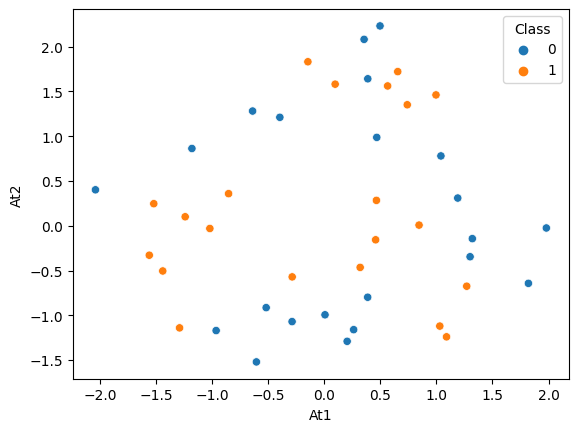

bouldin_3NN_banana_0.02.csv


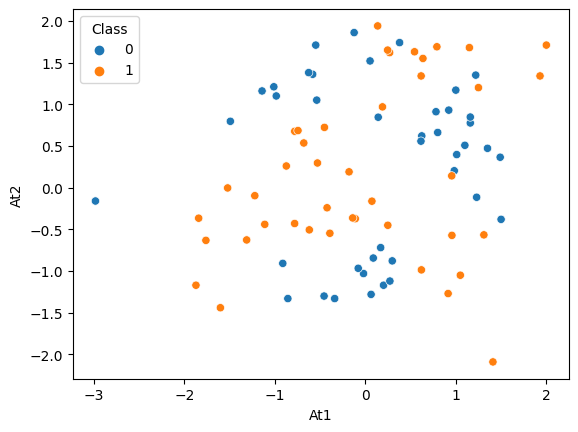

bouldin_3NN_banana_0.05.csv


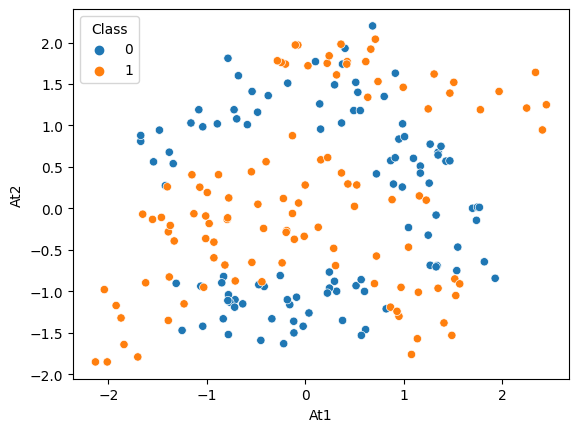

bouldin_3NN_banana_0.1.csv


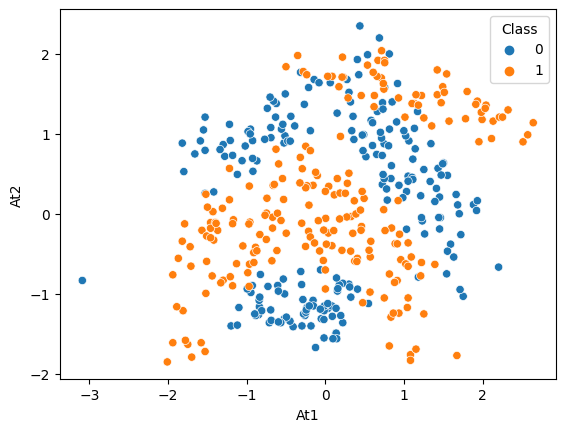

bouldin_3NN_banana_0.2.csv


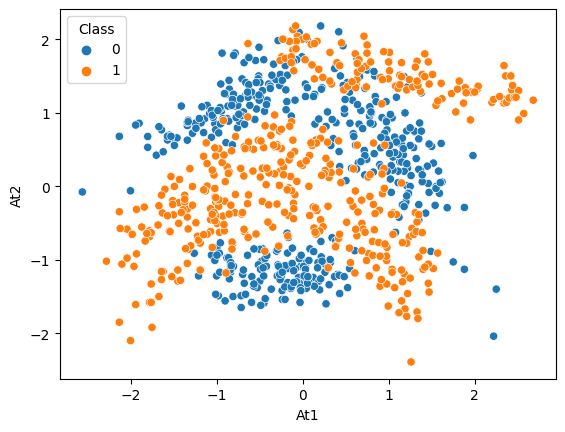

bouldin_3NN_banana_0.3.csv


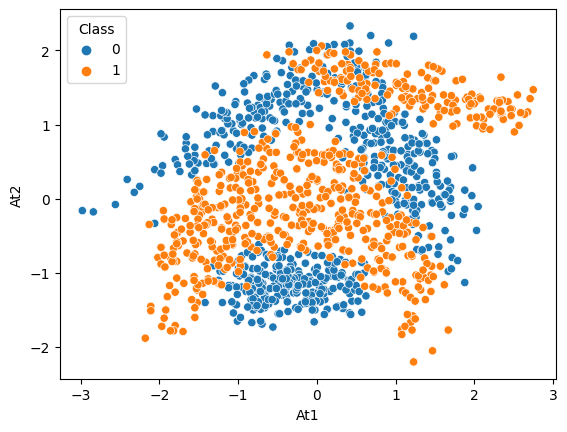

bouldin_3NN_banana_0.4.csv


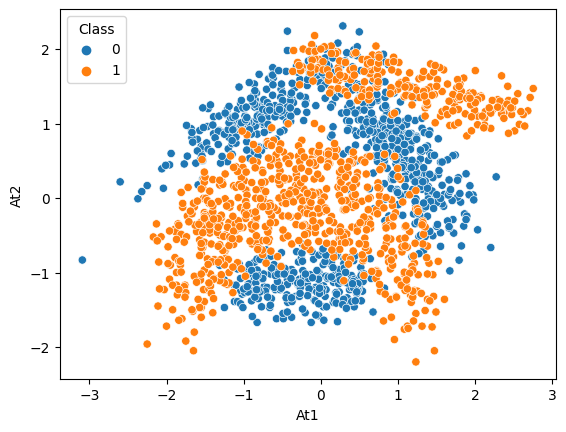

bouldin_3NN_banana_0.5.csv


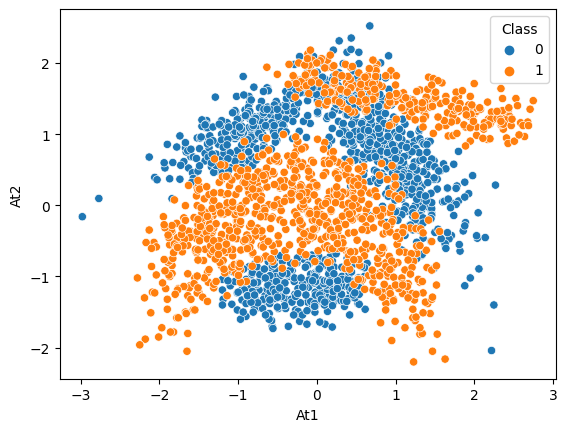

bouldin_tree_banana_0.01.csv


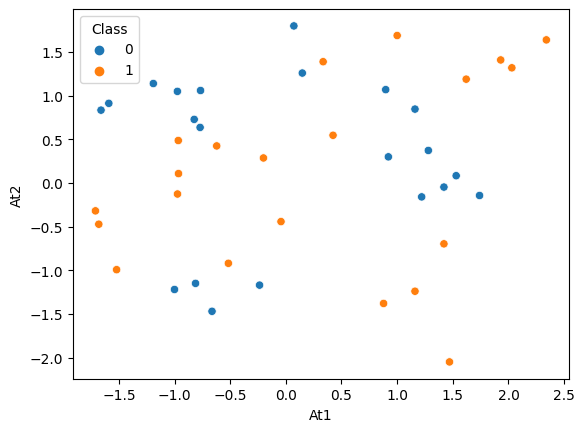

bouldin_tree_banana_0.02.csv


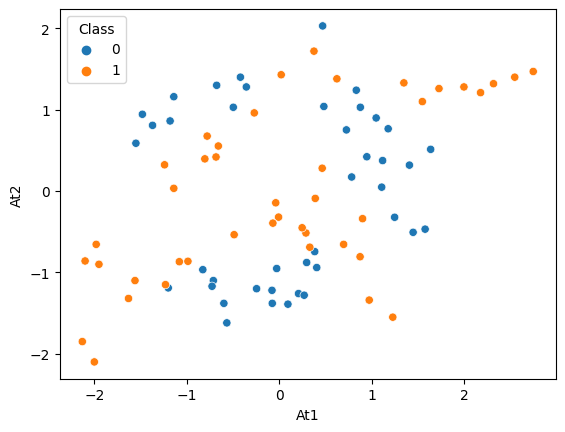

bouldin_tree_banana_0.05.csv


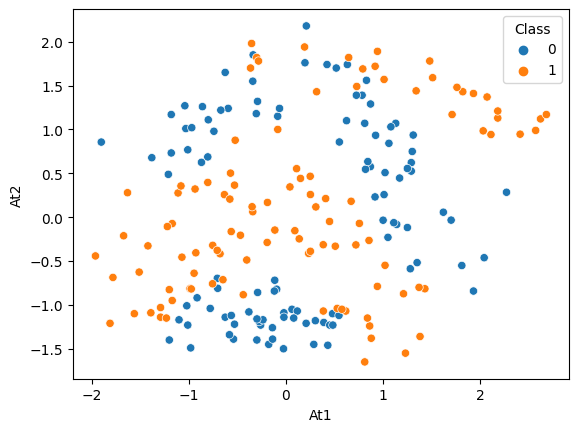

bouldin_tree_banana_0.1.csv


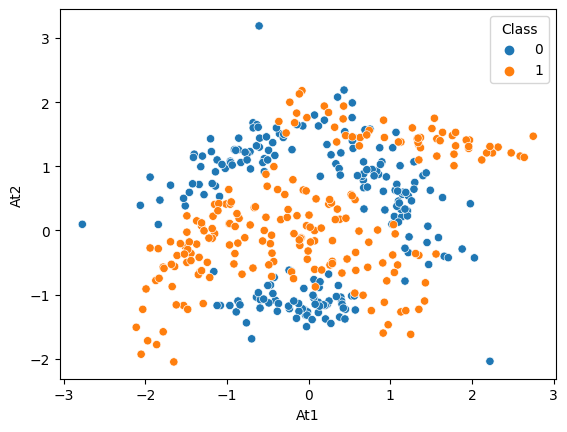

bouldin_tree_banana_0.2.csv


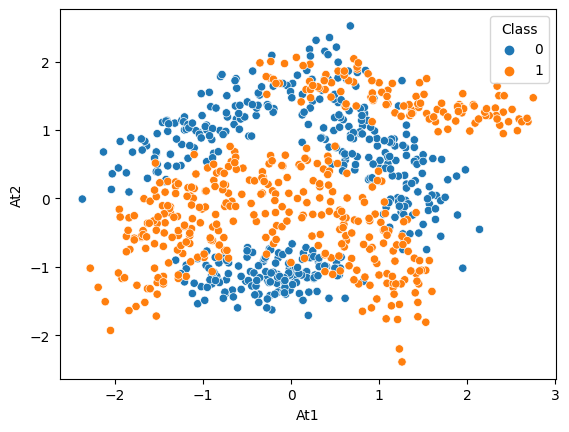

bouldin_tree_banana_0.3.csv


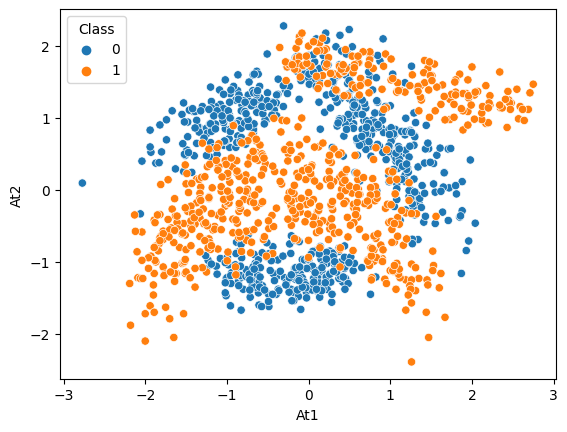

bouldin_tree_banana_0.4.csv


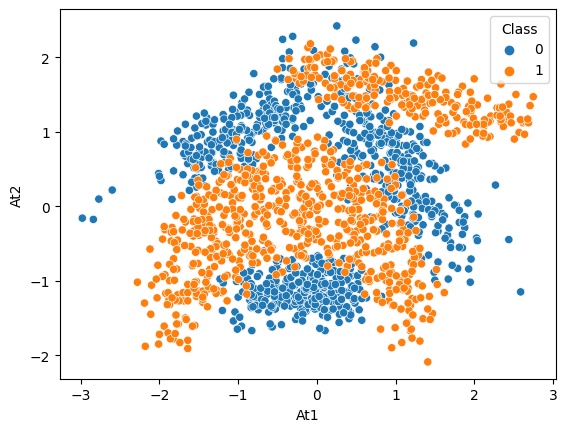

bouldin_tree_banana_0.5.csv


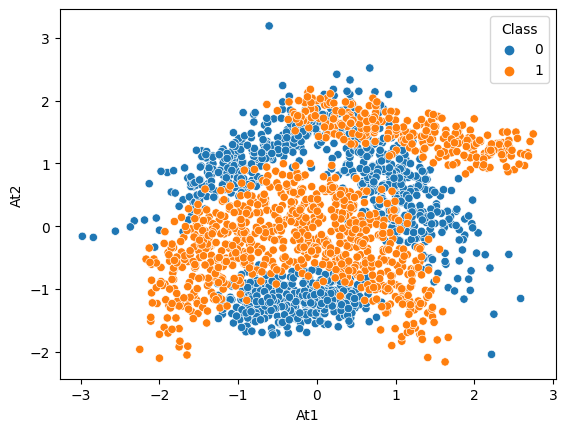

clustercentroids_banana_0.01.csv


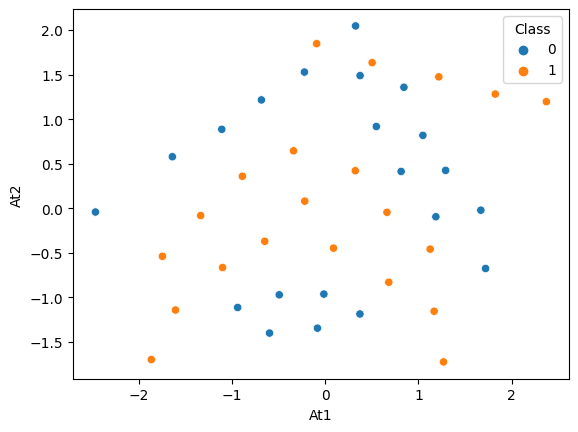

clustercentroids_banana_0.02.csv


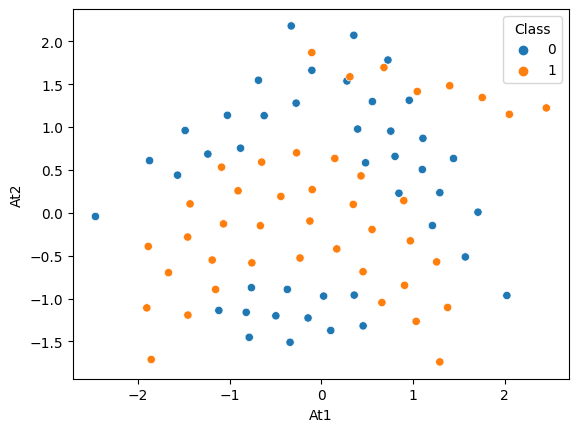

clustercentroids_banana_0.05.csv


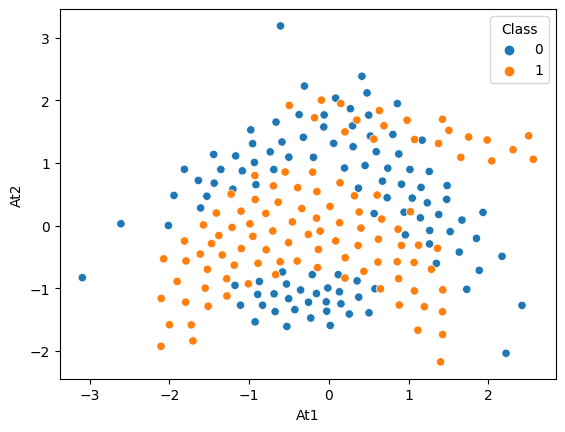

clustercentroids_banana_0.1.csv


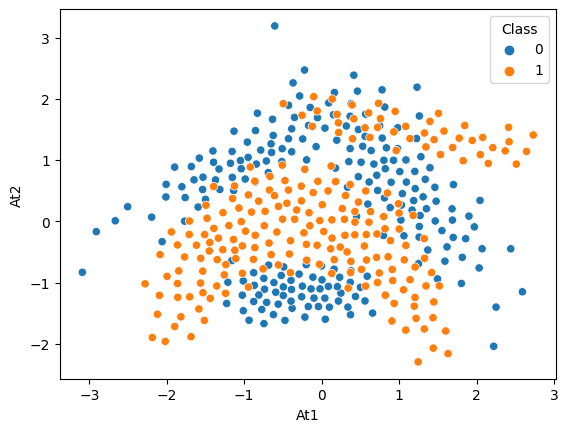

clustercentroids_banana_0.2.csv


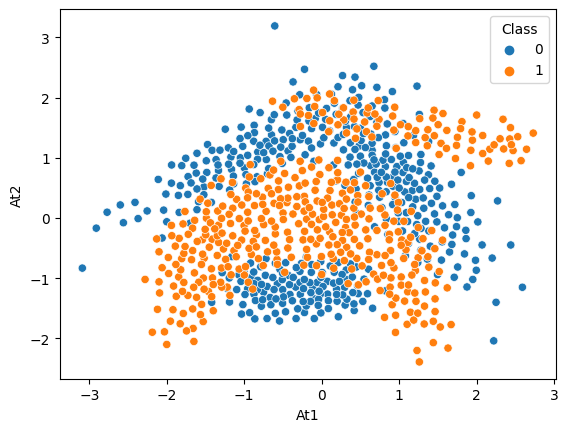

clustercentroids_banana_0.3.csv


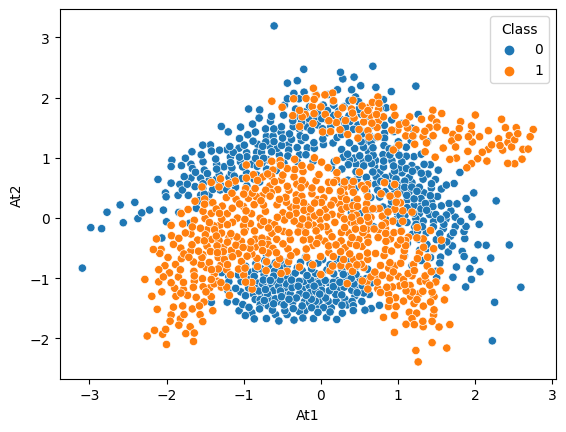

clustercentroids_banana_0.4.csv


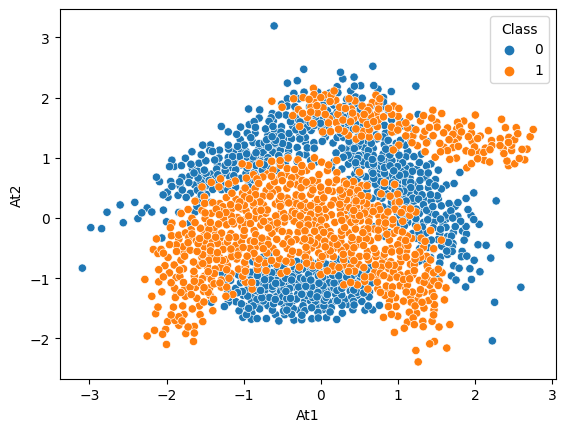

clustercentroids_banana_0.5.csv


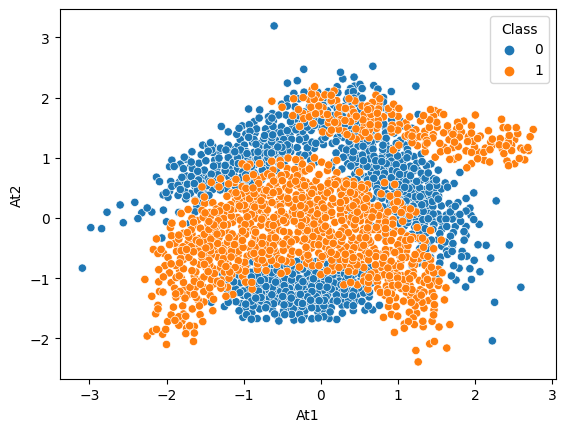

nearmiss1_banana_0.01.csv


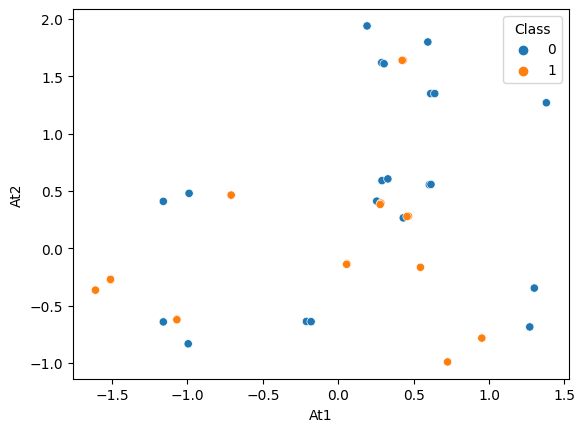

nearmiss1_banana_0.02.csv


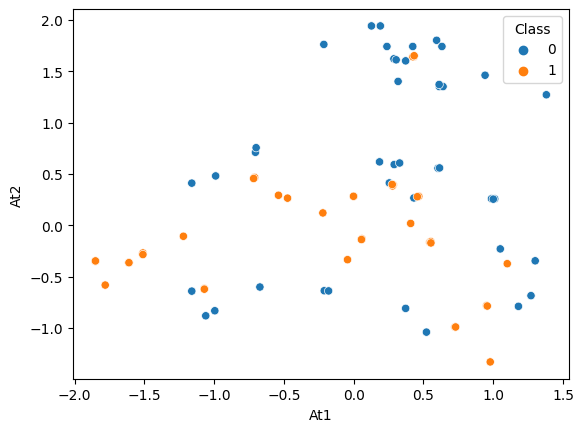

nearmiss1_banana_0.05.csv


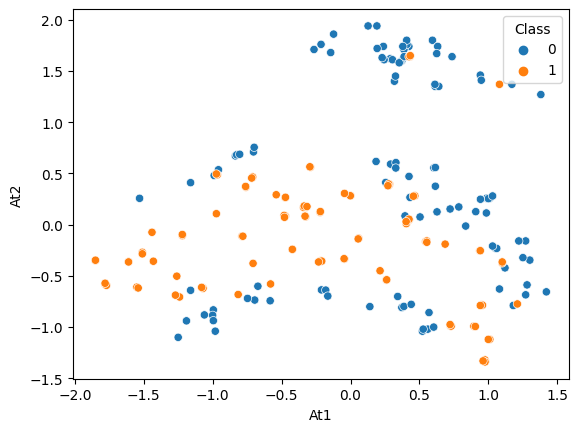

nearmiss1_banana_0.1.csv


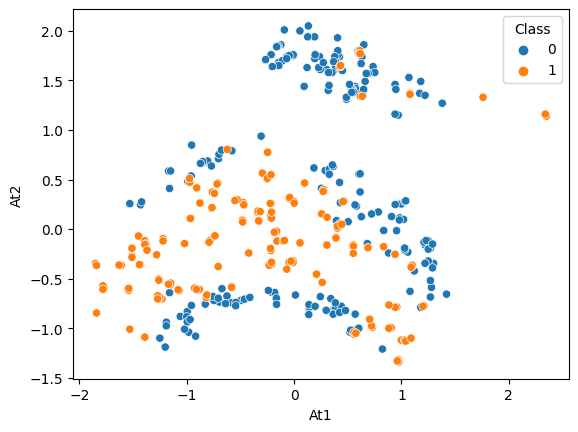

nearmiss1_banana_0.2.csv


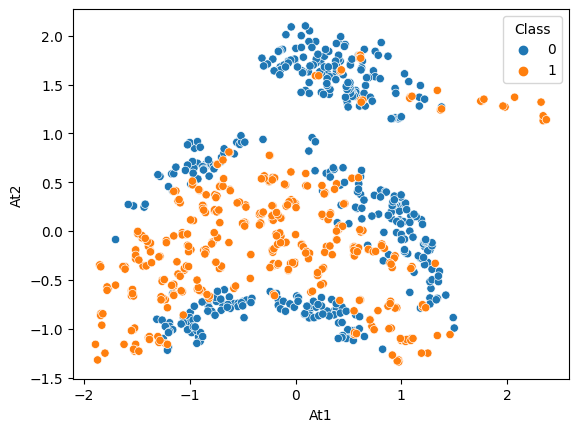

nearmiss1_banana_0.3.csv


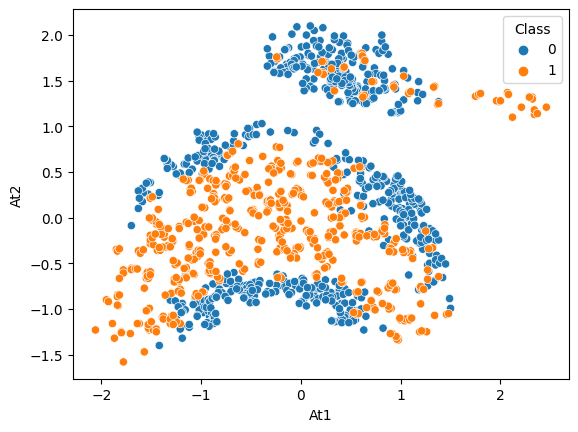

nearmiss1_banana_0.4.csv


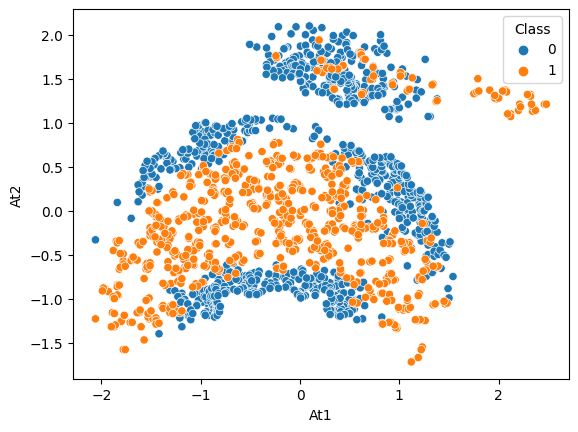

nearmiss1_banana_0.5.csv


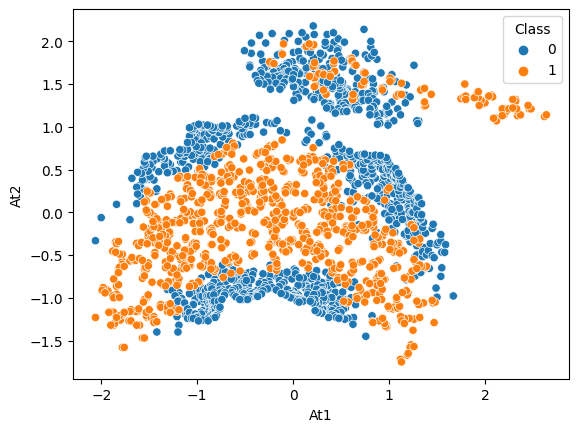

nearmiss2_banana_0.01.csv


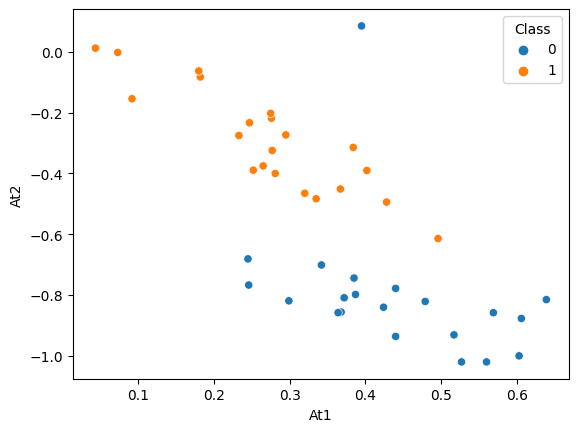

nearmiss2_banana_0.02.csv


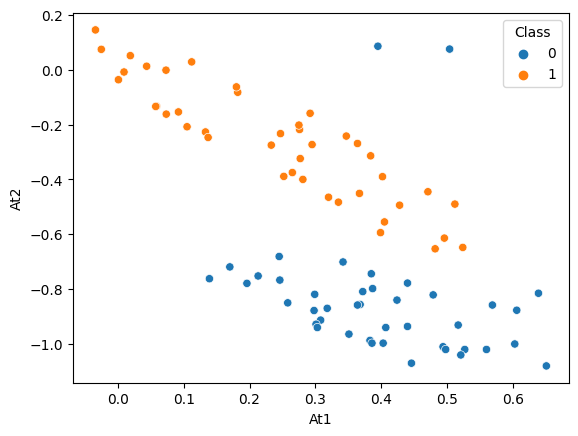

nearmiss2_banana_0.05.csv


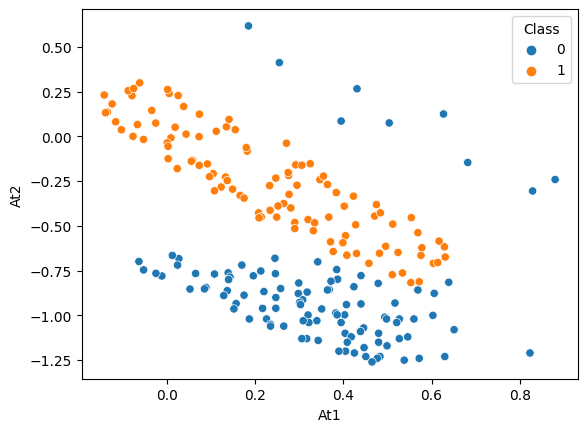

nearmiss2_banana_0.1.csv


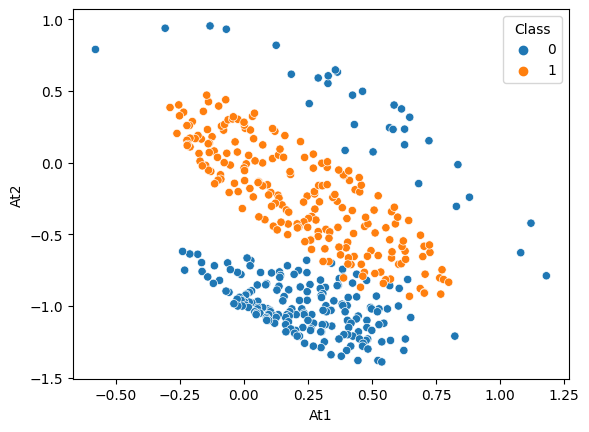

nearmiss2_banana_0.2.csv


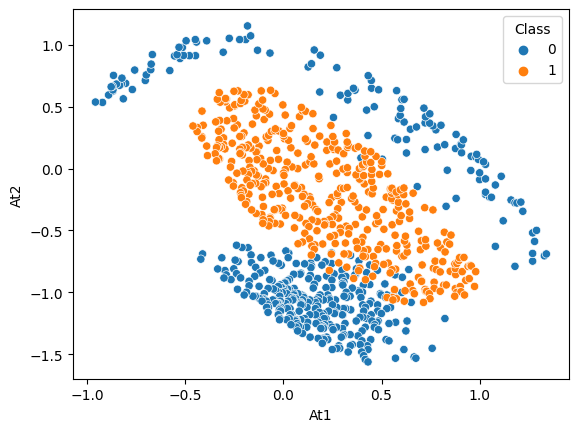

nearmiss2_banana_0.3.csv


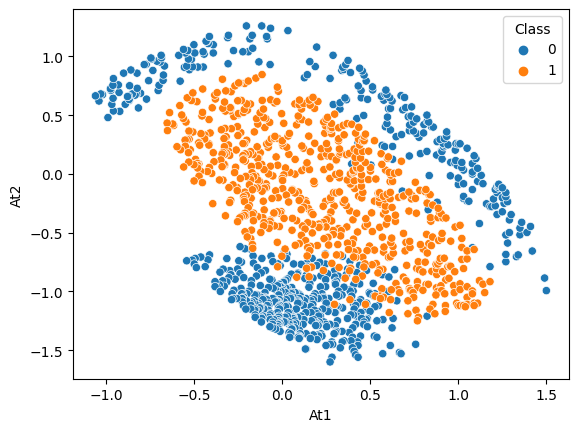

nearmiss2_banana_0.4.csv


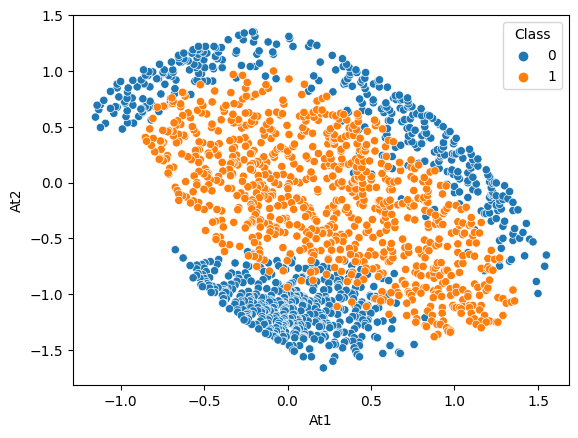

nearmiss2_banana_0.5.csv


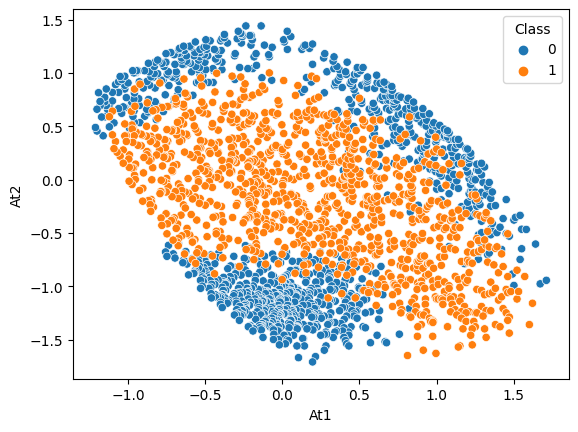

nearmiss3_banana_0.01.csv


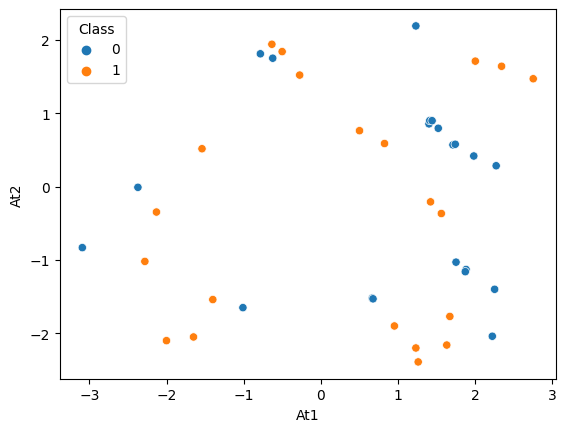

nearmiss3_banana_0.02.csv


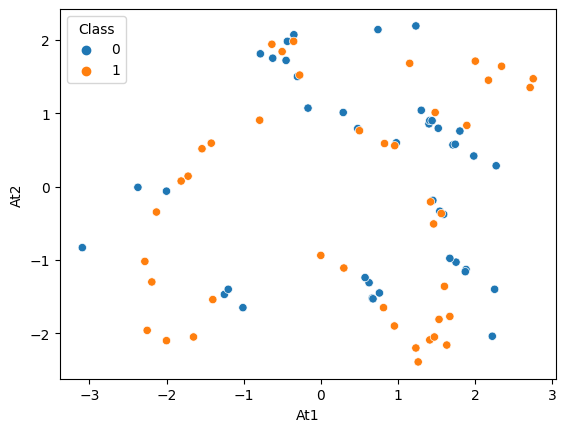

nearmiss3_banana_0.05.csv


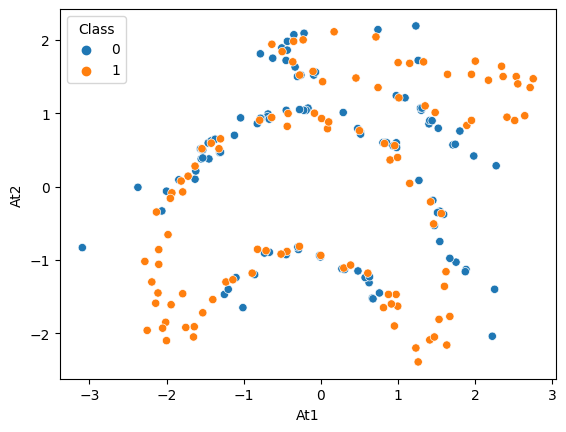

nearmiss3_banana_0.1.csv


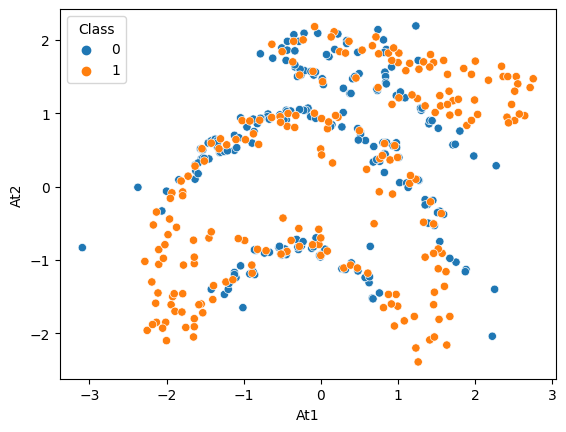

nearmiss3_banana_0.2.csv


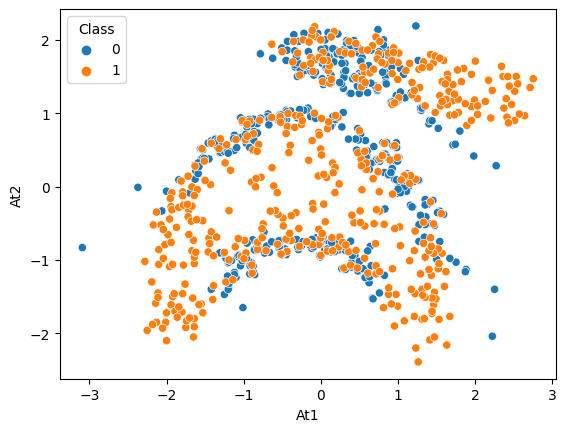

nearmiss3_banana_0.3.csv


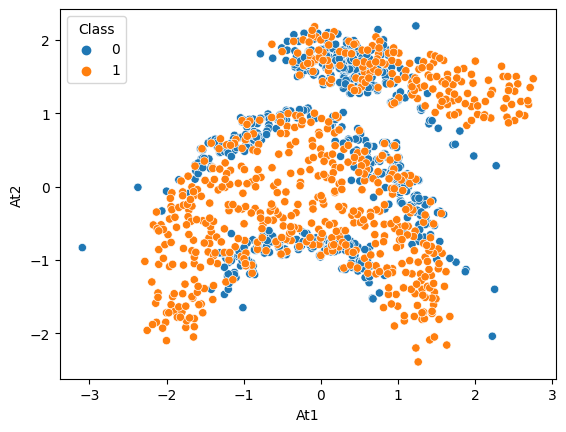

nearmiss3_banana_0.4.csv


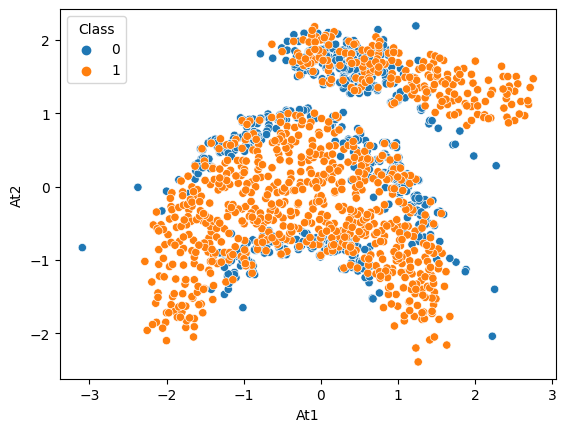

nearmiss3_banana_0.5.csv


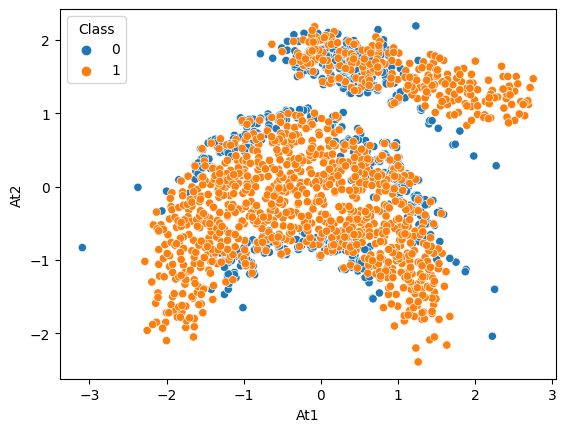

old_banana_0.0.csv


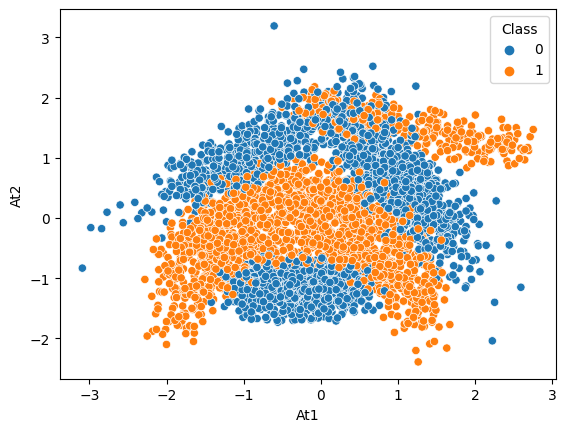

randomsampler_banana_0.01.csv


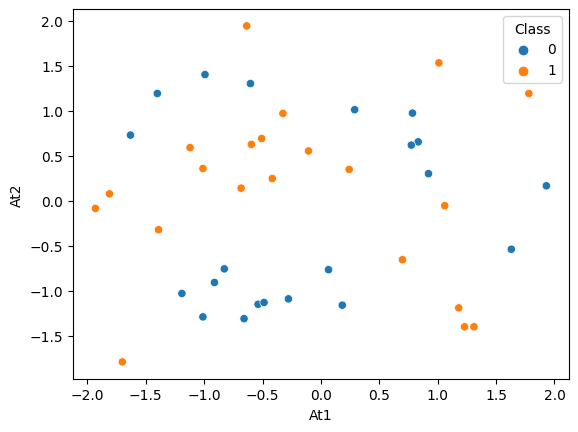

randomsampler_banana_0.02.csv


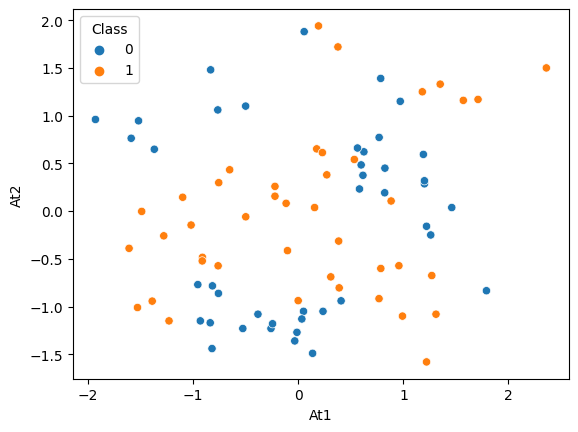

randomsampler_banana_0.05.csv


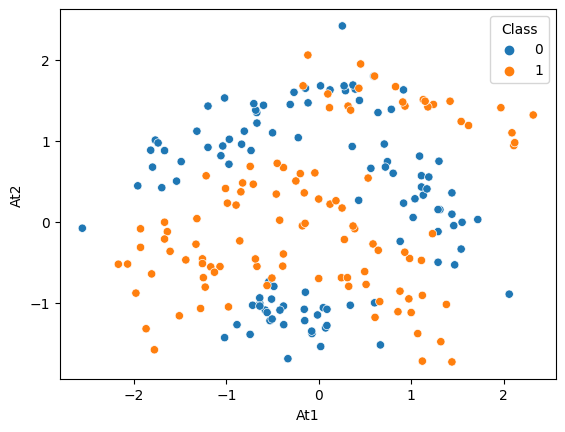

randomsampler_banana_0.1.csv


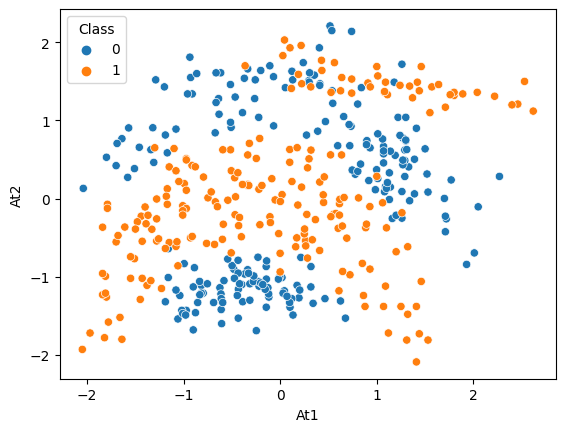

randomsampler_banana_0.2.csv


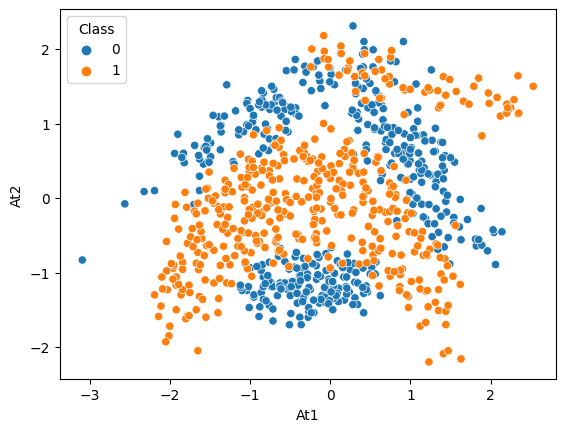

randomsampler_banana_0.3.csv


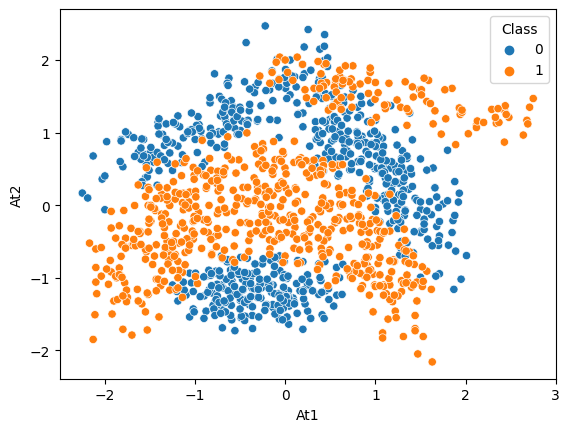

randomsampler_banana_0.4.csv


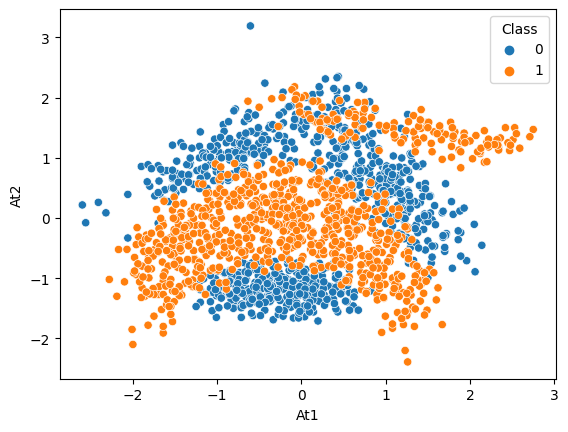

randomsampler_banana_0.5.csv


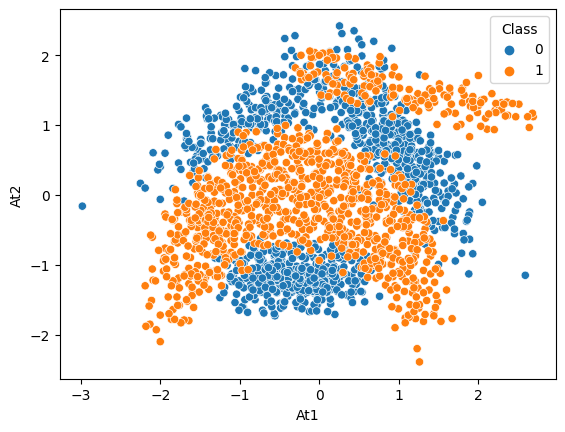

<Axes: xlabel='At1', ylabel='At2'>

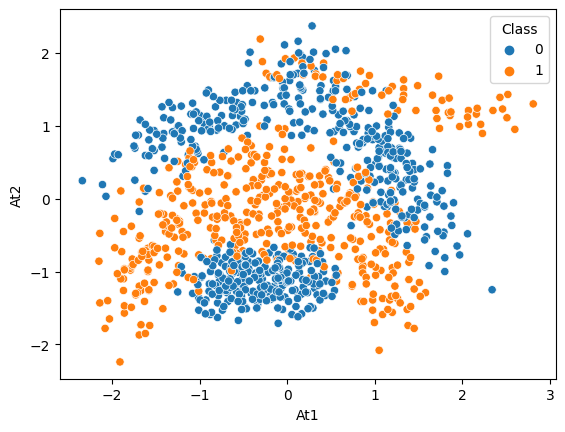

In [21]:
train_files=datasets["banana"]["train"]
test_file="test_ring.csv"
train_files.sort()

features=["At1","At2"]
for train_file in train_files:
    csv_data= pd.read_csv(f'{reduced_data_dir}/{train_file}')
    sns.scatterplot(data=csv_data, x=features[0], y=features[1], hue="Class")
    print(train_file)
    plt.show()

test_df = pd.read_csv(f'{reduced_data_dir}/{datasets["banana"]["test"]}')
sns.scatterplot(data=test_df, x=features[0], y=features[1], hue="Class")
# y_test=test_df["Class"]
# X_test=test_df.drop("Class",axis=1)
# X_test=X_test[features]
# pca=PCA(n_components=2)
#X_test=pca.fit_transform(X_test)



In [25]:

for data in train_dfs.values():
    
    knn=KNeighborsClassifier(n_neighbors=3)#KNeighborsClassifier(n_neighbors=3)#DecisionTreeClassifier(random_state=0)##KNeighborsClassifier(n_neighbors=3)#MLPClassifier(random_state=1, max_iter=300)#RandomForestClassifier(max_depth=2, random_state=0)#DecisionTreeClassifier(random_state=0)#
    # print(data)
    y_train=data["Class"]
    X_train=data.drop("Class",axis=1)
    #X_train=pca.transform(X_train)
    X_train=X_train[features]
    #print(X_train,y_train)
    # plot_data=pd.concat([pd.DataFrame(X_train),y_train],axis=1)
    # print(plot_data)
    # sns.scatterplot(data=plot_data, x=0, y=1, hue="Class")
    # plt.show()
    # Create an explainer object
   

    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    print(classification_report(y_test,y_pred))
    # explainer = shap.Explainer(knn.predict, X_train)

    # # Calculate SHAP values for your dataset
    # shap_values = explainer(X_train)

    # shap.summary_plot(shap_values, X_train)

    misclassified_indices = y_pred != y_test
    misclassified_X = X_test[misclassified_indices]
    misclassified_y_pred = y_pred[misclassified_indices]
    misclassified_y_actual = y_test[misclassified_indices]

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       706
           1       0.67      0.72      0.70       774

    accuracy                           0.67      1480
   macro avg       0.67      0.67      0.67      1480
weighted avg       0.67      0.67      0.67      1480

              precision    recall  f1-score   support

           0       0.59      0.76      0.67       706
           1       0.71      0.53      0.60       774

    accuracy                           0.64      1480
   macro avg       0.65      0.64      0.64      1480
weighted avg       0.65      0.64      0.63      1480



VISUALIZATION of accuracy with different models

In [321]:
new_format=data_to_visualize

# filter dataframe

new_format.RED=pd.to_numeric(new_format.RED)
new_format = new_format[(new_format['RED'] < 0.02) | (new_format['RED'] >0.04)]

# use lambda to modify series
new_format['RED'] = new_format['RED'].apply(lambda x: 1-x if x != 0 else 0)

print(new_format)

      Dataset   RED                  Method       ACC Model
0      banana  0.50  grouped_1NN_class_sens  0.841509    DT
1      banana  0.50  grouped_1NN_class_sens  0.877358    RF
2      banana  0.50  grouped_1NN_class_sens  0.885849    NN
3      banana  0.50  grouped_1NN_class_sens  0.874528   KNN
4      banana  0.80  grouped_1NN_class_sens  0.847170    DT
...       ...   ...                     ...       ...   ...
1733  phoneme  0.70               nearmiss2  0.695652   KNN
1734  phoneme  0.99               nearmiss2  0.621647    DT
1735  phoneme  0.99               nearmiss2  0.729880    RF
1736  phoneme  0.99               nearmiss2  0.729880    NN
1737  phoneme  0.99               nearmiss2  0.694727   KNN

[1550 rows x 5 columns]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [229]:
print(new_format.to_string())

    Dataset   RED            Method       ACC Model
0    banana  0.50           grouped  0.645283    DT
1    banana  0.50           grouped  0.731132    RF
2    banana  0.50           grouped  0.755660    NN
3    banana  0.50           grouped  0.692453   KNN
4    banana  0.80           grouped  0.490566    DT
5    banana  0.80           grouped  0.459434    RF
6    banana  0.80           grouped  0.484906    NN
7    banana  0.80           grouped  0.447170   KNN
8    banana  0.90       bouldin_3NN  0.842453    DT
9    banana  0.90       bouldin_3NN  0.851887    RF
10   banana  0.90       bouldin_3NN  0.768868    NN
11   banana  0.90       bouldin_3NN  0.858491   KNN
12   banana  0.70         nearmiss2  0.733962    DT
13   banana  0.70         nearmiss2  0.711321    RF
14   banana  0.70         nearmiss2  0.716038    NN
15   banana  0.70         nearmiss2  0.750943   KNN
16   banana  0.90  clustercentroids  0.850943    DT
17   banana  0.90  clustercentroids  0.857547    RF
18   banana 

['DT' 'RF' 'NN' 'KNN']
Method   RED  bouldin_3NN  clustercentroids  grouped_1NN_class_sens   
0       0.00     0.855660          0.855660                0.855660  \
1       0.50     0.857547          0.833962                0.841509   
2       0.60     0.860377          0.851887                0.869811   
3       0.70     0.855660          0.849057                0.844340   
4       0.80     0.847170          0.842453                0.847170   
5       0.90     0.842453          0.850943                0.802830   
6       0.95     0.831132          0.862264                0.772642   
7       0.99     0.778302          0.754717                     NaN   

Method  nearmiss1  nearmiss2  nearmiss3  randomsampler  
0        0.855660   0.855660   0.855660       0.855660  
1        0.850000   0.743396   0.829245       0.854717  
2        0.863208   0.734906   0.764151       0.850000  
3        0.850000   0.733962   0.791509       0.865094  
4        0.845283   0.678302   0.778302       0.8547

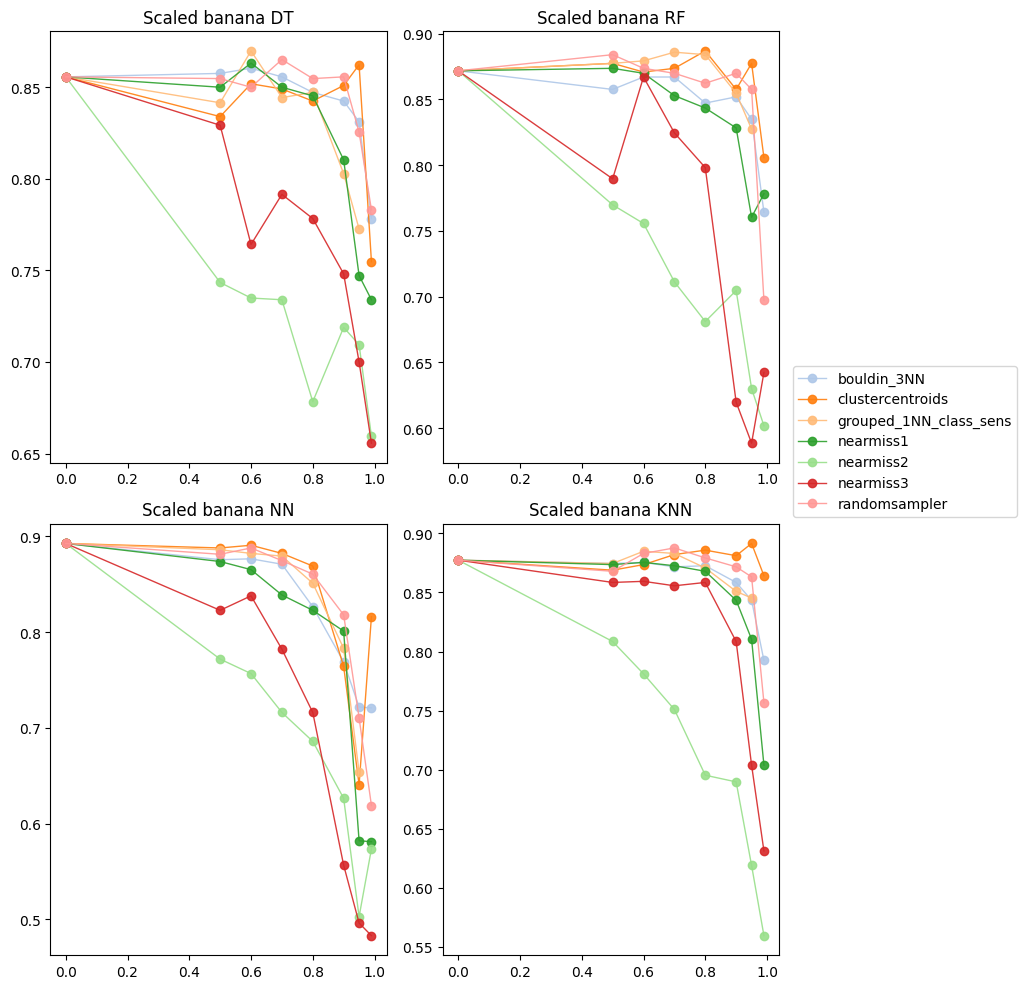

Method   RED  bouldin_3NN  clustercentroids  grouped_1NN_class_sens   
0       0.00     0.623188          0.623188                0.623188  \
1       0.50     0.666667          0.608696                0.623188   
2       0.60     0.550725          0.594203                0.550725   
3       0.70     0.695652          0.637681                0.536232   
4       0.80     0.449275          0.478261                0.579710   
5       0.90     0.420290          0.623188                0.420290   
6       0.95     0.565217          0.579710                0.521739   
7       0.99          NaN          0.565217                     NaN   

Method  nearmiss1  nearmiss2  nearmiss3  randomsampler  
0        0.623188   0.623188   0.623188       0.623188  
1        0.681159   0.478261   0.550725       0.637681  
2        0.623188   0.550725   0.536232       0.681159  
3        0.637681   0.536232   0.550725       0.507246  
4        0.681159   0.492754   0.521739       0.608696  
5        0.666667 

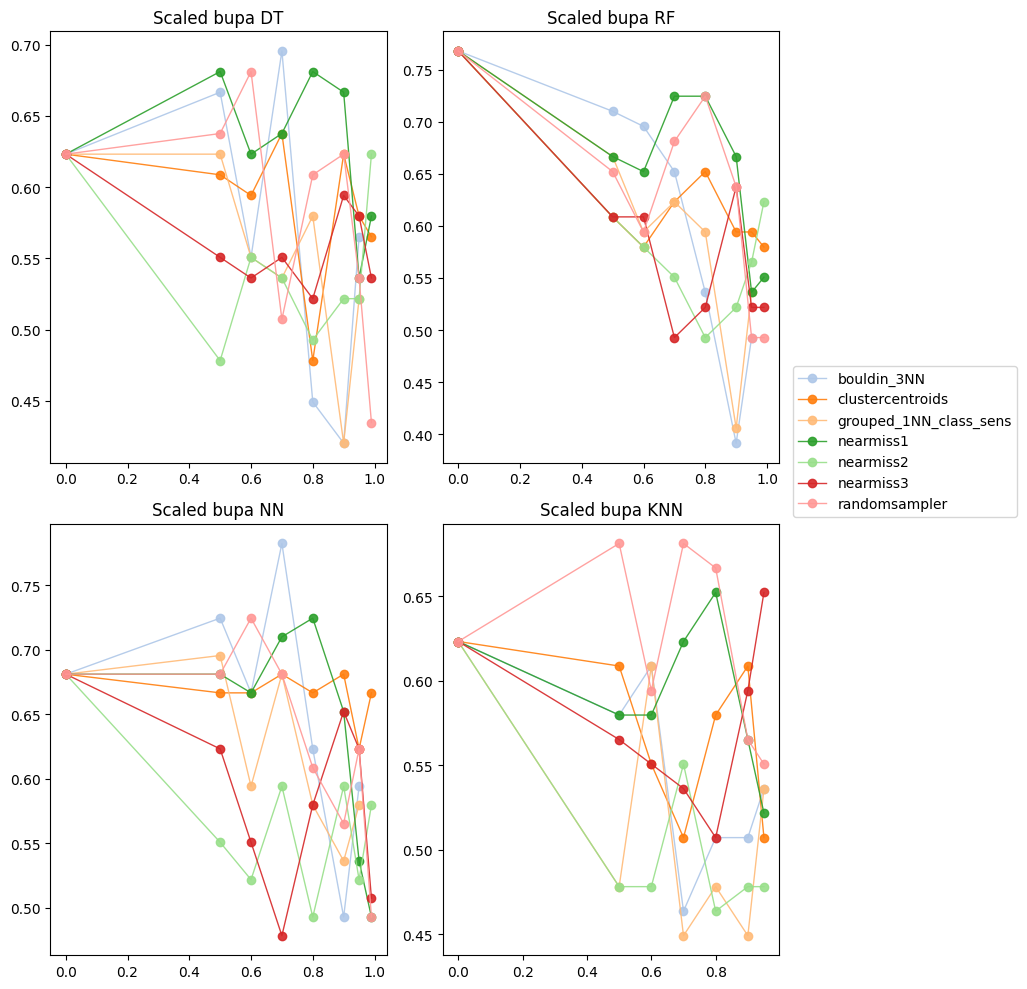

Method   RED  bouldin_3NN  clustercentroids  grouped_1NN_class_sens   
0       0.00     0.817823          0.817823                0.817823  \
1       0.50     0.771293          0.822029                0.782072   
2       0.60     0.767613          0.842008                0.785752   
3       0.70     0.776025          0.839642                0.832545   
4       0.80     0.752892          0.860410                0.851209   
5       0.90     0.740799          0.861462                0.823870   
6       0.95     0.746845          0.840694                0.818349   
7       0.99     0.735804          0.830442                     NaN   

Method  nearmiss1  nearmiss2  nearmiss3  randomsampler  
0        0.817823   0.817823   0.817823       0.817823  
1        0.615405   0.482650   0.874080       0.780757  
2        0.588328   0.403785   0.898265       0.801525  
3        0.579127   0.460042   0.957676       0.774974  
4        0.563880   0.531020   0.967928       0.768665  
5        0.633281 

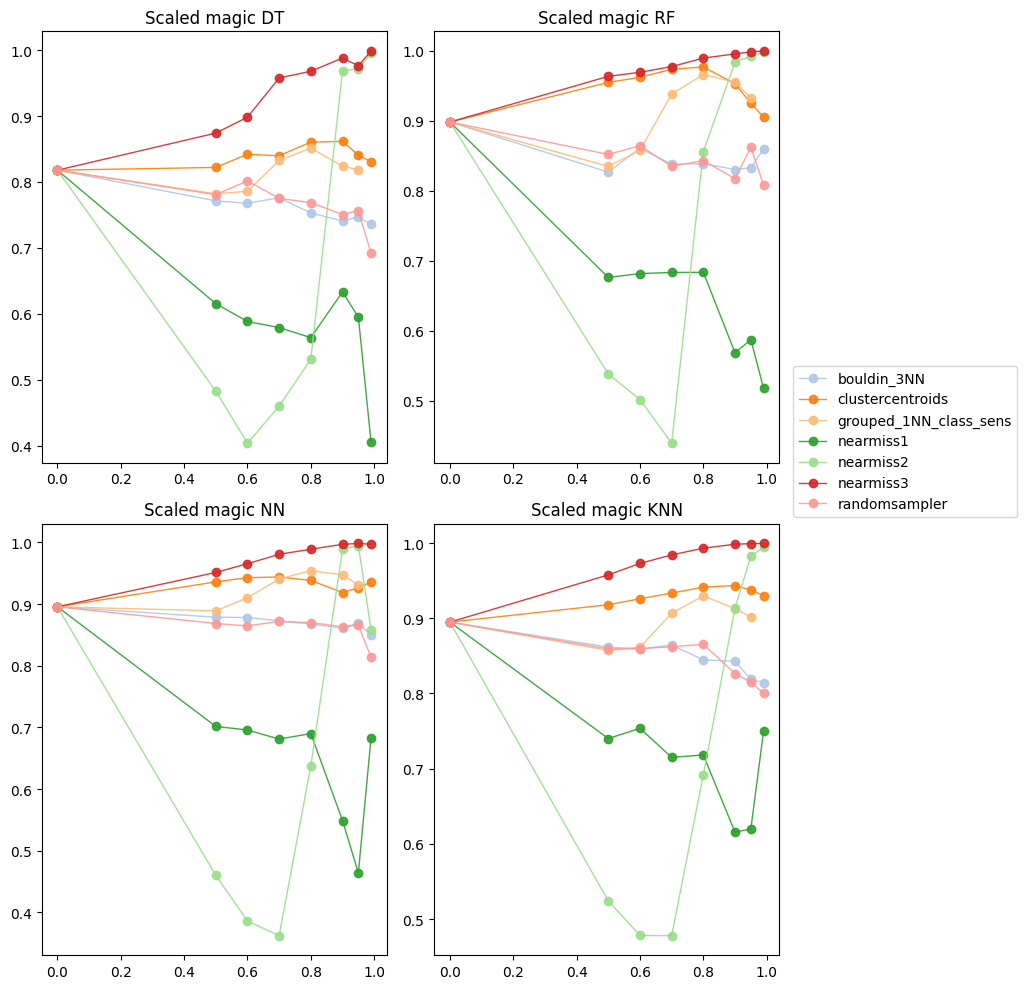

Method   RED  bouldin_3NN  clustercentroids  grouped_1NN_class_sens   
0       0.00          1.0          1.000000                1.000000  \
1       0.50          1.0          1.000000                1.000000   
2       0.60          1.0          1.000000                1.000000   
3       0.70          1.0          1.000000                1.000000   
4       0.80          1.0          1.000000                1.000000   
5       0.90          1.0          1.000000                1.000000   
6       0.95          1.0          1.000000                0.988506   
7       0.99          NaN          0.747126                     NaN   

Method  nearmiss1  nearmiss2  nearmiss3  randomsampler  
0        1.000000   1.000000   1.000000       1.000000  
1        1.000000   1.000000   1.000000       1.000000  
2        1.000000   1.000000   1.000000       1.000000  
3        1.000000   1.000000   1.000000       1.000000  
4        1.000000   1.000000   0.724138       1.000000  
5        1.000000 

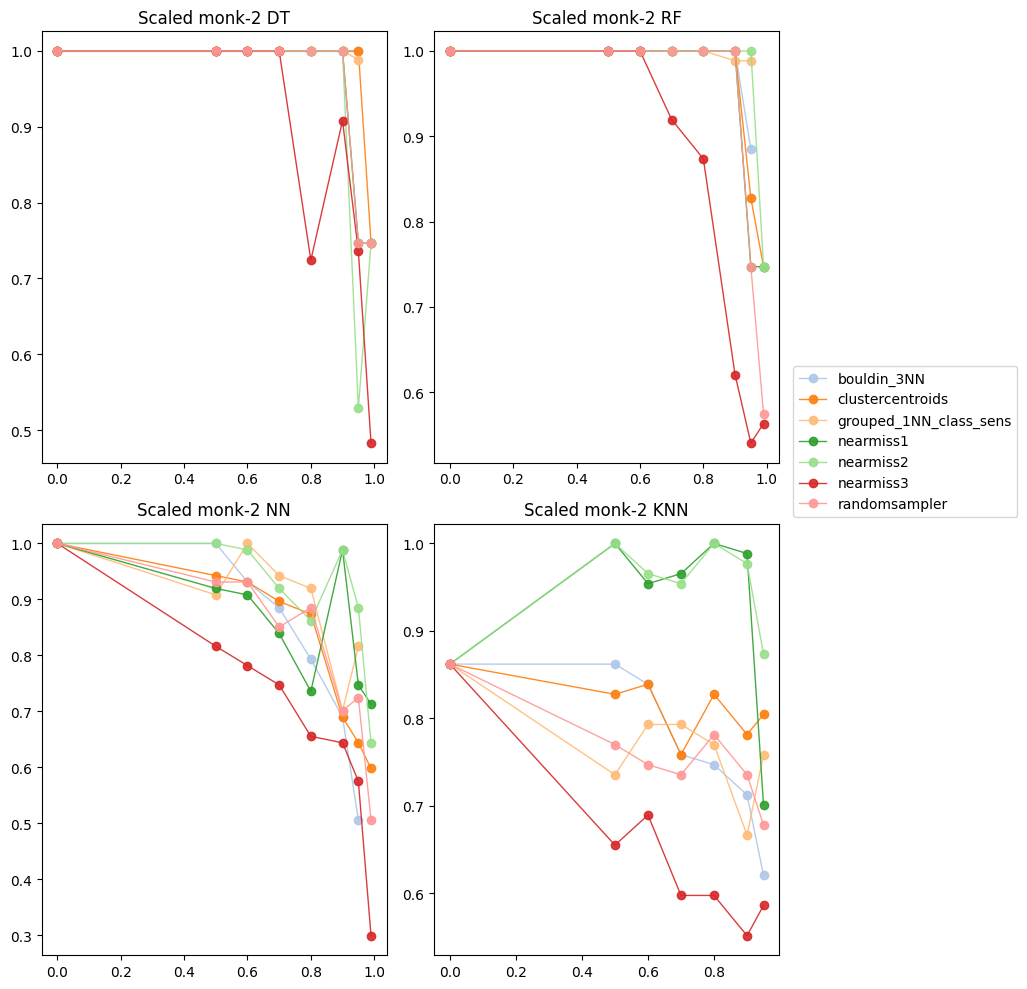

Method   RED  bouldin_3NN  clustercentroids  grouped_1NN_class_sens   
0       0.00     0.629870          0.629870                0.629870  \
1       0.50     0.623377          0.662338                0.740260   
2       0.60     0.668831          0.623377                0.668831   
3       0.70     0.688312          0.584416                0.636364   
4       0.80     0.707792          0.740260                0.610390   
5       0.90     0.636364          0.623377                0.558442   
6       0.95     0.616883          0.740260                0.564935   
7       0.99     0.597403          0.759740                     NaN   

Method  nearmiss1  nearmiss2  nearmiss3  randomsampler  
0        0.629870   0.629870   0.629870       0.629870  
1        0.571429   0.623377   0.681818       0.675325  
2        0.610390   0.616883   0.668831       0.720779  
3        0.616883   0.707792   0.636364       0.727273  
4        0.675325   0.694805   0.649351       0.681818  
5        0.597403 

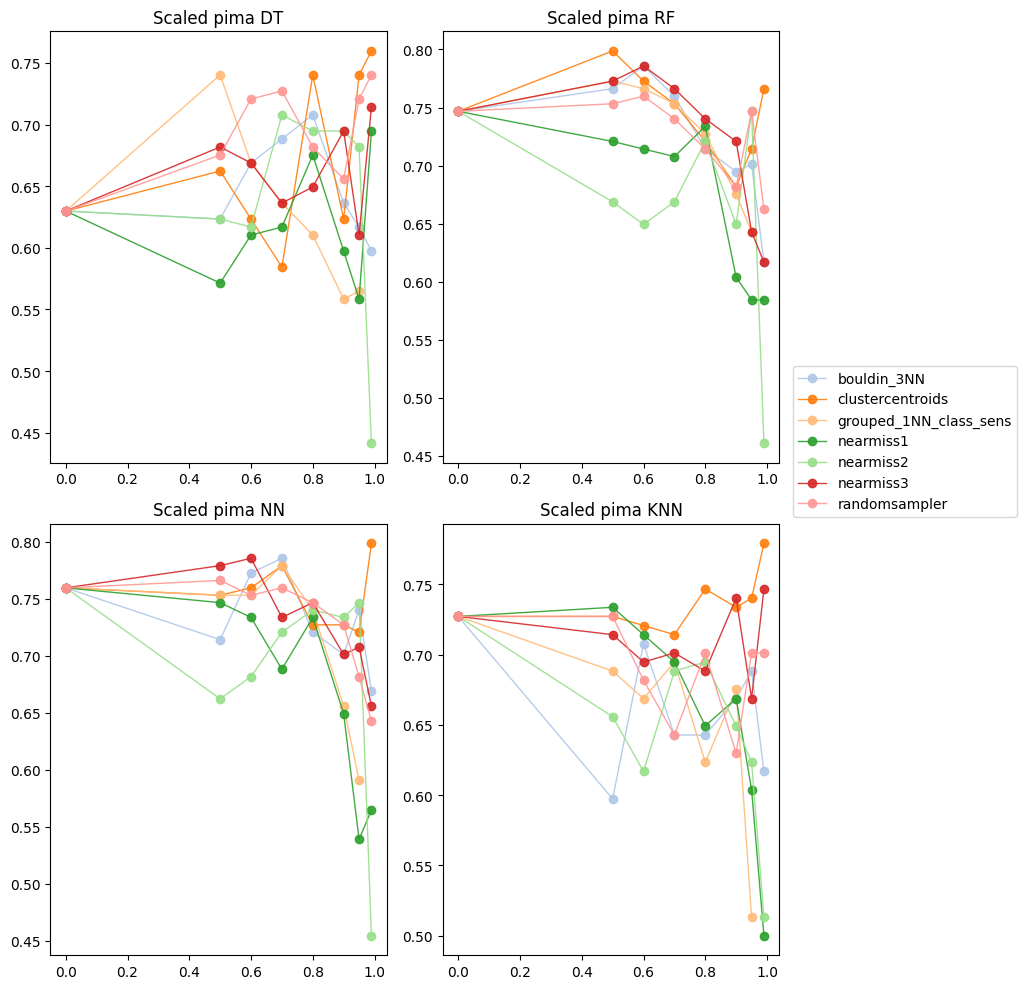

Method   RED  bouldin_knn  clustercentroids  grouped_1NN_class_sens   
0       0.00     0.884459          0.884459                0.884459  \
1       0.50     0.862838          0.835811                0.867568   
2       0.60     0.858784          0.837838                0.867568   
3       0.70     0.827027          0.793919                0.862838   
4       0.80     0.824324          0.781081                0.870270   
5       0.90     0.804730          0.708784                0.802027   
6       0.95     0.743919          0.687838                0.833108   
7       0.99     0.700676          0.600000                     NaN   

Method  nearmiss1  nearmiss2  nearmiss3  randomsampler  
0        0.884459   0.884459   0.884459       0.884459  
1        0.836486   0.809459   0.880405       0.862162  
2        0.820946   0.807432   0.835811       0.843919  
3        0.815541   0.775000   0.849324       0.820270  
4        0.797973   0.781081   0.844595       0.839189  
5        0.775676 

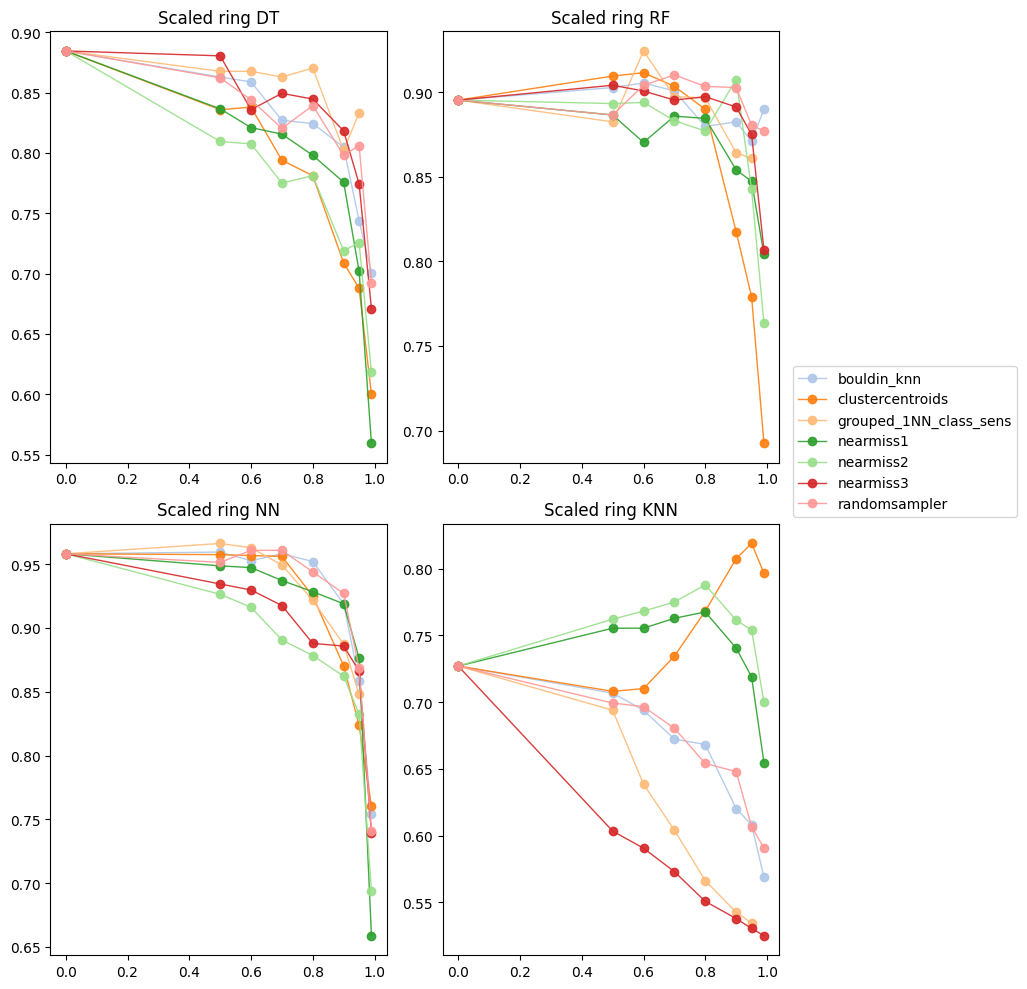

Method   RED  bouldin_3NN  clustercentroids  grouped_1NN_class_sens   
0       0.00     0.836486          0.836486                0.836486  \
1       0.50     0.826351          0.826351                0.829730   
2       0.60     0.829054          0.835135                0.799324   
3       0.70     0.829054          0.821622                0.808108   
4       0.80     0.832432          0.795946                0.812838   
5       0.90     0.796622          0.791892                0.822973   
6       0.95     0.795946          0.783784                0.783108   
7       0.99     0.728378          0.689865                     NaN   

Method  nearmiss1  nearmiss2  nearmiss3  randomsampler  
0        0.836486   0.836486   0.836486       0.836486  
1        0.834459   0.835135   0.829054       0.835811  
2        0.820946   0.828378   0.827027       0.828378  
3        0.806081   0.806757   0.817568       0.842568  
4        0.814189   0.798649   0.797297       0.810135  
5        0.767568 

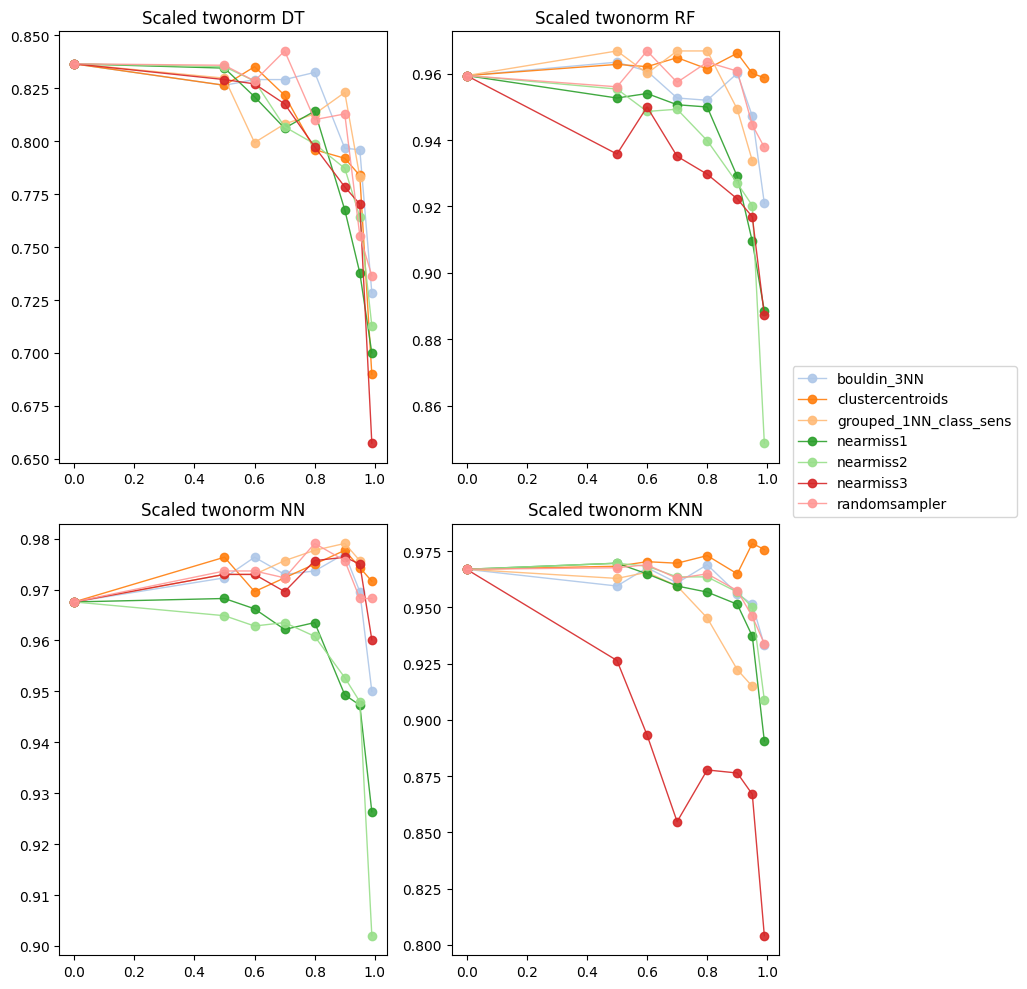

Method   RED  bouldin_3NN  clustercentroids  grouped_1NN_class_sens   
0       0.00     0.878816          0.878816                0.878816  \
1       0.50     0.844588          0.824237                0.839963   
2       0.60     0.802960          0.830712                0.833488   
3       0.70     0.798335          0.802035                0.817761   
4       0.80     0.800185          0.775208                0.793710   
5       0.90     0.766883          0.764107                0.761332   
6       0.95     0.740056          0.745606                0.696577   
7       0.99     0.680851          0.689177                     NaN   

Method  nearmiss1  nearmiss2  nearmiss3  randomsampler  
0        0.878816   0.878816   0.878816       0.878816  
1        0.800185   0.668825   0.738205       0.837188  
2        0.775208   0.658649   0.704903       0.837188  
3        0.641073   0.595745   0.763182       0.812211  
4        0.603145   0.614246   0.733580       0.802960  
5        0.646623 

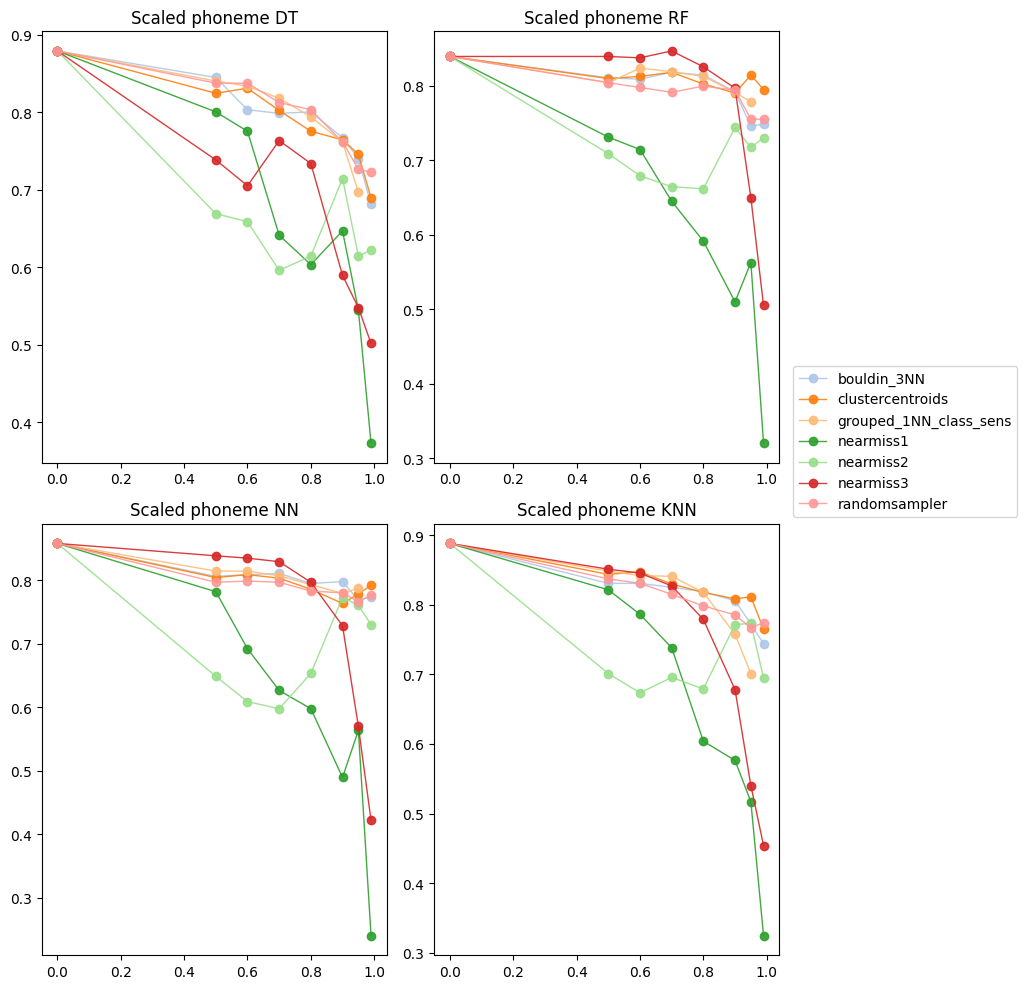

In [322]:
#plt.style.use('seaborn-darkgrid')
# plt.title("Acc",fontsize=15)  
# plt.xlabel("Poměr redukce")
# plt.ylabel("Hodnota metriky")

#plt.xscale('log')


# Create a color palette
palette = plt.get_cmap('tab20')
input_files=["banana","bupa", "magic" ,"monk-2" ,"pima" ,"ring" ,"twonorm" ,"phoneme"]
# input_files=["bupa", "magic" ,"monk-2" ,"pima" ,"ring" ,"twonorm" ,"phoneme"]
models=new_format["Model"].unique()
print(models)
for file in input_files:
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(8, 10))
    for model,index in zip(models,pd.MultiIndex.from_product([[0,1],[0,1]]).to_list()):
        
        plot_data=new_format[new_format["Dataset"]==file]
        plot_data=plot_data[plot_data["Model"]==model].drop(columns=["Model"])
        #print(plot_data)
        plot_data=plot_data.pivot(columns='Method',index='RED',values="ACC").reset_index()
        #print(plot_data)
        #plot_data.fillna(plot_data['old'][0],inplace=True)
        names=plot_data.drop("RED", axis=1).columns
        plot_data.loc[0,names] = plot_data['old'][0]
        plot_data.pop("old")
        #plot_data=plot_data.sort_values(by=["RED"])
        print(plot_data)
        num=0
        
        for column in plot_data.drop('RED', axis=1):
            num+=1
            #axes[index[0]][index[1]]
            fin_data=plot_data[plot_data[column].notnull()]
            #print(fin_data)
            axes[index[0]][index[1]].plot(fin_data['RED'], fin_data[column], marker='o',color=palette(num), linewidth=1, alpha=0.9, label=column)
        axes[index[0]][index[1]].title.set_text("Scaled "+file+" "+model)
        #axes[index[0]][index[1]].autoscale(enable=True, axis='x', tight=True)
        
        
        #     #plt.plot(new_format['ratio'], new_format[column], marker='o',color=palette(num), linewidth=1, alpha=0.9, label=column)
    #plt.title("Acc "+file,fontsize=15)  
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.02, 1),loc='lower left',ncol=1)
    plt.savefig(f'{data_dir}/reduction_survey_results/grouped_1nn_class_sens_{file}.png',bbox_inches='tight',dpi=300)
    plt.show()